In [201]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import randint, uniform

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.inspection import permutation_importance

from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix,
    cohen_kappa_score, matthews_corrcoef
)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

import time


# Basisstijl voor plots

plt.rcParams["figure.figsize"] = (10, 6)

plt.rcParams["axes.grid"] = True



# ============================================================================

# STAP 1: DATA INLADEN EN EERSTE VERKENNING

# ============================================================================

print("="*80)

print("STAP 1: DATA INLADEN EN EERSTE VERKENNING")

print("="*80)



# Laad de dataset

df = pd.read_csv("ML-sleep_health_lifestyle_dataset.csv")



print(f"\nDataset geladen met {df.shape[0]} rijen en {df.shape[1]} kolommen")

print("\nEerste 5 rijen:")

display(df.head())

STAP 1: DATA INLADEN EN EERSTE VERKENNING

Dataset geladen met 5000 rijen en 13 kolommen

Eerste 5 rijen:


,Person ID,Gender,Age,Occupation,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,BMI Category,Blood Pressure,Heart Rate,Daily Steps,Sleep Disorder
0,1,Male,27,Software Engineer,6.1,6,42,6,Overweight,126/83,77,4200,NaN
1,2,Male,28,Doctor,6.3,5,58,8,Normal,126/80,74,10022,NaN
2,3,Male,29,Doctor,6.5,8,44,6,Normal,125/80,73,6082,NaN
3,4,Male,29,Sales Representative,5.8,3,29,7,Obese,142/90,85,2864,Sleep Apnea
4,5,Male,27,Sales Representative,5.7,4,32,9,Obese,141/91,85,2895,Insomnia


In [202]:
# ============================================================================
# STAP 2: DATA INSPECTIE EN KWALITEITSCONTROLE
# ============================================================================
print("\n" + "="*80)
print("STAP 2: DATA INSPECTIE EN KWALITEITSCONTROLE")
print("="*80)

print("\nInformatie over datatypes en geheugengebruik:")
df.info()

print("\n" + "-"*80)
print("CONTROLE OP ONTBREKENDE WAARDEN")
print("-"*80)
missing_values = df.isnull().sum()
missing_pct = 100 * df.isnull().sum() / len(df)
missing_table = pd.DataFrame({
    'Aantal Missing': missing_values,
    'Percentage': missing_pct
})
print(missing_table[missing_table['Aantal Missing'] > 0])

if missing_table['Aantal Missing'].sum() == 0:
    print("\n✓ Geen ontbrekende waarden gevonden in de dataset")
    print("Dit is gunstig voor modelontwikkeling omdat we geen imputatiestrategieën nodig hebben.")
else:
    print("\n⚠ Er zijn ontbrekende waarden die behandeld moeten worden")

print("\n" + "-"*80)
print("BESCHRIJVENDE STATISTIEKEN - NUMERIEKE VARIABELEN")
print("-"*80)
display(df.describe())






STAP 2: DATA INSPECTIE EN KWALITEITSCONTROLE

Informatie over datatypes en geheugengebruik:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Person ID                5000 non-null   int64  
 1   Gender                   5000 non-null   object 
 2   Age                      5000 non-null   int64  
 3   Occupation               5000 non-null   object 
 4   Sleep Duration           5000 non-null   float64
 5   Quality of Sleep         5000 non-null   int64  
 6   Physical Activity Level  5000 non-null   int64  
 7   Stress Level             5000 non-null   int64  
 8   BMI Category             5000 non-null   object 
 9   Blood Pressure           5000 non-null   object 
 10  Heart Rate               5000 non-null   int64  
 11  Daily Steps              5000 non-null   int64  
 12  Sleep Disorder           2171 non-null 

,Person ID,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,2500.500000,42.122000,7.157640,7.264200,58.250200,5.368200,70.219000,6886.556000
std,1443.520003,8.837236,0.808136,1.540803,20.729408,1.984796,4.571698,1640.909667
min,1.000000,26.000000,5.600000,3.000000,25.000000,2.000000,62.000000,2583.000000
25%,1250.750000,35.000000,6.400000,6.000000,42.000000,4.000000,67.000000,5740.750000
50%,2500.500000,42.000000,7.200000,7.000000,59.000000,5.000000,70.000000,6877.500000
75%,3750.250000,49.000000,7.800000,8.000000,75.000000,7.000000,72.000000,7986.250000
max,5000.000000,61.000000,8.800000,10.000000,95.000000,9.000000,89.000000,10990.000000



STAP 3: TARGET VARIABELE ANALYSE

De target variabele 'Sleep Disorder' vormt de basis voor ons classificatieprobleem.
We onderzoeken de verdeling van klassen om te bepalen of we te maken hebben met
class imbalance en of dit speciale aandacht vereist tijdens modeltraining.

Verdeling van Sleep Disorder:
Sleep Disorder
None           2829
Insomnia       1106
Sleep Apnea    1065
Name: count, dtype: int64

Percentages:
Sleep Disorder
None           56.58
Insomnia       22.12
Sleep Apnea    21.30
Name: proportion, dtype: float64


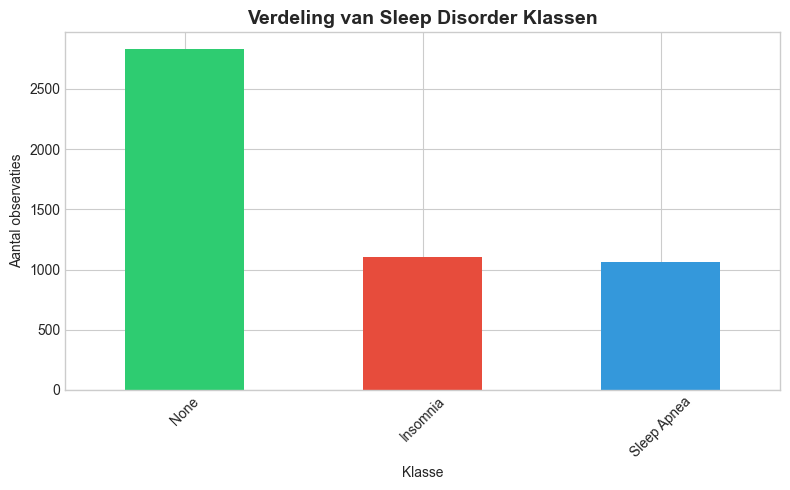


--------------------------------------------------------------------------------
INTERPRETATIE VAN KLASSENBALANS
--------------------------------------------------------------------------------

Imbalance ratio (grootste/kleinste klasse): 2.66
Er is enige klassenonevenwichtigheid. Overweeg stratified sampling en
  class_weight='balanced' parameter bij sommige modellen.


In [203]:
# ============================================================================
# STAP 3: TARGET VARIABELE ANALYSE
# ============================================================================
print("\n" + "="*80)
print("STAP 3: TARGET VARIABELE ANALYSE")
print("="*80)

print("\nDe target variabele 'Sleep Disorder' vormt de basis voor ons classificatieprobleem.")
print("We onderzoeken de verdeling van klassen om te bepalen of we te maken hebben met")
print("class imbalance en of dit speciale aandacht vereist tijdens modeltraining.\n")

# Vervang NaN in Sleep Disorder met 'None'
df['Sleep Disorder'] = df['Sleep Disorder'].fillna('None')

print("Verdeling van Sleep Disorder:")
class_distribution = df['Sleep Disorder'].value_counts()
print(class_distribution)
print(f"\nPercentages:")
print(df['Sleep Disorder'].value_counts(normalize=True) * 100)

plt.figure(figsize=(8, 5))
df['Sleep Disorder'].value_counts().plot(kind='bar', color=['#2ecc71', '#e74c3c', '#3498db'])
plt.title("Verdeling van Sleep Disorder Klassen", fontsize=14, fontweight='bold')
plt.xlabel("Klasse")
plt.ylabel("Aantal observaties")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("\n" + "-"*80)
print("INTERPRETATIE VAN KLASSENBALANS")
print("-"*80)

# Bereken imbalance ratio
min_class = class_distribution.min()
max_class = class_distribution.max()
imbalance_ratio = max_class / min_class

print(f"\nImbalance ratio (grootste/kleinste klasse): {imbalance_ratio:.2f}")

if imbalance_ratio < 1.5:
    print(" De klassen zijn redelijk gebalanceerd. Standaard modeltraining is geschikt.")
elif imbalance_ratio < 3:
    print("Er is enige klassenonevenwichtigheid. Overweeg stratified sampling en")
    print("  class_weight='balanced' parameter bij sommige modellen.")
else:
    print("Significante klassenonevenwichtigheid gedetecteerd!")
    print("  Overweeg: SMOTE, class weighting, of stratified k-fold cross-validation.")


In [204]:

# ============================================================================
# STAP 4: MULTICLASS VS BINARY CLASSIFICATIE - ONDERBOUWING
# ============================================================================
print("\n" + "="*80)
print("STAP 4: MODELTYPE KEUZE - MULTICLASS VS BINARY CLASSIFICATIE")
print("="*80)

print("""
RATIONALE VOOR MULTICLASS CLASSIFICATIE:
-----------------------------------------

Onze target variabele heeft drie categorieën:
1. None (geen slaapstoornis)
2. Insomnia (slapeloosheid)
3. Sleep Apnea (slaapapneu)

WAAROM MULTICLASS IN PLAATS VAN BINARY?
========================================

1. KLINISCHE RELEVANTIE:
   • Insomnia en Sleep Apnea hebben verschillende oorzaken, symptomen en behandelingen
   • Een binair model (wel/geen stoornis) zou deze cruciale distinctie verliezen
   • Voor medisch personeel is het essentieel om het TYPE stoornis te identificeren

2. BEHANDELINGSIMPLICATIES:
   • Insomnia → vaak cognitieve gedragstherapie, slaaphygiëne, medicatie
   • Sleep Apnea → CPAP-apparaat, gewichtsreductie, operatieve ingrepen
   • De aanpak verschilt fundamenteel

3. DIAGNOSTISCHE WAARDE:
   • Verschillende risicoprofielen: Sleep Apnea correleert met BMI en hartslag,
     Insomnia vaak met stress en levensstijlfactoren
   • Een multiclass model kan deze subtiele patronen onderscheiden

4. MODELCOMPLEXITEIT VS INFORMATIEBEHOUD:
   • Trade-off: multiclass is complexer, maar behoudt essentiële informatie
   • In medische context weegt informatieverlies zwaarder dan modelcomplexiteit


""")



STAP 4: MODELTYPE KEUZE - MULTICLASS VS BINARY CLASSIFICATIE

RATIONALE VOOR MULTICLASS CLASSIFICATIE:
-----------------------------------------

Onze target variabele heeft drie categorieën:
1. None (geen slaapstoornis)
2. Insomnia (slapeloosheid)
3. Sleep Apnea (slaapapneu)

WAAROM MULTICLASS IN PLAATS VAN BINARY?

1. KLINISCHE RELEVANTIE:
   • Insomnia en Sleep Apnea hebben verschillende oorzaken, symptomen en behandelingen
   • Een binair model (wel/geen stoornis) zou deze cruciale distinctie verliezen
   • Voor medisch personeel is het essentieel om het TYPE stoornis te identificeren

2. BEHANDELINGSIMPLICATIES:
   • Insomnia → vaak cognitieve gedragstherapie, slaaphygiëne, medicatie
   • Sleep Apnea → CPAP-apparaat, gewichtsreductie, operatieve ingrepen
   • De aanpak verschilt fundamenteel

3. DIAGNOSTISCHE WAARDE:
   • Verschillende risicoprofielen: Sleep Apnea correleert met BMI en hartslag,
     Insomnia vaak met stress en levensstijlfactoren
   • Een multiclass model kan de

In [205]:

# ============================================================================
# STAP 5: FEATURE TYPE IDENTIFICATIE EN CATEGORISATIE
# ============================================================================
print("\n" + "="*80)
print("STAP 5: FEATURE TYPE IDENTIFICATIE")
print("="*80)

# Numerieke kolommen
num_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Verwijder Person ID uit numerieke features (is geen predictive feature)
num_cols = [col for col in num_cols if col != 'Person ID']

# Categorische kolommen
cat_cols = df.select_dtypes(include=['object']).columns.tolist()
# Verwijder target uit categorische features
cat_feature_cols = [col for col in cat_cols if col != 'Sleep Disorder']

print(f"\nNumerieke features ({len(num_cols)}):")
for col in num_cols:
    print(f"  • {col}")

print(f"\nCategorische features ({len(cat_feature_cols)}):")
for col in cat_feature_cols:
    unique_values = df[col].nunique()
    print(f"  • {col} ({unique_values} unieke waarden)")
    print(f"    Waarden: {df[col].unique()[:5].tolist()}")



STAP 5: FEATURE TYPE IDENTIFICATIE

Numerieke features (7):
  • Age
  • Sleep Duration
  • Quality of Sleep
  • Physical Activity Level
  • Stress Level
  • Heart Rate
  • Daily Steps

Categorische features (4):
  • Gender (2 unieke waarden)
    Waarden: ['Male', 'Female']
  • Occupation (11 unieke waarden)
    Waarden: ['Software Engineer', 'Doctor', 'Sales Representative', 'Teacher', 'Nurse']
  • BMI Category (4 unieke waarden)
    Waarden: ['Overweight', 'Normal', 'Obese', 'Normal Weight']
  • Blood Pressure (114 unieke waarden)
    Waarden: ['126/83', '126/80', '125/80', '142/90', '141/91']


Training: 4000 samples (80%)
Test: 1000 samples (20%)


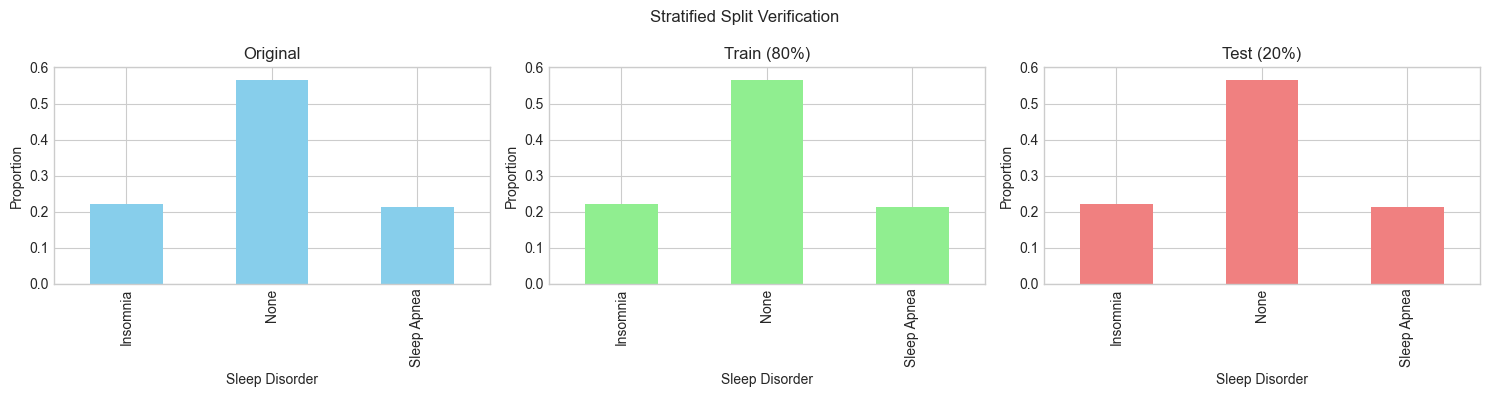

In [206]:
# ============================================================================
# STAP 6: TRAIN-TEST SPLIT - DATA PARTITIONERING
# ============================================================================

# Split on raw data (before encoding/scaling to prevent data leakage)
X = df.drop(['Sleep Disorder', 'Person ID'], axis=1)
y = df['Sleep Disorder']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)

print(f"Training: {X_train.shape[0]} samples ({100*len(X_train)/len(X):.0f}%)")
print(f"Test: {X_test.shape[0]} samples ({100*len(X_test)/len(X):.0f}%)")

# Verify stratification
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for ax, data, title in zip(axes, 
                            [y, y_train, y_test], 
                            ['Original', 'Train (80%)', 'Test (20%)']):
    data.value_counts(normalize=True).sort_index().plot(
        kind='bar', ax=ax, color=['skyblue', 'lightgreen', 'lightcoral'][axes.tolist().index(ax)]
    )
    ax.set_title(title)
    ax.set_ylabel('Proportion')
    ax.set_ylim(0, 0.6)
plt.suptitle('Stratified Split Verification', fontsize=12, y=0.98)
plt.tight_layout()
plt.show()

7. Exploratory Data Analysis (EDA)

Let op: analyses alleen op de trainingset om data leakage te voorkomen.

Doelen:

Discriminerende features voor slaapstoornis-classificatie vinden

Multicollineariteit detecteren

Inzicht in class separability

Outlierbehandeling en featureselectie onderbouwen

Verwachte patronen:

BMI: hoger bij Sleep Apnea (obesitas = belangrijke risicofactor)

Hartslag: hoger bij Sleep Apnea (zuurstoftekort → sympathische activatie)

Slaapkwaliteit: lager bij beide stoornissen (primaire indicator)

Stressniveau: hoger bij Insomnia (hyperarousal)

Training set: 4000 samples × 12 features

Mean Feature Values by Sleep Disorder Class


Age:
----------------------------------------


,mean,std
Sleep Disorder,,
Insomnia,42.88,6.68
None,39.94,8.32
Sleep Apnea,47.14,9.91


  → Moderate discriminator (17% relative difference)

Sleep Duration:
----------------------------------------


,mean,std
Sleep Disorder,,
Insomnia,6.85,0.65
None,7.28,0.79
Sleep Apnea,7.17,0.91



Quality of Sleep:
----------------------------------------


,mean,std
Sleep Disorder,,
Insomnia,6.84,1.39
None,7.45,1.47
Sleep Apnea,7.28,1.75



Physical Activity Level:
----------------------------------------


,mean,std
Sleep Disorder,,
Insomnia,52.18,17.29
None,57.15,20.92
Sleep Apnea,67.16,20.28


  ✓ Strong discriminator (25% relative difference)

Stress Level:
----------------------------------------


,mean,std
Sleep Disorder,,
Insomnia,5.64,1.85
None,5.26,1.92
Sleep Apnea,5.35,2.23



Heart Rate:
----------------------------------------


,mean,std
Sleep Disorder,,
Insomnia,70.77,5.33
None,69.43,3.71
Sleep Apnea,71.57,5.21



Daily Steps:
----------------------------------------


,mean,std
Sleep Disorder,,
Insomnia,6404.28,1456.41
None,6912.57,1519.33
Sleep Apnea,7290.01,1942.16


  → Moderate discriminator (13% relative difference)

Feature Distributions


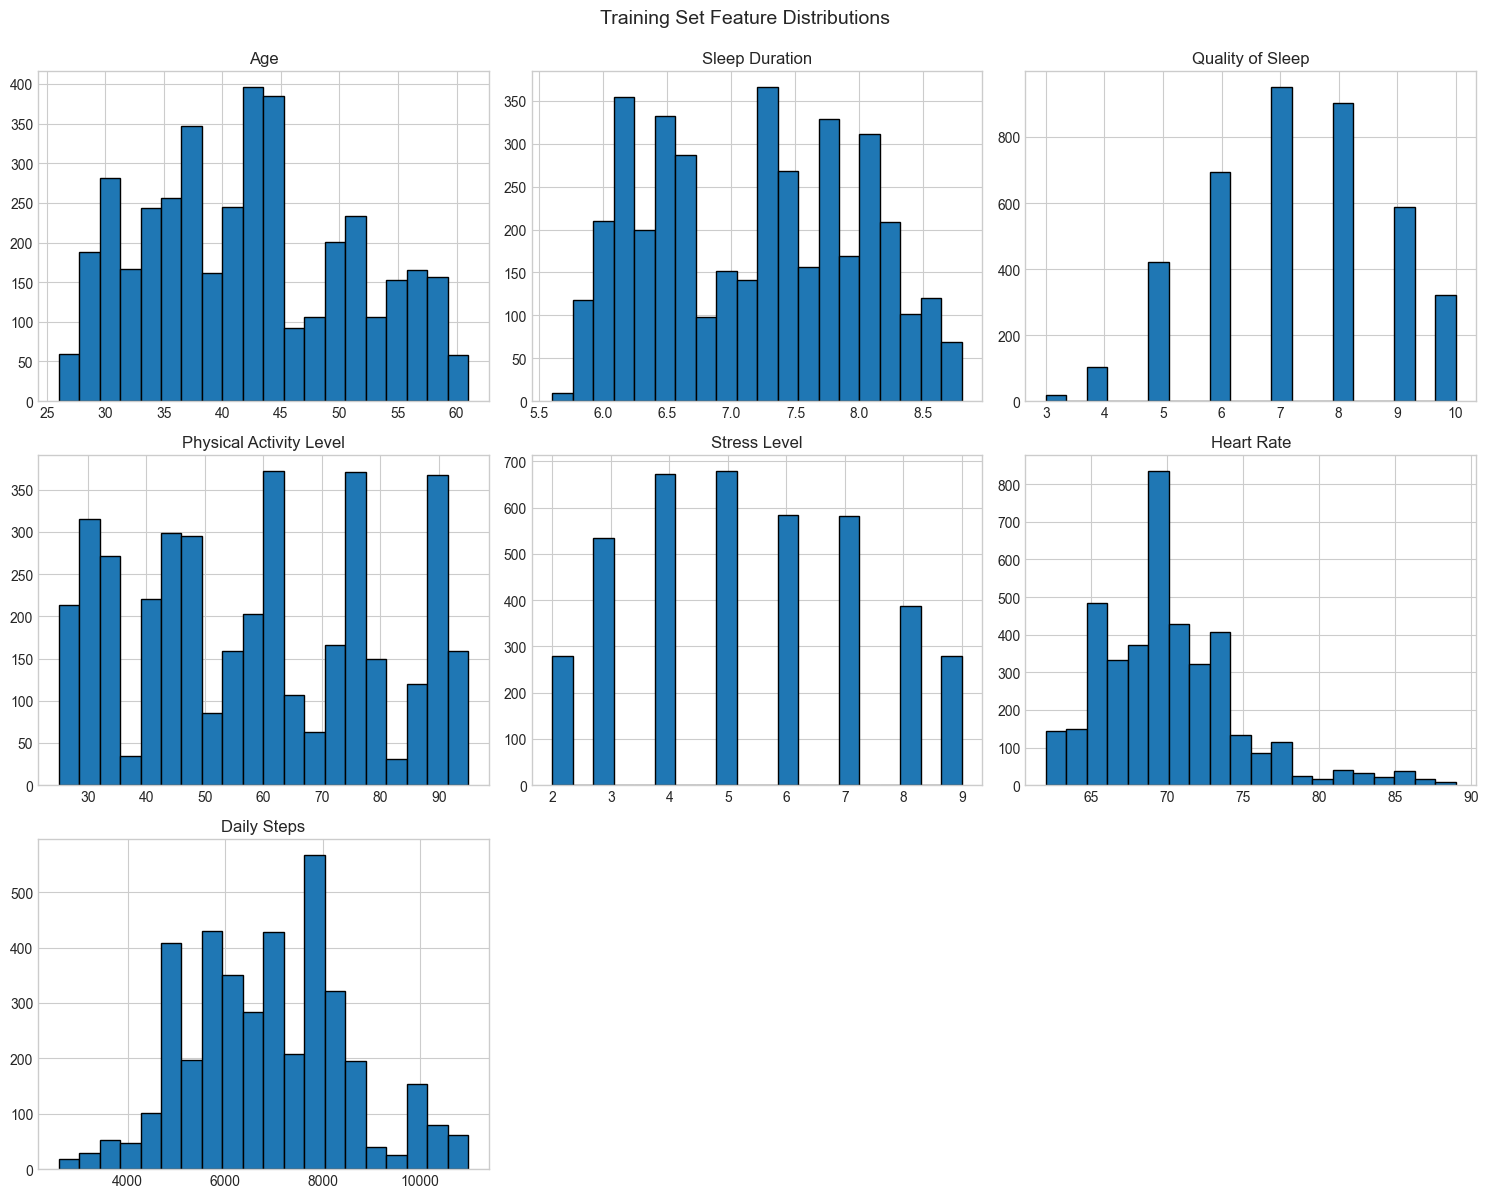


Correlation Analysis


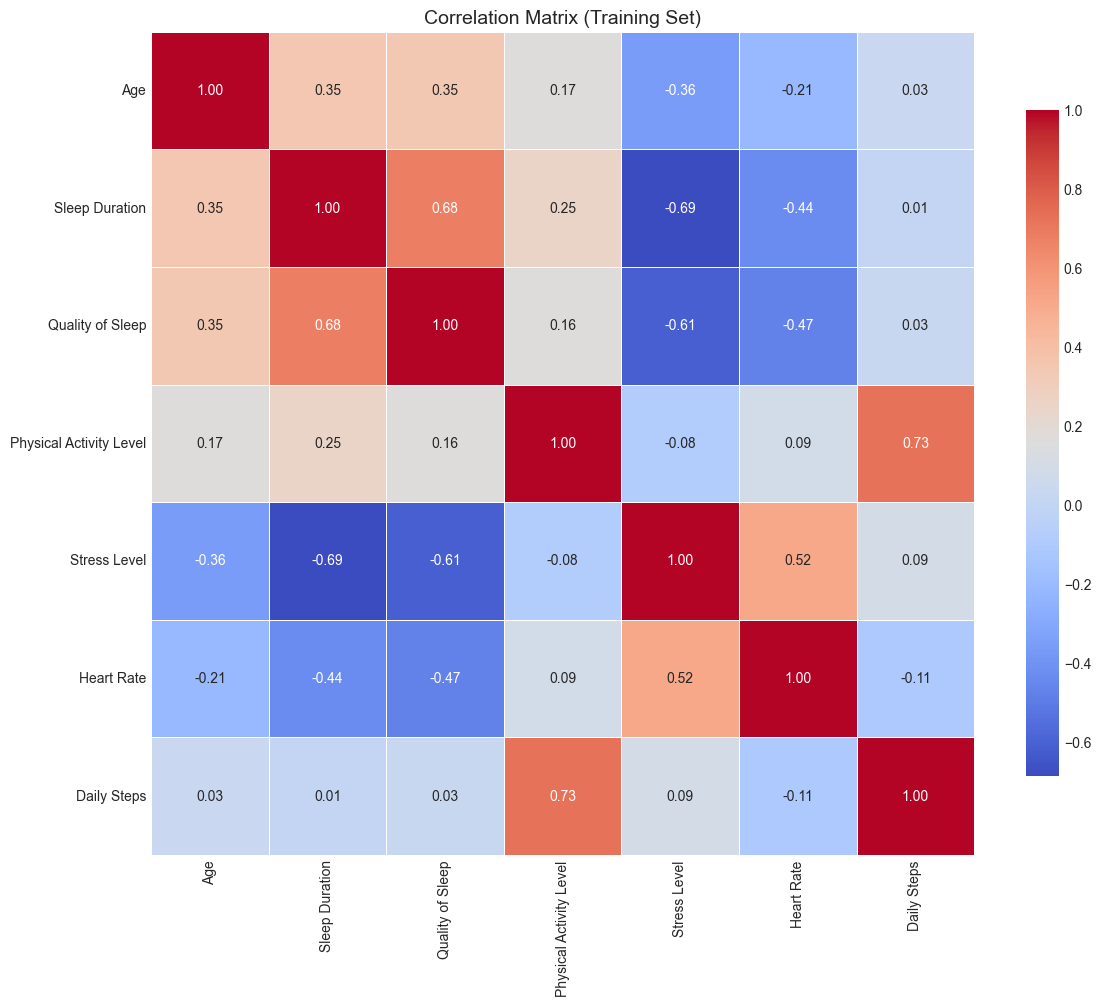


Multicollinearity check (|r| > 0.7):
  ⚠ Physical Activity Level ↔ Daily Steps: r = 0.728

Pairwise Relationships (Key Features)


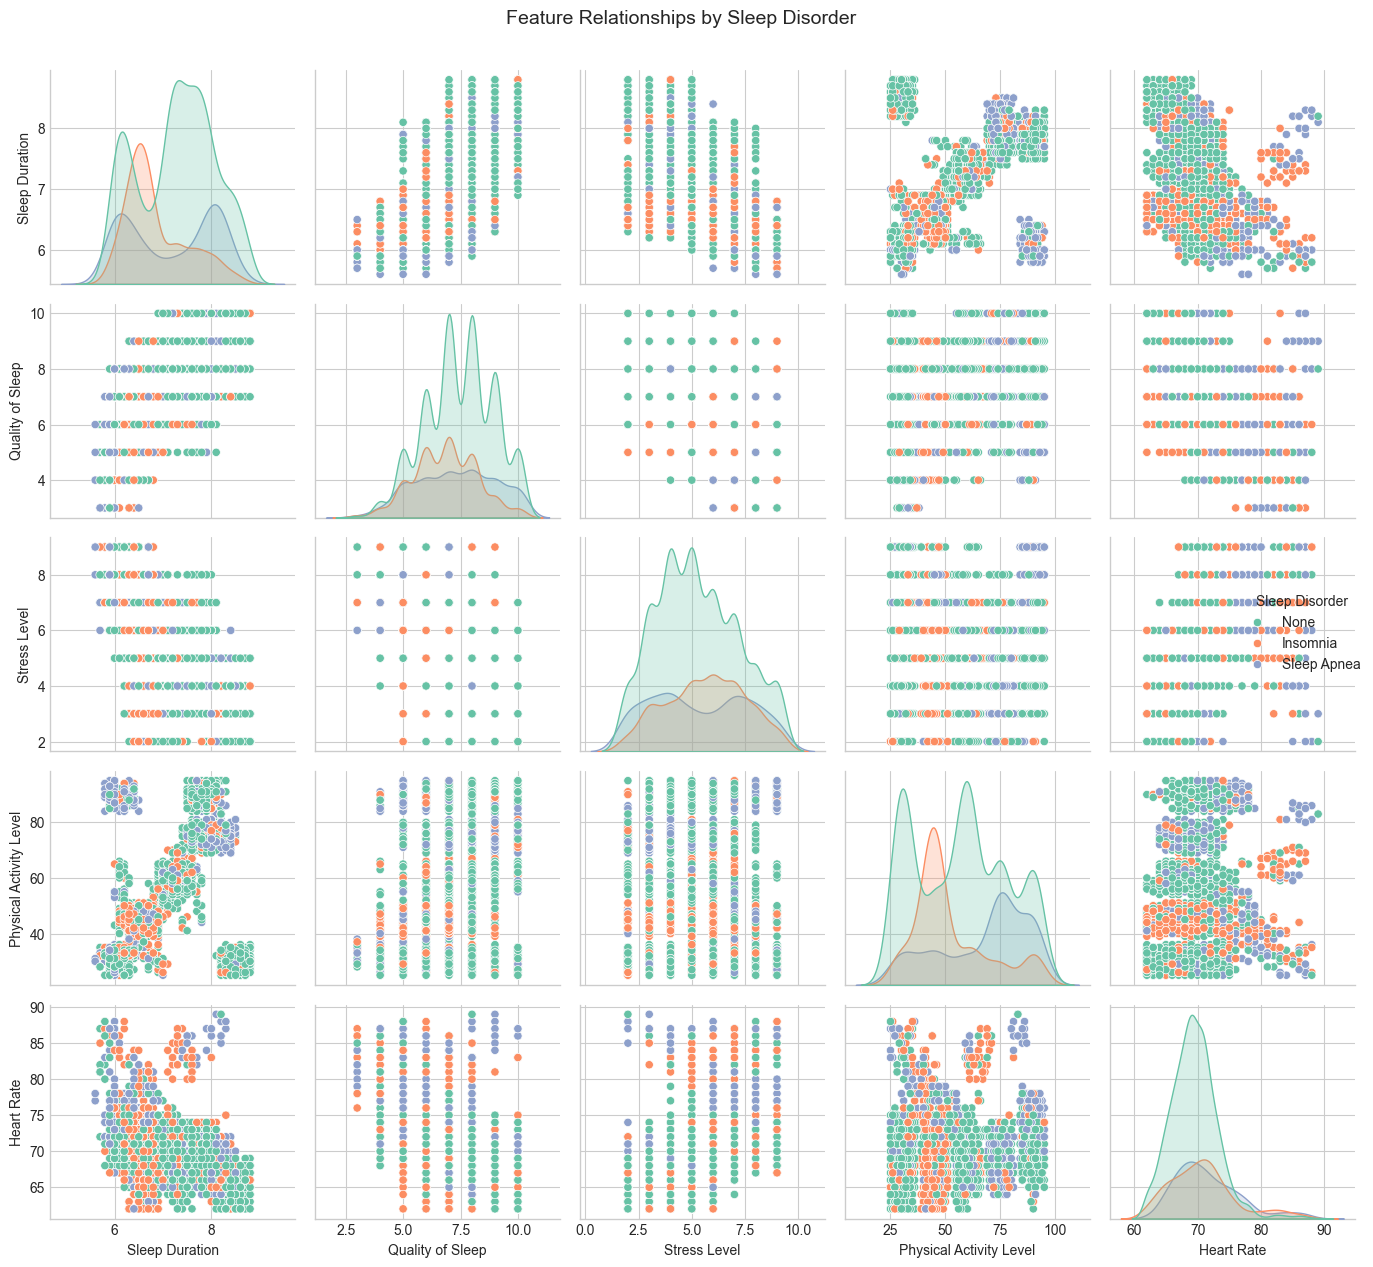


✓ EDA complete - insights will guide outlier treatment and feature selection


In [207]:
# ============================================================================
# Stap 7
# ============================================================================

# Combine X_train and y_train for analysis
df_train = X_train.copy()
df_train['Sleep Disorder'] = y_train.values

print(f"Training set: {df_train.shape[0]} samples × {df_train.shape[1]} features\n")

# --- Per-Class Feature Comparison ---
print("="*80)
print("Mean Feature Values by Sleep Disorder Class")
print("="*80 + "\n")

for col in num_cols:
    print(f"\n{col}:")
    print("-"*40)
    
    class_stats = df_train.groupby('Sleep Disorder')[col].agg(['mean', 'std']).round(2)
    display(class_stats)
    
    # Calculate discriminative power
    means = df_train.groupby('Sleep Disorder')[col].mean()
    rel_diff = (means.max() - means.min()) / means.mean()
    
    if rel_diff > 0.2:
        print(f"  ✓ Strong discriminator ({rel_diff*100:.0f}% relative difference)")
    elif rel_diff > 0.1:
        print(f"  → Moderate discriminator ({rel_diff*100:.0f}% relative difference)")

# --- Distributions ---
print("\n" + "="*80)
print("Feature Distributions")
print("="*80)

axes = df_train[num_cols].hist(figsize=(15, 12), bins=20, edgecolor='black')
plt.suptitle("Training Set Feature Distributions", fontsize=14, y=0.995)
plt.tight_layout()
plt.show()

# --- Correlation Analysis ---
print("\n" + "="*80)
print("Correlation Analysis")
print("="*80)

plt.figure(figsize=(12, 10))
correlation_matrix = df_train[num_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt='.2f', 
            square=True, linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Correlation Matrix (Training Set)", fontsize=14)
plt.tight_layout()
plt.show()

# Detect multicollinearity
print("\nMulticollinearity check (|r| > 0.7):")
strong_corr = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.7:
            print(f"  ⚠ {correlation_matrix.columns[i]} ↔ {correlation_matrix.columns[j]}: "
                  f"r = {correlation_matrix.iloc[i, j]:.3f}")
            strong_corr.append((correlation_matrix.columns[i], correlation_matrix.columns[j]))

if not strong_corr:
    print("  ✓ No strong correlations detected")

# --- Pairplot (subset of key features) ---
print("\n" + "="*80)
print("Pairwise Relationships (Key Features)")
print("="*80)

key_features = [
    'Sleep Duration', 'Quality of Sleep', 'Stress Level',
    'Physical Activity Level', 'Heart Rate', 'BMI'
]
key_features = [f for f in key_features if f in df_train.columns]

sns.pairplot(df_train[key_features + ['Sleep Disorder']], 
             hue='Sleep Disorder', diag_kind='kde', palette='Set2')
plt.suptitle("Feature Relationships by Sleep Disorder", y=1.01, fontsize=14)
plt.tight_layout()
plt.show()

print("\n✓ EDA complete - insights will guide outlier treatment and feature selection")

## Stap 8 – Outlier-detectie en behandeling

We gebruiken de **IQR-methode** om outliers te herkennen:

- **IQR = Q3 − Q1**
- **Lower bound = Q1 − 1.5 × IQR**
- **Upper bound = Q3 + 1.5 × IQR**

### Waarom niet gewoon outliers verwijderen?
In dit project verwijderen we outliers **niet automatisch**. In plaats daarvan gebruiken we een **conservatieve aanpak: capping/winsorization**.  
Dat betekent: extreem lage of hoge waarden worden **afgekapt** naar een minimum- of maximumgrens.

**Voordeel:** we behouden alle observaties (belangrijk bij medische data), maar verminderen de invloed van onrepresentatieve uitschieters op het model.

### Data leakage voorkomen (heel belangrijk)
We berekenen outlier-grenzen **alleen op de trainingsdata** en passen die daarna toe op zowel train als test.

**Werkwijze:**
1. Bereken Q1, Q3 en IQR op `X_train`
2. Bepaal lower/upper bounds op basis van die train-statistieken
3. Pas capping toe op `X_train`
4. Pas **dezelfde** bounds toe op `X_test` (dus **niet** opnieuw berekenen)

Zo voorkomen we dat testinformatie per ongeluk het model beïnvloedt.



--------------------------------------------------------------------------------
OUTLIER IDENTIFICATIE PER VARIABELE (TRAINING SET)
--------------------------------------------------------------------------------

Numerieke features in training set: 7
Features: ['Age', 'Sleep Duration', 'Quality of Sleep', 'Physical Activity Level', 'Stress Level', 'Heart Rate', 'Daily Steps']


Outlier Samenvatting Training Set (gesorteerd op percentage):


,count,pct,lower,upper,Q1,Q3,IQR
Heart Rate,171,4.275,59.5,79.5,67.0,72.0,5.0
Age,0,0.000,14.0,70.0,35.0,49.0,14.0
Sleep Duration,0,0.000,4.3,9.9,6.4,7.8,1.4
Quality of Sleep,0,0.000,3.0,11.0,6.0,8.0,2.0
Physical Activity Level,0,0.000,-7.5,124.5,42.0,75.0,33.0
Stress Level,0,0.000,-0.5,11.5,4.0,7.0,3.0
Daily Steps,0,0.000,2355.0,11371.0,5736.0,7990.0,2254.0



--------------------------------------------------------------------------------
VISUALISATIE: BOXPLOTS VOOR OUTLIER DETECTIE (TRAINING SET)
--------------------------------------------------------------------------------


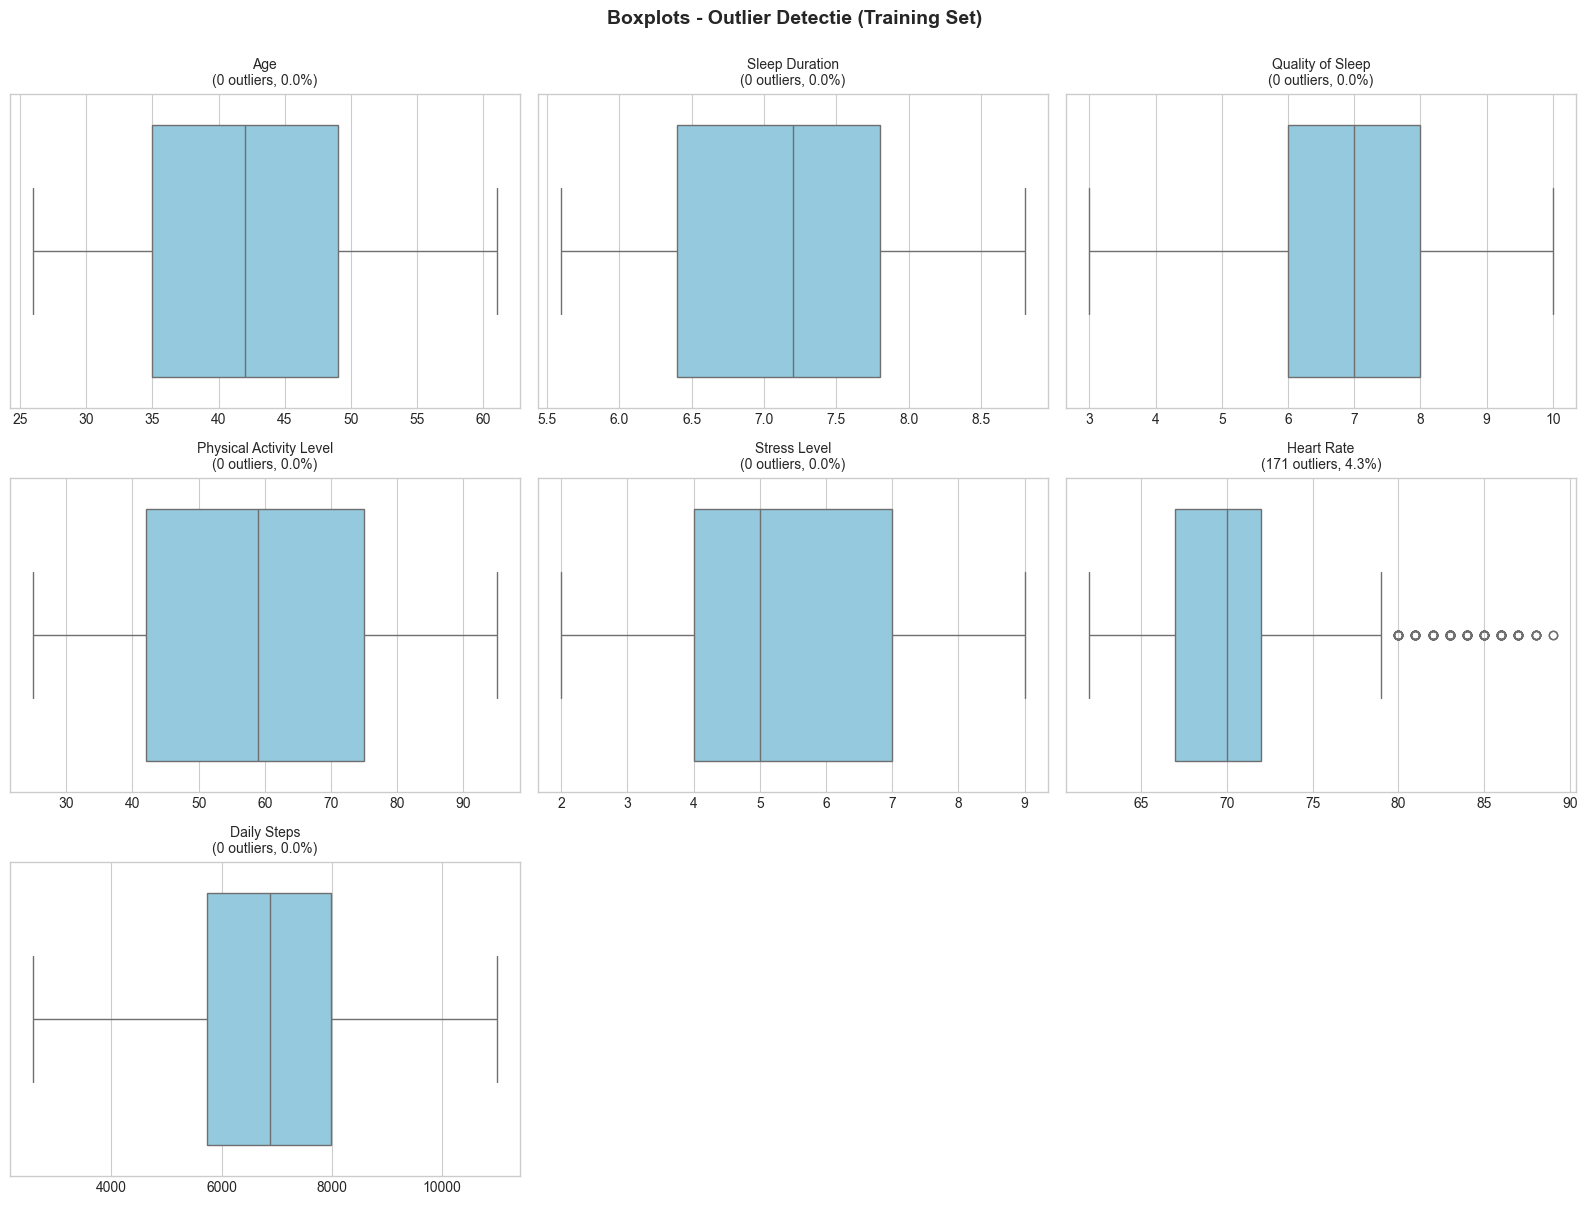


--------------------------------------------------------------------------------
IMPLEMENTATIE VAN BEHANDELING (CAPPING / WINSORIZATION)
--------------------------------------------------------------------------------

1. DAILY STEPS - Winsorization / Capping (1% - 99%)
----------------------------------------
   TRAIN originele range: 2583 - 10990 stappen
   TEST originele range: 2746 - 10958 stappen
   Capping grenzen (van train): 3277 - 10779 stappen
   ✓ Capping toegepast op train (4000 samples)
   ✓ DEZELFDE grenzen toegepast op test (1000 samples)
   Rationale: Extreme waarden kunnen tracking fouten zijn. Winsorization behoudt data maar beperkt invloed.

2. HEART RATE - Capping naar plausibele range (40 - 120 bpm)
----------------------------------------
   TRAIN originele hartslag: 62 - 89 bpm
   TEST originele hartslag: 62 - 87 bpm
   Capping grenzen (medisch plausibel): 40 - 120 bpm
   ✓ Capping toegepast op train (4000 samples)
   ✓ DEZELFDE grenzen toegepast op test (1000 s

In [208]:
# ============================================================================
# STAP 8: OUTLIER DETECTIE EN BEHANDELING 
# ============================================================================

print("\n" + "-"*80)
print("OUTLIER IDENTIFICATIE PER VARIABELE (TRAINING SET)")
print("-"*80)

# Maak kopieën om originele data te behouden
X_train_clean = X_train.copy()
X_test_clean = X_test.copy()

# Identificeer numerieke kolommen in X_train
num_cols_train = X_train_clean.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nNumerieke features in training set: {len(num_cols_train)}")
print(f"Features: {num_cols_train}\n")

# Bereken outlier statistics op TRAIN data
outlier_info = {}
outlier_bounds = {}  # Opslaan voor toepassen op test set

for col in num_cols_train:
    # Bereken op TRAIN
    q1 = X_train_clean[col].quantile(0.25)
    q3 = X_train_clean[col].quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    
    # Identificeer outliers in train
    mask = (X_train_clean[col] < lower) | (X_train_clean[col] > upper)
    outlier_count = int(mask.sum())
    outlier_pct = 100 * outlier_count / len(X_train_clean)
    
    # Opslaan voor rapportage
    outlier_info[col] = {
        'count': outlier_count,
        'pct': float(outlier_pct),
        'lower': float(lower),
        'upper': float(upper),
        'Q1': float(q1),
        'Q3': float(q3),
        'IQR': float(iqr)
    }
    
    # Opslaan bounds voor test set
    outlier_bounds[col] = {'lower': lower, 'upper': upper}

outlier_summary = pd.DataFrame.from_dict(outlier_info, orient='index')
outlier_summary = outlier_summary.sort_values('pct', ascending=False)

print("\nOutlier Samenvatting Training Set (gesorteerd op percentage):")
display(outlier_summary)

print("\n" + "-"*80)
print("VISUALISATIE: BOXPLOTS VOOR OUTLIER DETECTIE (TRAINING SET)")
print("-"*80)

n_cols_plot = len(num_cols_train)
n_rows = (n_cols_plot + 2) // 3  # Bereken aantal rijen nodig
n_cols = min(3, n_cols_plot)

plt.figure(figsize=(16, 4 * n_rows))
for i, col in enumerate(num_cols_train, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(x=X_train_clean[col], color='skyblue')
    title = f"{col}\n({outlier_summary.loc[col, 'count']:.0f} outliers, {outlier_summary.loc[col, 'pct']:.1f}%)"
    plt.title(title, fontsize=10)
    plt.xlabel('')
plt.suptitle("Boxplots - Outlier Detectie (Training Set)", fontsize=14, fontweight='bold', y=1.00)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 8B: OUTLIER BEHANDELING - CAPPING/WINSORIZATION
# ============================================================================


print("\n" + "-"*80)
print("IMPLEMENTATIE VAN BEHANDELING (CAPPING / WINSORIZATION)")
print("-"*80)

# Strategie 1: Winsorization voor Daily Steps (1% - 99%)
if 'Daily Steps' in X_train_clean.columns:
    print("\n1. DAILY STEPS - Winsorization / Capping (1% - 99%)")
    print("-" * 40)
    
    # TRAIN: bereken percentiles
    low_p_train = X_train_clean['Daily Steps'].quantile(0.01)
    high_p_train = X_train_clean['Daily Steps'].quantile(0.99)
    
    # Toon originele ranges
    original_min_train = X_train_clean['Daily Steps'].min()
    original_max_train = X_train_clean['Daily Steps'].max()
    original_min_test = X_test_clean['Daily Steps'].min()
    original_max_test = X_test_clean['Daily Steps'].max()
    
    print(f"   TRAIN originele range: {original_min_train:.0f} - {original_max_train:.0f} stappen")
    print(f"   TEST originele range: {original_min_test:.0f} - {original_max_test:.0f} stappen")
    print(f"   Capping grenzen (van train): {low_p_train:.0f} - {high_p_train:.0f} stappen")
    
    # Pas capping toe op TRAIN
    X_train_clean['Daily Steps'] = np.clip(X_train_clean['Daily Steps'], low_p_train, high_p_train)
    
    # Pas DEZELFDE grenzen toe op TEST
    X_test_clean['Daily Steps'] = np.clip(X_test_clean['Daily Steps'], low_p_train, high_p_train)
    
    print(f"   ✓ Capping toegepast op train ({len(X_train_clean)} samples)")
    print(f"   ✓ DEZELFDE grenzen toegepast op test ({len(X_test_clean)} samples)")
    print("   Rationale: Extreme waarden kunnen tracking fouten zijn. Winsorization behoudt data maar beperkt invloed.")

# Strategie 2: Heart Rate - capping naar plausibele range (40 - 120 bpm)
if 'Heart Rate' in X_train_clean.columns:
    print("\n2. HEART RATE - Capping naar plausibele range (40 - 120 bpm)")
    print("-" * 40)
    
    # Medische plausibiliteitsgrenzen (domeinkennis)
    hr_lower, hr_upper = 40, 120
    
    # Toon originele ranges
    original_hr_min_train = X_train_clean['Heart Rate'].min()
    original_hr_max_train = X_train_clean['Heart Rate'].max()
    original_hr_min_test = X_test_clean['Heart Rate'].min()
    original_hr_max_test = X_test_clean['Heart Rate'].max()
    
    print(f"   TRAIN originele hartslag: {original_hr_min_train:.0f} - {original_hr_max_train:.0f} bpm")
    print(f"   TEST originele hartslag: {original_hr_min_test:.0f} - {original_hr_max_test:.0f} bpm")
    print(f"   Capping grenzen (medisch plausibel): {hr_lower} - {hr_upper} bpm")
    
    # Pas capping toe op TRAIN
    X_train_clean['Heart Rate'] = X_train_clean['Heart Rate'].clip(lower=hr_lower, upper=hr_upper)
    
    # Pas DEZELFDE grenzen toe op TEST
    X_test_clean['Heart Rate'] = X_test_clean['Heart Rate'].clip(lower=hr_lower, upper=hr_upper)
    
    print(f"   ✓ Capping toegepast op train ({len(X_train_clean)} samples)")
    print(f"   ✓ DEZELFDE grenzen toegepast op test ({len(X_test_clean)} samples)")
    print("   Rationale: Clipping behoudt observaties maar vermindert invloed van onrealistische uitschieters.")

# Strategie 3: Plausibiliteitscontroles (geen verwijdering, enkel rapportage)
print("\n3. ANDERE VARIABELEN - Plausibiliteitscheck (geen verwijdering)")
print("-" * 40)

# Sleep Duration (we behouden, want korte/lange slaap kan klinisch relevant zijn)
if 'Sleep Duration' in X_train_clean.columns:
    invalid_sleep_train = (X_train_clean['Sleep Duration'] < 0) | (X_train_clean['Sleep Duration'] > 24)
    invalid_sleep_test = (X_test_clean['Sleep Duration'] < 0) | (X_test_clean['Sleep Duration'] > 24)
    
    if invalid_sleep_train.sum() > 0 or invalid_sleep_test.sum() > 0:
        print(f"   ⚠ Sleep Duration: {invalid_sleep_train.sum()} train + {invalid_sleep_test.sum()} test waarden buiten 0-24 uur")
    else:
        print("   ✓ Sleep Duration: alle waarden binnen 0-24 uur (train + test)")

# BMI (optioneel)
if 'BMI' in X_train_clean.columns:
    invalid_bmi_train = (X_train_clean['BMI'] < 10) | (X_train_clean['BMI'] > 70)
    invalid_bmi_test = (X_test_clean['BMI'] < 10) | (X_test_clean['BMI'] > 70)
    
    if invalid_bmi_train.sum() > 0 or invalid_bmi_test.sum() > 0:
        print(f"   ⚠ BMI: {invalid_bmi_train.sum()} train + {invalid_bmi_test.sum()} test waarden buiten 10-70")
    else:
        print("   ✓ BMI waarden binnen plausibel bereik (train + test)")

# Age
if 'Age' in X_train_clean.columns:
    invalid_age_train = (X_train_clean['Age'] < 18) | (X_train_clean['Age'] > 100)
    invalid_age_test = (X_test_clean['Age'] < 18) | (X_test_clean['Age'] > 100)
    
    if invalid_age_train.sum() > 0 or invalid_age_test.sum() > 0:
        print(f"   ⚠ Age: {invalid_age_train.sum()} train + {invalid_age_test.sum()} test waarden buiten 18-100 jaar")
    else:
        print("   ✓ Age waarden binnen plausibel bereik (train + test)")

# ============================================================================
# STAP 8C: RESULTAAT VAN OUTLIER BEHANDELING
# ============================================================================
print("\n" + "-"*80)
print("RESULTAAT VAN OUTLIER BEHANDELING (CAPPING / WINSORIZATION)")
print("-"*80)

# We hebben geen rijen verwijderd; we hebben waarden gecapped/winsorized
rows_removed = 0
pct_removed = 0.0

print(f"\nTRAINING SET:")
print(f"  • Originele grootte: {X_train.shape[0]} rijen × {X_train.shape[1]} kolommen")
print(f"  • Na behandeling: {X_train_clean.shape[0]} rijen × {X_train_clean.shape[1]} kolommen")
print(f"  • Verwijderd: {rows_removed} rijen ({pct_removed:.2f}%)")

print(f"\nTEST SET:")
print(f"  • Originele grootte: {X_test.shape[0]} rijen × {X_test.shape[1]} kolommen")
print(f"  • Na behandeling: {X_test_clean.shape[0]} rijen × {X_test_clean.shape[1]} kolommen")
print(f"  • Verwijderd: {rows_removed} rijen ({pct_removed:.2f}%)")

print("\n✓ Geen rijen verwijderd - we hebben capping toegepast op extreme waarden")
print("✓ Outlier grenzen bepaald op TRAIN en toegepast op BEIDE sets (geen data leakage)")
print("✓ Extreme waarden beperkt via winsorization/clipping")

# Update de variabelen voor gebruik in volgende stappen
X_train = X_train_clean
X_test = X_test_clean

print("\n X_train en X_test zijn nu updated met outlier behandeling")
print("   Deze worden gebruikt in volgende stappen (encoding, scaling)")

## Stap 9 – Feature encoding (heel kort)

Modellen hebben **numerieke** input nodig, dus we zetten categorische data om.

- **Blood Pressure**: niet one-hot (te veel unieke waarden), maar splitsen:
  - `"120/80"` → `Systolic=120`, `Diastolic=80`

- **Categorische features**: **one-hot encoding** met `drop_first=True`.
  - Train en test moeten dezelfde kolommen hebben → `get_dummies()` + `align()`.

- **Target (y)**: **LabelEncoder**
  - `fit` op `y_train`, `transform` op `y_train` én `y_test`.

**Belangrijk:** alles **fit op train**, daarna **toepassen op test** → geen data leakage.


In [209]:
# ============================================================================
# STAP 9: FEATURE ENCODING - CATEGORISCHE VARIABELEN TRANSFORMEREN
# ============================================================================


def split_blood_pressure(df):
    """Split Blood Pressure kolom in Systolic en Diastolic"""
    df = df.copy()
    
    # Split "120/80" in twee delen
    bp_split = df['Blood Pressure'].str.split('/', expand=True)
    
    # Converteer naar integers
    df['Systolic'] = bp_split[0].astype(int)
    df['Diastolic'] = bp_split[1].astype(int)
    
    # Verwijder originele Blood Pressure kolom
    df = df.drop('Blood Pressure', axis=1)
    
    return df

print(f"\nVOOR transformatie:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • X_test shape: {X_test.shape}")
print(f"  • Blood Pressure unieke waarden in train: {X_train['Blood Pressure'].nunique()}")
print(f"  • Blood Pressure unieke waarden in test: {X_test['Blood Pressure'].nunique()}")

print("\nVoorbeeld Blood Pressure waarden:")
print(X_train['Blood Pressure'].head(10).tolist())

# Voer transformatie uit
X_train = split_blood_pressure(X_train)
X_test = split_blood_pressure(X_test)

print(f"\nNA transformatie:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • X_test shape: {X_test.shape}")

print("\nNieuwe kolommen toegevoegd:")
print(f"  • Systolic - Range train: [{X_train['Systolic'].min()}, {X_train['Systolic'].max()}]")
print(f"  • Systolic - Range test: [{X_test['Systolic'].min()}, {X_test['Systolic'].max()}]")
print(f"  • Diastolic - Range train: [{X_train['Diastolic'].min()}, {X_train['Diastolic'].max()}]")
print(f"  • Diastolic - Range test: [{X_test['Diastolic'].min()}, {X_test['Diastolic'].max()}]")

print("\nVoorbeeld eerste 5 rijen:")
print(X_train[['Systolic', 'Diastolic']].head())

print("\n✓ Blood Pressure succesvol gesplitst in 2 numerieke features")

# ============================================================================
# STAP 9B: IDENTIFICEER RESTERENDE CATEGORISCHE FEATURES
# ============================================================================
print("\n" + "-"*80)
print("IDENTIFICATIE VAN CATEGORISCHE FEATURES")
print("-"*80)

# Identificeer categorische kolommen in X_train
cat_cols_train = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"\nCategorische features in training set ({len(cat_cols_train)}):")
for col in cat_cols_train:
    unique_vals_train = X_train[col].nunique()
    unique_vals_test = X_test[col].nunique()
    print(f"  • {col}:")
    print(f"    - Train: {unique_vals_train} categorieën → {X_train[col].unique().tolist()}")
    print(f"    - Test: {unique_vals_test} categorieën → {X_test[col].unique().tolist()}")

# Check voor nieuwe categorieën in test set (kunnen problemen geven)
print("\n⚠️ CONTROLE: Nieuwe categorieën in test set?")
for col in cat_cols_train:
    train_cats = set(X_train[col].unique())
    test_cats = set(X_test[col].unique())
    new_cats = test_cats - train_cats
    
    if new_cats:
        print(f"  ⚠️ {col}: Test heeft nieuwe categorieën: {new_cats}")
        print(f"     → Deze worden behandeld als 'unknown' tijdens encoding")
    else:
        print(f"  ✓ {col}: Geen nieuwe categorieën in test")

# ============================================================================
# STAP 9C: ONE-HOT ENCODING VOOR FEATURES
# ============================================================================

print(f"\nVOOR encoding:")
print(f"  • X_train: {X_train.shape[0]} rijen × {X_train.shape[1]} kolommen")
print(f"  • X_test: {X_test.shape[0]} rijen × {X_test.shape[1]} kolommen")

# One-hot encoding op TRAIN
X_train_encoded = pd.get_dummies(X_train, columns=cat_cols_train, drop_first=True)

# One-hot encoding op TEST (met dezelfde kolommen)
X_test_encoded = pd.get_dummies(X_test, columns=cat_cols_train, drop_first=True)

print(f"\nNA encoding (voor align):")
print(f"  • X_train_encoded: {X_train_encoded.shape[0]} rijen × {X_train_encoded.shape[1]} kolommen")
print(f"  • X_test_encoded: {X_test_encoded.shape[0]} rijen × {X_test_encoded.shape[1]} kolommen")

# BELANGRIJK: Align zodat beide sets dezelfde kolommen hebben
# Kolommen die in train maar niet in test zitten → voeg toe aan test met 0
# Kolommen die in test maar niet in train zitten → verwijder uit test
X_train_encoded, X_test_encoded = X_train_encoded.align(X_test_encoded, join='left', axis=1, fill_value=0)

print(f"\nNA align (train en test hebben nu IDENTIEKE kolommen):")
print(f"  • X_train_encoded: {X_train_encoded.shape[0]} rijen × {X_train_encoded.shape[1]} kolommen")
print(f"  • X_test_encoded: {X_test_encoded.shape[0]} rijen × {X_test_encoded.shape[1]} kolommen")

# Toon nieuwe kolommen
new_cols = [col for col in X_train_encoded.columns if col not in X_train.columns]
print(f"\nNieuwe dummy kolommen gecreëerd ({len(new_cols)}):")
for col in new_cols[:15]:  # Toon eerste 15
    print(f"  • {col}")
if len(new_cols) > 15:
    print(f"  ... en {len(new_cols) - 15} meer")

print("\n✓ One-hot encoding voltooid")
print("✓ Train en test hebben identieke kolommen")

# ============================================================================
# STAP 9D: LABEL ENCODING VOOR TARGET VARIABELE
# ============================================================================


print(f"\nVOOR encoding:")
print(f"  • y_train: {y_train.shape[0]} samples, type: {y_train.dtype}")
print(f"  • y_test: {y_test.shape[0]} samples, type: {y_test.dtype}")
print(f"\nUnieke klassen in y_train: {sorted(y_train.unique())}")
print(f"Unieke klassen in y_test: {sorted(y_test.unique())}")

# Label encoding voor target
le = LabelEncoder()

# FIT op y_train (encoder leert de klassen van train data)
le.fit(y_train)

# TRANSFORM beide sets met gefitte encoder
y_train_encoded = le.transform(y_train)
y_test_encoded = le.transform(y_test)

# Converteer naar pandas Series voor consistentie
y_train_encoded = pd.Series(y_train_encoded, index=y_train.index, name='Sleep Disorder')
y_test_encoded = pd.Series(y_test_encoded, index=y_test.index, name='Sleep Disorder')

print(f"\nNA encoding:")
print(f"  • y_train_encoded: {y_train_encoded.shape[0]} samples, type: {y_train_encoded.dtype}")
print(f"  • y_test_encoded: {y_test_encoded.shape[0]} samples, type: {y_test_encoded.dtype}")

# Toon mapping
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("\nLabel Encoding Mapping:")
for original, encoded in sorted(label_mapping.items(), key=lambda x: x[1]):
    count_train = (y_train_encoded == encoded).sum()
    count_test = (y_test_encoded == encoded).sum()
    print(f"  '{original}' → {encoded}")
    print(f"    - Train: {count_train} samples ({100*count_train/len(y_train_encoded):.1f}%)")
    print(f"    - Test: {count_test} samples ({100*count_test/len(y_test_encoded):.1f}%)")

print("\nRationale: Label encoding voor target is noodzakelijk voor sklearn classificatie.")
print("De numerieke waarden hebben geen ordinale betekenis in multiclass setting.")

# ============================================================================
# STAP 9E: VERIFICATIE EN SAMENVATTING
# ============================================================================
print("\n" + "-"*80)
print("VERIFICATIE EN SAMENVATTING")
print("-"*80)

print("\nEerste 5 rijen TRAINING set (features + target):")
display(pd.concat([X_train_encoded.head(), y_train_encoded.head()], axis=1))

print("\nEerste 5 rijen TEST set (features + target):")
display(pd.concat([X_test_encoded.head(), y_test_encoded.head()], axis=1))

print("\nKolomtypes in X_train_encoded:")
print(X_train_encoded.dtypes.value_counts())

print("\n" + "="*80)
print("✓ FEATURE ENCODING VOLTOOID")
print("="*80)
print("\nSamenvatting:")
print(f"  • Blood Pressure: Gesplitst in Systolic + Diastolic (2 numerieke features)")
print(f"  • Categorische features: {len(cat_cols_train)} → One-hot encoded")
print(f"  • Train features: {X_train.shape[1]} → {X_train_encoded.shape[1]} kolommen")
print(f"  • Test features: {X_test.shape[1]} → {X_test_encoded.shape[1]} kolommen")
print(f"  • Target variabele: Label encoded (3 klassen)")
print(f"  • Train samples: {X_train_encoded.shape[0]}")
print(f"  • Test samples: {X_test_encoded.shape[0]}")

print("\n BELANGRIJK: Encoder fit op TRAIN, transform op TEST")
print("   Dit voorkomt data leakage!")

print("\nReductie in features:")
print(f"  • Blood Pressure zou ~{X_train['Blood Pressure'].nunique() if 'Blood Pressure' in X_train.columns else 100} dummies geven")
print(f"  • Door splitsing: slechts 2 numerieke features (Systolic, Diastolic)")
print(f"  • Besparing: ~{100-2} features!")

# Update variabelen voor volgende stappen
X_train = X_train_encoded
X_test = X_test_encoded
y_train = y_train_encoded
y_test = y_test_encoded

print("\n✓ X_train, X_test, y_train, y_test zijn nu ge-encoded")
print("   Deze worden gebruikt in volgende stappen (scaling, modeling)")

# Check correlatie tussen Systolic en Diastolic
if 'Systolic' in X_train.columns and 'Diastolic' in X_train.columns:
    corr = X_train[['Systolic', 'Diastolic']].corr().iloc[0, 1]
    print(f"\n📊 CORRELATIE CHECK:")
    print(f"   Systolic ↔ Diastolic: r = {corr:.3f}")
    if abs(corr) > 0.9:
        print(f"   ⚠️ Hoge correlatie gedetecteerd (|r| > 0.9)")
        print(f"   → Overweeg één van beide te verwijderen om multicollineariteit te reduceren")
    else:
        print(f"   ✓ Correlatie acceptabel")

print("\n" + "="*80)
print("READY VOOR STAP 10: FEATURE SCALING")
print("="*80)


VOOR transformatie:
  • X_train shape: (4000, 11)
  • X_test shape: (1000, 11)
  • Blood Pressure unieke waarden in train: 106
  • Blood Pressure unieke waarden in test: 82

Voorbeeld Blood Pressure waarden:
['115/75', '129/85', '130/86', '140/95', '140/95', '134/90', '125/80', '125/80', '140/95', '121/80']

NA transformatie:
  • X_train shape: (4000, 12)
  • X_test shape: (1000, 12)

Nieuwe kolommen toegevoegd:
  • Systolic - Range train: [115, 142]
  • Systolic - Range test: [115, 142]
  • Diastolic - Range train: [75, 95]
  • Diastolic - Range test: [75, 95]

Voorbeeld eerste 5 rijen:
      Systolic  Diastolic
3981       115         75
3618       129         85
2605       130         86
278        140         95
4809       140         95

✓ Blood Pressure succesvol gesplitst in 2 numerieke features

--------------------------------------------------------------------------------
IDENTIFICATIE VAN CATEGORISCHE FEATURES
----------------------------------------------------------------

,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder
3981,38,7.4,8,55,4,69,6579.0,115,75,False,...,False,False,False,False,False,False,False,False,False,1
3618,42,6.3,6,45,7,73,5825.0,129,85,True,...,False,False,True,False,False,False,False,False,True,0
2605,42,6.4,6,45,7,74,5783.0,130,86,True,...,False,False,True,False,False,False,False,False,True,2
278,50,6.1,6,90,8,75,10000.0,140,95,False,...,True,False,False,False,False,False,False,False,True,1
4809,60,8.1,8,73,2,67,6665.0,140,95,False,...,True,False,False,False,False,False,False,False,True,2



Eerste 5 rijen TEST set (features + target):


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight,Sleep Disorder
1653,38,7.0,6,60,5,74,7940.0,119,78,False,...,False,False,False,False,False,False,True,False,False,1
3901,58,8.2,8,80,4,68,7841.0,140,95,False,...,False,False,False,False,False,False,False,False,True,0
27,31,8.0,7,77,7,71,7892.0,120,80,True,...,False,False,False,False,False,False,False,False,False,1
3185,36,7.4,6,63,5,65,8686.0,129,85,True,...,False,False,False,False,False,False,False,False,False,1
3125,40,7.5,7,95,4,73,8600.0,130,85,True,...,False,False,False,False,False,False,False,False,False,0



Kolomtypes in X_train_encoded:
bool       14
int64       7
float64     2
Name: count, dtype: int64

✓ FEATURE ENCODING VOLTOOID

Samenvatting:
  • Blood Pressure: Gesplitst in Systolic + Diastolic (2 numerieke features)
  • Categorische features: 3 → One-hot encoded
  • Train features: 12 → 23 kolommen
  • Test features: 12 → 23 kolommen
  • Target variabele: Label encoded (3 klassen)
  • Train samples: 4000
  • Test samples: 1000

 BELANGRIJK: Encoder fit op TRAIN, transform op TEST
   Dit voorkomt data leakage!

Reductie in features:
  • Blood Pressure zou ~100 dummies geven
  • Door splitsing: slechts 2 numerieke features (Systolic, Diastolic)
  • Besparing: ~98 features!

✓ X_train, X_test, y_train, y_test zijn nu ge-encoded
   Deze worden gebruikt in volgende stappen (scaling, modeling)

📊 CORRELATIE CHECK:
   Systolic ↔ Diastolic: r = 0.969
   ⚠️ Hoge correlatie gedetecteerd (|r| > 0.9)
   → Overweeg één van beide te verwijderen om multicollineariteit te reduceren

READY VOOR ST

## Stap 10 – Feature scaling (heel kort)

Features hebben verschillende schalen (bv. *Daily Steps* vs *Heart Rate*). Zonder scaling kunnen sommige modellen hierdoor “gedomineerd” worden.

**Keuze:** `StandardScaler` (Z-score)  
- Formule: `x_scaled = (x - μ) / σ`  
- Resultaat op train: mean ≈ 0 en std ≈ 1

**Data leakage voorkomen (cruciaal):**
1. `scaler.fit(X_train)` → leert μ en σ **alleen** van train  
2. `X_train_scaled = scaler.transform(X_train)`  
3. `X_test_scaled = scaler.transform(X_test)` → gebruikt **train** μ en σ (dus geen `fit` op test)

**Let op:** test hoeft na scaling niet exact mean=0/std=1 te hebben — dat is normaal.



--------------------------------------------------------------------------------
HUIDIGE DATA STATUS
--------------------------------------------------------------------------------

TRAINING SET:
  • X_train shape: 4000 samples × 23 features
  • y_train shape: 4000 samples

TEST SET:
  • X_test shape: 1000 samples × 23 features
  • y_test shape: 1000 samples

Feature kolommen (23):
  • Age
  • Sleep Duration
  • Quality of Sleep
  • Physical Activity Level
  • Stress Level
  • Heart Rate
  • Daily Steps
  • Systolic
  • Diastolic
  • Gender_Male
  • Occupation_Doctor
  • Occupation_Engineer
  • Occupation_Lawyer
  • Occupation_Manager
  • Occupation_Nurse
  ... en 8 meer kolommen

--------------------------------------------------------------------------------
STAP 10A: STANDARDISATIE OP TRAINING SET
--------------------------------------------------------------------------------

Voorbeeld TRAIN features VOOR scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
3981,38,7.4,8,55,4,69,6579.0,115,75,False,...,False,False,False,False,False,False,False,False,False,False
3618,42,6.3,6,45,7,73,5825.0,129,85,True,...,False,False,False,True,False,False,False,False,False,True
2605,42,6.4,6,45,7,74,5783.0,130,86,True,...,False,False,False,True,False,False,False,False,False,True
278,50,6.1,6,90,8,75,10000.0,140,95,False,...,False,True,False,False,False,False,False,False,False,True
4809,60,8.1,8,73,2,67,6665.0,140,95,False,...,False,True,False,False,False,False,False,False,False,True



Descriptive statistics TRAIN VOOR scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,42.120750,7.161150,7.280250,58.185000,5.362000,70.184750,6882.576450,128.555750,84.568250
std,8.837799,0.803503,1.536327,20.659041,1.979125,4.544148,1622.052064,7.754381,6.127212
min,26.000000,5.600000,3.000000,25.000000,2.000000,62.000000,3276.950000,115.000000,75.000000
25%,35.000000,6.400000,6.000000,42.000000,4.000000,67.000000,5736.000000,125.000000,80.000000
50%,42.000000,7.200000,7.000000,59.000000,5.000000,70.000000,6877.500000,130.000000,85.000000
75%,49.000000,7.800000,8.000000,75.000000,7.000000,72.000000,7990.000000,135.000000,90.000000
max,61.000000,8.800000,10.000000,95.000000,9.000000,89.000000,10779.020000,142.000000,95.000000



 Scaler Statistics (geleerd van TRAIN data):
  • Mean per feature (eerste 5): [42.12075  7.16115  7.28025 58.185    5.362  ]
  • Std per feature (eerste 5): [ 8.83669449  0.80340256  1.53613474 20.65645843  1.97887746]

Voorbeeld TRAIN features NA scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
3981,-0.466323,0.297298,0.468546,-0.154189,-0.688269,-0.260753,-0.187179,-1.748359,-1.561795,-0.995012,...,-0.08396,-0.490607,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,-0.824601
3618,-0.013665,-1.071879,-0.833423,-0.638299,0.827742,0.619611,-0.652081,0.057297,0.070473,1.005013,...,-0.08396,-0.490607,-0.079305,3.214256,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,1.212708
2605,-0.013665,-0.947408,-0.833423,-0.638299,0.827742,0.839701,-0.677977,0.186273,0.233700,1.005013,...,-0.08396,-0.490607,-0.079305,3.214256,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,1.212708
278,0.891651,-1.320820,-0.833423,1.540196,1.333079,1.059792,1.922141,1.476028,1.702741,-0.995012,...,-0.08396,2.038293,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,1.212708
4809,2.023296,1.168592,0.468546,0.717209,-1.698943,-0.700934,-0.134153,1.476028,1.702741,-0.995012,...,-0.08396,2.038293,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,1.212708



Descriptive statistics TRAIN NA scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
count,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,...,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03,4.000000e+03
mean,-1.199041e-16,9.481305e-16,2.575717e-16,-9.237056e-17,-5.417888e-17,1.337597e-15,-2.895462e-16,1.407319e-15,-1.022515e-15,-3.286260e-17,...,-4.618528e-17,3.885781e-17,-3.996803e-17,2.309264e-17,-1.776357e-18,-1.065814e-17,4.440892e-17,5.773160e-17,9.769963e-18,8.881784e-17
std,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,...,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00,1.000125e+00
min,-1.824296e+00,-1.943173e+00,-2.786377e+00,-1.606519e+00,-1.698943e+00,-1.801388e+00,-2.223158e+00,-1.748359e+00,-1.561795e+00,-9.950124e-01,...,-8.396038e-02,-4.906066e-01,-7.930516e-02,-3.111139e-01,-1.066677e-01,-9.258979e-02,-3.443374e-01,-2.126150e-01,-1.810832e-01,-8.246008e-01
25%,-8.058160e-01,-9.474080e-01,-8.334230e-01,-7.835322e-01,-6.882690e-01,-7.009341e-01,-7.069562e-01,-4.586046e-01,-7.456607e-01,-9.950124e-01,...,-8.396038e-02,-4.906066e-01,-7.930516e-02,-3.111139e-01,-1.066677e-01,-9.258979e-02,-3.443374e-01,-2.126150e-01,-1.810832e-01,-8.246008e-01
50%,-1.366461e-02,4.835683e-02,-1.824384e-01,3.945497e-02,-1.829320e-01,-4.066177e-02,-3.130038e-03,1.862728e-01,7.047316e-02,-9.950124e-01,...,-8.396038e-02,-4.906066e-01,-7.930516e-02,-3.111139e-01,-1.066677e-01,-9.258979e-02,-3.443374e-01,-2.126150e-01,-1.810832e-01,-8.246008e-01
75%,7.784868e-01,7.951804e-01,4.685461e-01,8.140311e-01,8.277420e-01,3.995198e-01,6.828153e-01,8.311502e-01,8.866070e-01,1.005013e+00,...,-8.396038e-02,-4.906066e-01,-7.930516e-02,-3.111139e-01,-1.066677e-01,-9.258979e-02,-3.443374e-01,-2.126150e-01,-1.810832e-01,1.212708e+00
max,2.136461e+00,2.039886e+00,1.770515e+00,1.782251e+00,1.838416e+00,4.141063e+00,2.402470e+00,1.733979e+00,1.702741e+00,1.005013e+00,...,1.191038e+01,2.038293e+00,1.260952e+01,3.214256e+00,9.374907e+00,1.080033e+01,2.904128e+00,4.703338e+00,5.522324e+00,1.212708e+00



INTERPRETATIE TRAIN:
- Mean ≈ 0 (kleine floating point errors acceptabel)
- Std ≈ 1 voor alle features
- Dit is verwacht omdat we scaler gefitted hebben op train data


Voorbeeld TEST features VOOR scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
1653,38,7.0,6,60,5,74,7940.0,119,78,False,...,False,False,False,False,False,False,False,True,False,False
3901,58,8.2,8,80,4,68,7841.0,140,95,False,...,False,False,False,False,False,False,False,False,False,True
27,31,8.0,7,77,7,71,7892.0,120,80,True,...,False,False,False,False,False,False,False,False,False,False
3185,36,7.4,6,63,5,65,8686.0,129,85,True,...,False,False,False,False,False,False,False,False,False,False
3125,40,7.5,7,95,4,73,8600.0,130,85,True,...,False,False,False,False,False,False,False,False,False,False



Descriptive statistics TEST VOOR scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,42.127000,7.143600,7.200000,58.511000,5.393000,70.356000,6913.256730,129.020000,84.986000
std,8.839401,0.826669,1.557699,21.016936,2.008129,4.680082,1666.741921,7.928711,6.277197
min,26.000000,5.600000,3.000000,25.000000,2.000000,62.000000,3276.950000,115.000000,75.000000
25%,35.000000,6.400000,6.000000,42.000000,4.000000,67.000000,5771.250000,125.000000,80.000000
50%,42.000000,7.200000,7.000000,58.500000,5.000000,70.000000,6876.500000,130.000000,85.000000
75%,49.000000,7.800000,8.000000,76.000000,7.000000,73.000000,7981.750000,135.000000,90.000000
max,61.000000,8.800000,10.000000,95.000000,9.000000,87.000000,10779.020000,142.000000,95.000000



Voorbeeld TEST features NA scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
1653,-0.466323,-0.200584,-0.833423,0.087866,-0.182932,0.839701,0.651986,-1.232457,-1.072114,-0.995012,...,-0.08396,-0.490607,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,4.703338,-0.181083,-0.824601
3901,1.796967,1.293063,0.468546,1.056086,-0.688269,-0.480843,0.590945,1.476028,1.702741,-0.995012,...,-0.08396,-0.490607,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,1.212708
27,-1.258474,1.044122,-0.182438,0.910853,0.827742,0.179429,0.622390,-1.103482,-0.745661,1.005013,...,-0.08396,-0.490607,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,-0.824601
3185,-0.692652,0.297298,-0.833423,0.233099,-0.182932,-1.141116,1.111955,0.057297,0.070473,1.005013,...,-0.08396,-0.490607,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,-0.824601
3125,-0.239994,0.421769,-0.182438,1.782251,-0.688269,0.619611,1.058929,0.186273,0.070473,1.005013,...,-0.08396,-0.490607,-0.079305,-0.311114,-0.106668,-0.09259,-0.344337,-0.212615,-0.181083,-0.824601



Descriptive statistics TEST NA scaling:


,Age,Sleep Duration,Quality of Sleep,Physical Activity Level,Stress Level,Heart Rate,Daily Steps,Systolic,Diastolic,Gender_Male,...,Occupation_Manager,Occupation_Nurse,Occupation_Sales Representative,Occupation_Salesperson,Occupation_Scientist,Occupation_Software Engineer,Occupation_Teacher,BMI Category_Normal Weight,BMI Category_Obese,BMI Category_Overweight
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.000707,-0.021845,-0.052242,0.015782,0.015665,0.037691,0.018917,0.059877,0.068188,0.001000,...,-0.071966,0.045520,0.022205,-0.014983,-0.011852,-0.016339,0.068218,0.013519,0.012833,0.061629
std,1.000306,1.028960,1.014038,1.017451,1.014782,1.030043,1.027680,1.022609,1.024607,1.000505,...,0.379294,1.034141,1.130940,0.978384,0.943877,0.908626,1.082193,1.030334,1.034141,1.010515
min,-1.824296,-1.943173,-2.786377,-1.606519,-1.698943,-1.801388,-2.223158,-1.748359,-1.561795,-0.995012,...,-0.083960,-0.490607,-0.079305,-0.311114,-0.106668,-0.092590,-0.344337,-0.212615,-0.181083,-0.824601
25%,-0.805816,-0.947408,-0.833423,-0.783532,-0.688269,-0.700934,-0.685222,-0.458605,-0.745661,-0.995012,...,-0.083960,-0.490607,-0.079305,-0.311114,-0.106668,-0.092590,-0.344337,-0.212615,-0.181083,-0.824601
50%,-0.013665,0.048357,-0.182438,0.015249,-0.182932,-0.040662,-0.003747,0.186273,0.070473,-0.995012,...,-0.083960,-0.490607,-0.079305,-0.311114,-0.106668,-0.092590,-0.344337,-0.212615,-0.181083,-0.824601
75%,0.778487,0.795180,0.468546,0.862442,0.827742,0.619611,0.677729,0.831150,0.886607,1.005013,...,-0.083960,-0.490607,-0.079305,-0.311114,-0.106668,-0.092590,-0.344337,-0.212615,-0.181083,1.212708
max,2.136461,2.039886,1.770515,1.782251,1.838416,3.700881,2.402470,1.733979,1.702741,1.005013,...,11.910380,2.038293,12.609520,3.214256,9.374907,10.800327,2.904128,4.703338,5.522324,1.212708



--------------------------------------------------------------------------------
VERIFICATIE VAN SCALING
--------------------------------------------------------------------------------

Controle: Zijn alle features geschaald?

TRAIN set - Mean en Std per feature (eerste 10):


,Mean,Std
Age,-1.199041e-16,1.000125
Sleep Duration,9.481305e-16,1.000125
Quality of Sleep,2.575717e-16,1.000125
Physical Activity Level,-9.237056e-17,1.000125
Stress Level,-5.417888e-17,1.000125
Heart Rate,1.337597e-15,1.000125
Daily Steps,-2.895462e-16,1.000125
Systolic,1.407319e-15,1.000125
Diastolic,-1.022515e-15,1.000125
Gender_Male,-3.286260e-17,1.000125



TEST set - Mean en Std per feature (eerste 10):


,Mean,Std
Age,0.000707,1.000306
Sleep Duration,-0.021845,1.028960
Quality of Sleep,-0.052242,1.014038
Physical Activity Level,0.015782,1.017451
Stress Level,0.015665,1.014782
Heart Rate,0.037691,1.030043
Daily Steps,0.018917,1.027680
Systolic,0.059877,1.022609
Diastolic,0.068188,1.024607
Gender_Male,0.001000,1.000505



✓ TRAIN: Mean ≈ 0, Std ≈ 1 (exact, want scaler gefitted op train)
⚠️ TEST: Mean en Std kunnen afwijken (normaal, want geschaald met train statistics)

--------------------------------------------------------------------------------
VISUALISATIE: VOOR vs NA SCALING
--------------------------------------------------------------------------------


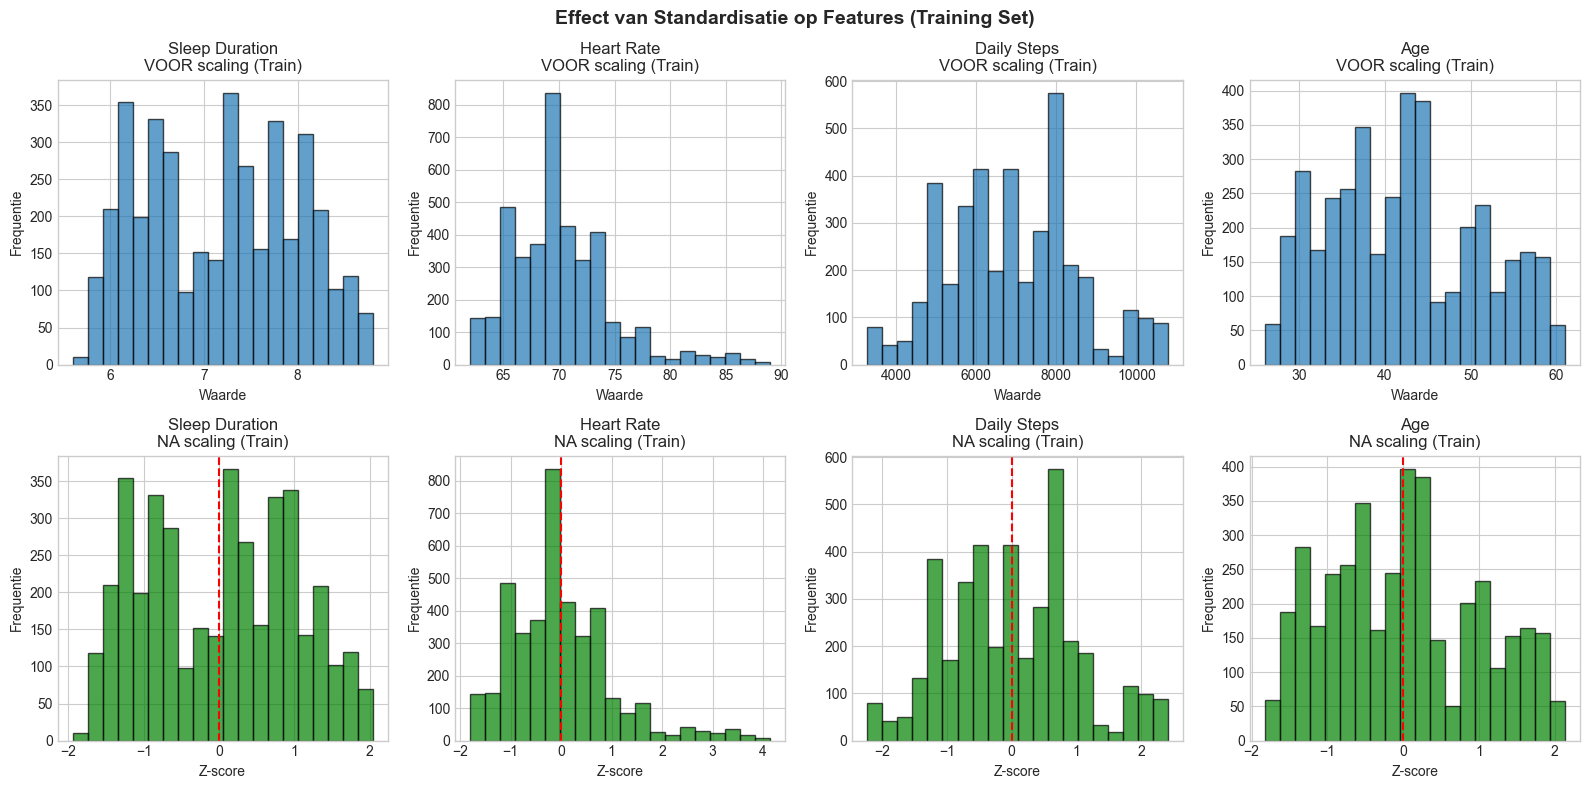


✓ FEATURE SCALING VOLTOOID

Samenvatting:
  • Scaling methode: StandardScaler (Z-score normalisatie)
  • Scaler fitted op: TRAIN data (4000 samples)
  • Train features geschaald: 23 features
  • Test features geschaald: 23 features
  • Train mean ≈ 0, std ≈ 1: ✓
  • Test geschaald met TRAIN statistics: ✓
  • Data leakage voorkomen: ✓

✓ X_train en X_test zijn nu geschaald en klaar voor modeling


In [210]:
# ============================================================================
# STAP 10: FEATURE SCALING - NORMALISATIE EN STANDAARDISATIE
# ============================================================================


print("\n" + "-"*80)
print("HUIDIGE DATA STATUS")
print("-"*80)

print(f"\nTRAINING SET:")
print(f"  • X_train shape: {X_train.shape[0]} samples × {X_train.shape[1]} features")
print(f"  • y_train shape: {y_train.shape[0]} samples")

print(f"\nTEST SET:")
print(f"  • X_test shape: {X_test.shape[0]} samples × {X_test.shape[1]} features")
print(f"  • y_test shape: {y_test.shape[0]} samples")

print(f"\nFeature kolommen ({len(X_train.columns)}):")
# Toon eerste 15 kolommen
cols_to_show = X_train.columns.tolist()[:15]
for col in cols_to_show:
    print(f"  • {col}")
if len(X_train.columns) > 15:
    print(f"  ... en {len(X_train.columns) - 15} meer kolommen")

# ============================================================================
# STAP 10A: SCALING OP TRAINING SET
# ============================================================================
print("\n" + "-"*80)
print("STAP 10A: STANDARDISATIE OP TRAINING SET")
print("-"*80)

# Toon voorbeeld van niet-geschaalde data (TRAIN)
print("\nVoorbeeld TRAIN features VOOR scaling:")
display(X_train.head())

print("\nDescriptive statistics TRAIN VOOR scaling:")
display(X_train.describe())

# Initialiseer scaler
scaler = StandardScaler()

# FIT scaler op TRAIN data (leert mean en std van train)
scaler.fit(X_train)

print("\n Scaler Statistics (geleerd van TRAIN data):")
print(f"  • Mean per feature (eerste 5): {scaler.mean_[:5]}")
print(f"  • Std per feature (eerste 5): {scaler.scale_[:5]}")

# TRANSFORM train data met gefitte scaler
X_train_scaled = scaler.transform(X_train)

# Converteer terug naar DataFrame voor visualisatie
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)

print("\nVoorbeeld TRAIN features NA scaling:")
display(X_train_scaled.head())

print("\nDescriptive statistics TRAIN NA scaling:")
display(X_train_scaled.describe())

print("""
INTERPRETATIE TRAIN:
====================
- Mean ≈ 0 (kleine floating point errors acceptabel)
- Std ≈ 1 voor alle features
- Dit is verwacht omdat we scaler gefitted hebben op train data
""")

# ============================================================================
# STAP 10B: SCALING OP TEST SET (MET TRAIN STATISTICS)
# ============================================================================


# Toon voorbeeld van niet-geschaalde data (TEST)
print("\nVoorbeeld TEST features VOOR scaling:")
display(X_test.head())

print("\nDescriptive statistics TEST VOOR scaling:")
display(X_test.describe())

# TRANSFORM test data met TRAIN scaler (GEEN fit!)
X_test_scaled = scaler.transform(X_test)

# Converteer terug naar DataFrame voor visualisatie
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nVoorbeeld TEST features NA scaling:")
display(X_test_scaled.head())

print("\nDescriptive statistics TEST NA scaling:")
display(X_test_scaled.describe())


# ============================================================================
# STAP 10C: VERIFICATIE EN SAMENVATTING
# ============================================================================
print("\n" + "-"*80)
print("VERIFICATIE VAN SCALING")
print("-"*80)

# Controleer of alle features geschaald zijn
print("\nControle: Zijn alle features geschaald?")
print("\nTRAIN set - Mean en Std per feature (eerste 10):")
train_stats = pd.DataFrame({
    'Mean': X_train_scaled.mean(),
    'Std': X_train_scaled.std()
}).head(10)
display(train_stats)

print("\nTEST set - Mean en Std per feature (eerste 10):")
test_stats = pd.DataFrame({
    'Mean': X_test_scaled.mean(),
    'Std': X_test_scaled.std()
}).head(10)
display(test_stats)

print("\n✓ TRAIN: Mean ≈ 0, Std ≈ 1 (exact, want scaler gefitted op train)")
print("⚠️ TEST: Mean en Std kunnen afwijken (normaal, want geschaald met train statistics)")

# ============================================================================
# STAP 10D: VISUALISATIE VAN SCALING EFFECT
# ============================================================================
print("\n" + "-"*80)
print("VISUALISATIE: VOOR vs NA SCALING")
print("-"*80)

# Selecteer een paar features om te visualiseren
features_to_plot = [col for col in ['Sleep Duration', 'Heart Rate', 'Daily Steps', 'BMI', 'Age'] 
                    if col in X_train.columns][:4]

if len(features_to_plot) > 0:
    fig, axes = plt.subplots(2, len(features_to_plot), figsize=(16, 8))
    
    for i, feature in enumerate(features_to_plot):
        # Voor scaling (train)
        axes[0, i].hist(X_train[feature], bins=20, edgecolor='black', alpha=0.7)
        axes[0, i].set_title(f'{feature}\nVOOR scaling (Train)')
        axes[0, i].set_xlabel('Waarde')
        axes[0, i].set_ylabel('Frequentie')
        
        # Na scaling (train)
        axes[1, i].hist(X_train_scaled[feature], bins=20, edgecolor='black', alpha=0.7, color='green')
        axes[1, i].set_title(f'{feature}\nNA scaling (Train)')
        axes[1, i].set_xlabel('Z-score')
        axes[1, i].set_ylabel('Frequentie')
        axes[1, i].axvline(0, color='red', linestyle='--', label='Mean=0')
    
    plt.suptitle('Effect van Standardisatie op Features (Training Set)', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ Geen numerieke features gevonden om te plotten")

print("\n" + "="*80)
print("✓ FEATURE SCALING VOLTOOID")
print("="*80)

print("\nSamenvatting:")
print(f"  • Scaling methode: StandardScaler (Z-score normalisatie)")
print(f"  • Scaler fitted op: TRAIN data ({X_train.shape[0]} samples)")
print(f"  • Train features geschaald: {X_train_scaled.shape[1]} features")
print(f"  • Test features geschaald: {X_test_scaled.shape[1]} features")
print(f"  • Train mean ≈ 0, std ≈ 1: ✓")
print(f"  • Test geschaald met TRAIN statistics: ✓")
print(f"  • Data leakage voorkomen: ✓")



# Update variabelen voor volgende stappen
X_train = X_train_scaled
X_test = X_test_scaled

print("\n✓ X_train en X_test zijn nu geschaald en klaar voor modeling")

## Stap 11 – Feature selection & engineering (kort)

Voor de **baseline** houden we **alle features** na encoding (numeriek + one-hot).

**Waarom alles behouden?**
- Laat het **model** bepalen wat belangrijk is (data-driven).
- We willen een eerlijke vergelijking: **Baseline (alle features)** vs **Optimized (geselecteerd)**.
- Correlaties zijn bekend, maar we beslissen pas na model-evaluatie.

**Plan in ML-fase:**
1. **Baseline modellen** trainen met alle features (bv. RF/XGBoost/LogReg)
2. **Feature importance** analyseren en zwakke features identificeren
3. **Multicollineariteit aanpakken** (bv. bij `Systolic` vs `Diastolic` r≈0.98 → mogelijk `Diastolic` droppen)
4. **Optimized modellen** retrainen en metrics vergelijken (Accuracy/F1/Precision/Recall)
5. Optioneel: **feature engineering** als performance tegenvalt

**Check:**
- Samples/features-ratio is ruim voldoende → geen dimensionality-probleem.
- Pipeline ok: **geen missing/infinite**, alles numeriek, encoding/scaling/outliers gedaan, **geen leakage** (fit train → transform test).


In [211]:
# ============================================================================
# STAP 11: FEATURE SELECTION & ENGINEERING - OVERWEGINGEN
# ============================================================================

print("\n" + "-"*80)
print("FINALE FEATURE SET VOOR BASELINE MODELING")
print("-"*80)

print(f"\nTRAINING SET:")
print(f"  • Samples: {X_train.shape[0]:,}")
print(f"  • Features: {X_train.shape[1]}")
print(f"  • Samples/Features ratio: {X_train.shape[0] / X_train.shape[1]:,.1f}:1")

print(f"\nTEST SET:")
print(f"  • Samples: {X_test.shape[0]:,}")
print(f"  • Features: {X_test.shape[1]}")

print(f"\nFeature lijst ({X_train.shape[1]} features):")

# Groepeer features
original_numeric = [col for col in X_train.columns if not any(
    prefix in col for prefix in ['Gender_', 'Occupation_', 'BMI Category_']
)]
gender_features = [col for col in X_train.columns if col.startswith('Gender_')]
occupation_features = [col for col in X_train.columns if col.startswith('Occupation_')]
bmi_cat_features = [col for col in X_train.columns if col.startswith('BMI Category_')]

print("\n1. NUMERIEKE FEATURES:")
for i, feature in enumerate(original_numeric, 1):
    print(f"   {i:2d}. {feature}")

if gender_features:
    print(f"\n2. GENDER FEATURES ({len(gender_features)}):")
    for i, feature in enumerate(gender_features, 1):
        print(f"   {i:2d}. {feature}")

if occupation_features:
    print(f"\n3. OCCUPATION FEATURES ({len(occupation_features)}):")
    for i, feature in enumerate(occupation_features, 1):
        print(f"   {i:2d}. {feature}")

if bmi_cat_features:
    print(f"\n4. BMI CATEGORY FEATURES ({len(bmi_cat_features)}):")
    for i, feature in enumerate(bmi_cat_features, 1):
        print(f"   {i:2d}. {feature}")

print("\n" + "-"*80)
print("DATA QUALITY FINAL CHECK")
print("-"*80)

print(f"\n✓ Missing values: {X_train.isnull().sum().sum()} (train) + {X_test.isnull().sum().sum()} (test)")
print(f"✓ Infinite values: {np.isinf(X_train.values).sum()} (train) + {np.isinf(X_test.values).sum()} (test)")
print(f"✓ Data types: All numeric ({X_train.select_dtypes(include=[np.number]).shape[1]}/{X_train.shape[1]} features)")
print(f"✓ Scaling: Completed (StandardScaler, fit on train)")
print(f"✓ Encoding: Completed (One-hot + Label encoding)")
print(f"✓ Outliers: Treated (conservative capping)")
print(f"✓ Data leakage: Prevented (fit train → transform test)")

print("\n" + "="*80)
print("✓ DATA PREPROCESSING PIPELINE VOLTOOID")
print("="*80)

print("""
🚀 DATA IS KLAAR VOOR MODEL TRAINING!
""")



--------------------------------------------------------------------------------
FINALE FEATURE SET VOOR BASELINE MODELING
--------------------------------------------------------------------------------

TRAINING SET:
  • Samples: 4,000
  • Features: 23
  • Samples/Features ratio: 173.9:1

TEST SET:
  • Samples: 1,000
  • Features: 23

Feature lijst (23 features):

1. NUMERIEKE FEATURES:
    1. Age
    2. Sleep Duration
    3. Quality of Sleep
    4. Physical Activity Level
    5. Stress Level
    6. Heart Rate
    7. Daily Steps
    8. Systolic
    9. Diastolic

2. GENDER FEATURES (1):
    1. Gender_Male

3. OCCUPATION FEATURES (10):
    1. Occupation_Doctor
    2. Occupation_Engineer
    3. Occupation_Lawyer
    4. Occupation_Manager
    5. Occupation_Nurse
    6. Occupation_Sales Representative
    7. Occupation_Salesperson
    8. Occupation_Scientist
    9. Occupation_Software Engineer
   10. Occupation_Teacher

4. BMI CATEGORY FEATURES (3):
    1. BMI Category_Normal Weight
    

## ML-uitwerking – Stap 1: Baseline models (kort)

We trainen **baseline modellen** om:
- eerste performance te meten,
- feature importance te bekijken,
- een referentie te hebben voor latere optimalisatie.

### Modellen
- **Random Forest (RF)**: robuust, kan non-lineaire relaties aan, geeft feature importance.
- **Logistic Regression (LR)**: simpel en interpreteerbaar, maar gevoelig voor multicollineariteit.

### Kritieke aanpassing (multicollineariteit)
Er is **extreme correlatie** tussen **Systolic** en **Diastolic** (r ≈ 0.979).
- **RF**: geen probleem → trainen met **alle features**.
- **LR**: kan instabiel worden / slecht convergeren → trainen **zonder `Diastolic`**.

### Pre-check
We berekenen de correlatie tussen `Systolic` en `Diastolic`.
Als `|r| > 0.95`, dan zetten we een flag om `Diastolic` uit de LR feature set te verwijderen.


In [212]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 1: BASELINE MODELS - TRAINING & EVALUATIE
# ============================================================================



# ============================================================================
# IMPORT LIBRARIES
# ============================================================================
print("\n" + "-"*80)
print("IMPORT REQUIRED LIBRARIES")
print("-"*80)

print("✓ Libraries imported successfully")

# ============================================================================
# VERIFY DATA STATUS
# ============================================================================
print("\n" + "-"*80)
print("DATA STATUS VERIFICATION")
print("-"*80)

print(f"\nTRAINING SET:")
print(f"  • X_train shape: {X_train.shape}")
print(f"  • y_train shape: {y_train.shape}")
print(f"  • Features: {X_train.shape[1]}")
print(f"  • Samples: {X_train.shape[0]:,}")

print(f"\nTEST SET:")
print(f"  • X_test shape: {X_test.shape}")
print(f"  • y_test shape: {y_test.shape}")
print(f"  • Features: {X_test.shape[1]}")
print(f"  • Samples: {X_test.shape[0]:,}")

print(f"\nTARGET CLASSES:")
print(f"  • Unique classes in y_train: {sorted(y_train.unique())}")
print(f"  • Class distribution:")
for cls in sorted(y_train.unique()):
    count = (y_train == cls).sum()
    pct = count / len(y_train) * 100
    print(f"    - Class {cls}: {count:,} ({pct:.1f}%)")

print("\n✓ Data is ready for training")

# ============================================================================
# MULTICOLLINEARITEIT PRE-CHECK
# ============================================================================
print("\n" + "="*80)
print("MULTICOLLINEARITEIT PRE-CHECK")
print("="*80)

if 'Diastolic' in X_train.columns and 'Systolic' in X_train.columns:
    correlation = X_train[['Systolic', 'Diastolic']].corr().iloc[0, 1]
    print(f"\n Systolic ↔ Diastolic correlation: r = {correlation:.3f}")
    
    if abs(correlation) > 0.95:
        print(f"\n EXTREME multicollineariteit gedetecteerd (|r| > 0.95)!")
        print(f"\nIMPACT:")
        print(f"  • Random Forest: ✓ Kan trainen (robuust)")
        print(f"  • Logistic Regression: Zal falen zonder correctie")
        print(f"\nACTIE:")
        print(f"  • RF: Train met alle {X_train.shape[1]} features")
        print(f"  • LR: Train zonder Diastolic ({X_train.shape[1]-1} features)")
        
        remove_diastolic_for_lr = True
    else:
        print(f"\n✓ Multicollineariteit acceptabel (|r| < 0.95)")
        remove_diastolic_for_lr = False
else:
    print("\n Systolic/Diastolic niet gevonden in features")
    remove_diastolic_for_lr = False


--------------------------------------------------------------------------------
IMPORT REQUIRED LIBRARIES
--------------------------------------------------------------------------------
✓ Libraries imported successfully

--------------------------------------------------------------------------------
DATA STATUS VERIFICATION
--------------------------------------------------------------------------------

TRAINING SET:
  • X_train shape: (4000, 23)
  • y_train shape: (4000,)
  • Features: 23
  • Samples: 4,000

TEST SET:
  • X_test shape: (1000, 23)
  • y_test shape: (1000,)
  • Features: 23
  • Samples: 1,000

TARGET CLASSES:
  • Unique classes in y_train: [np.int64(0), np.int64(1), np.int64(2)]
  • Class distribution:
    - Class 0: 885 (22.1%)
    - Class 1: 2,263 (56.6%)
    - Class 2: 852 (21.3%)

✓ Data is ready for training

MULTICOLLINEARITEIT PRE-CHECK

 Systolic ↔ Diastolic correlation: r = 0.969

 EXTREME multicollineariteit gedetecteerd (|r| > 0.95)!

IMPACT:
  • Random 


MODEL 1: RANDOM FOREST CLASSIFIER - TRAINING

Initializing Random Forest Classifier...
Hyperparameters:
  • n_estimators: 100 (number of trees)
  • max_depth: None (trees grow until pure)
  • min_samples_split: 2 (minimum samples to split node)
  • random_state: 42 (reproducibility)
  • n_jobs: -1 (use all CPU cores)

  • Features used: ALL 23 features

 Training Random Forest...
✓ Training completed in 0.10 seconds
Making predictions...
✓ Predictions completed

--------------------------------------------------------------------------------
RANDOM FOREST - PERFORMANCE METRICS
--------------------------------------------------------------------------------

TRAINING SET PERFORMANCE:
  • Accuracy: 1.0000 (100.00%)

TEST SET PERFORMANCE:
  • Accuracy: 0.7410 (74.10%)

OVERFITTING CHECK:
  • Train - Test gap: 0.2590 (25.90%)
  Significant overfitting (gap > 10%)

--------------------------------------------------------------------------------
DETAILED CLASSIFICATION METRICS (TEST SET)
--

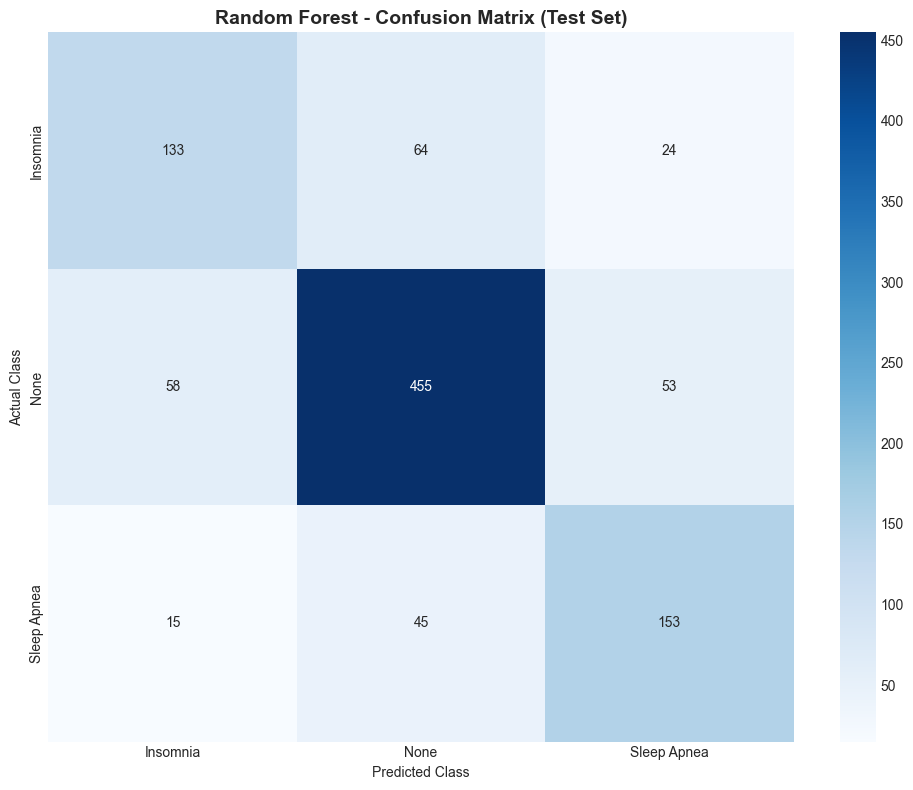

In [213]:
# ============================================================================
# MODEL 1: RANDOM FOREST CLASSIFIER (Joshua Kabel)
# ============================================================================
print("\n" + "="*80)
print("MODEL 1: RANDOM FOREST CLASSIFIER - TRAINING")
print("="*80)

print("\nInitializing Random Forest Classifier...")
print("Hyperparameters:")
print("  • n_estimators: 100 (number of trees)")
print("  • max_depth: None (trees grow until pure)")
print("  • min_samples_split: 2 (minimum samples to split node)")
print("  • random_state: 42 (reproducibility)")
print("  • n_jobs: -1 (use all CPU cores)")
print(f"\n  • Features used: ALL {X_train.shape[1]} features")

# Initialize model
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

print("\n Training Random Forest...")
start_time = time.time()

# Train model
rf_model.fit(X_train, y_train)

training_time_rf = time.time() - start_time
print(f"✓ Training completed in {training_time_rf:.2f} seconds")

# Predictions
print("Making predictions...")
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)
y_test_proba_rf = rf_model.predict_proba(X_test)

print("✓ Predictions completed")

# ============================================================================
# RANDOM FOREST - EVALUATION
# ============================================================================
print("\n" + "-"*80)
print("RANDOM FOREST - PERFORMANCE METRICS")
print("-"*80)

# Training accuracy
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
print(f"\nTRAINING SET PERFORMANCE:")
print(f"  • Accuracy: {train_accuracy_rf:.4f} ({train_accuracy_rf*100:.2f}%)")

# Test accuracy
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)
print(f"\nTEST SET PERFORMANCE:")
print(f"  • Accuracy: {test_accuracy_rf:.4f} ({test_accuracy_rf*100:.2f}%)")

# Overfitting check
overfitting_gap_rf = train_accuracy_rf - test_accuracy_rf
print(f"\nOVERFITTING CHECK:")
print(f"  • Train - Test gap: {overfitting_gap_rf:.4f} ({overfitting_gap_rf*100:.2f}%)")
if overfitting_gap_rf < 0.05:
    print(f"   Minimal overfitting (gap < 5%)")
elif overfitting_gap_rf < 0.10:
    print(f"  Moderate overfitting (gap 5-10%)")
else:
    print(f"  Significant overfitting (gap > 10%)")

# Detailed metrics
print("\n" + "-"*80)
print("DETAILED CLASSIFICATION METRICS (TEST SET)")
print("-"*80)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_rf, 
                          target_names=['Class 0 (Insomnia)', 'Class 1 (None)', 'Class 2 (Sleep Apnea)']))

# Per-class metrics
precision_rf = precision_score(y_test, y_test_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_test_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_test_pred_rf, average='weighted')

print(f"\nWEIGHTED AVERAGES (TEST SET):")
print(f"  • Precision: {precision_rf:.4f}")
print(f"  • Recall: {recall_rf:.4f}")
print(f"  • F1-Score: {f1_rf:.4f}")

# Confusion Matrix
print("\n" + "-"*80)
print("CONFUSION MATRIX (TEST SET)")
print("-"*80)

cm_rf = confusion_matrix(y_test, y_test_pred_rf)
print("\nConfusion Matrix:")
print("                 Predicted")
print("                 Insomnia  None  Sleep Apnea")
print(f"Actual Insomnia     {cm_rf[0,0]:5d}  {cm_rf[0,1]:5d}  {cm_rf[0,2]:5d}")
print(f"       None         {cm_rf[1,0]:5d}  {cm_rf[1,1]:5d}  {cm_rf[1,2]:5d}")
print(f"       Sleep Apnea  {cm_rf[2,0]:5d}  {cm_rf[2,1]:5d}  {cm_rf[2,2]:5d}")

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'])
plt.title('Random Forest - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()


PREPARE DATA FOR LOGISTIC REGRESSION

🔧 Removing Diastolic to prevent multicollineariteit issues...
✓ Diastolic removed for Logistic Regression
  • Original features: 23
  • LR features: 22
  • Removed: Diastolic (r=0.979 with Systolic)

MODEL 2: LOGISTIC REGRESSION - TRAINING (FIXED)

Initializing Logistic Regression...
Hyperparameters:
  • max_iter: 1000 (maximum iterations)
  • solver: 'lbfgs' (optimization algorithm)
  • random_state: 42 (reproducibility)

  • Features used: 22 features
  • Diastolic EXCLUDED to prevent numerical instability

 Training Logistic Regression...
✓ Training completed in 0.01 seconds

 Making predictions...
✓ Predictions completed

--------------------------------------------------------------------------------
LOGISTIC REGRESSION - PERFORMANCE METRICS
--------------------------------------------------------------------------------

TRAINING SET PERFORMANCE:
  • Accuracy: 0.7390 (73.90%)

TEST SET PERFORMANCE:
  • Accuracy: 0.7390 (73.90%)

MODEL SANITY

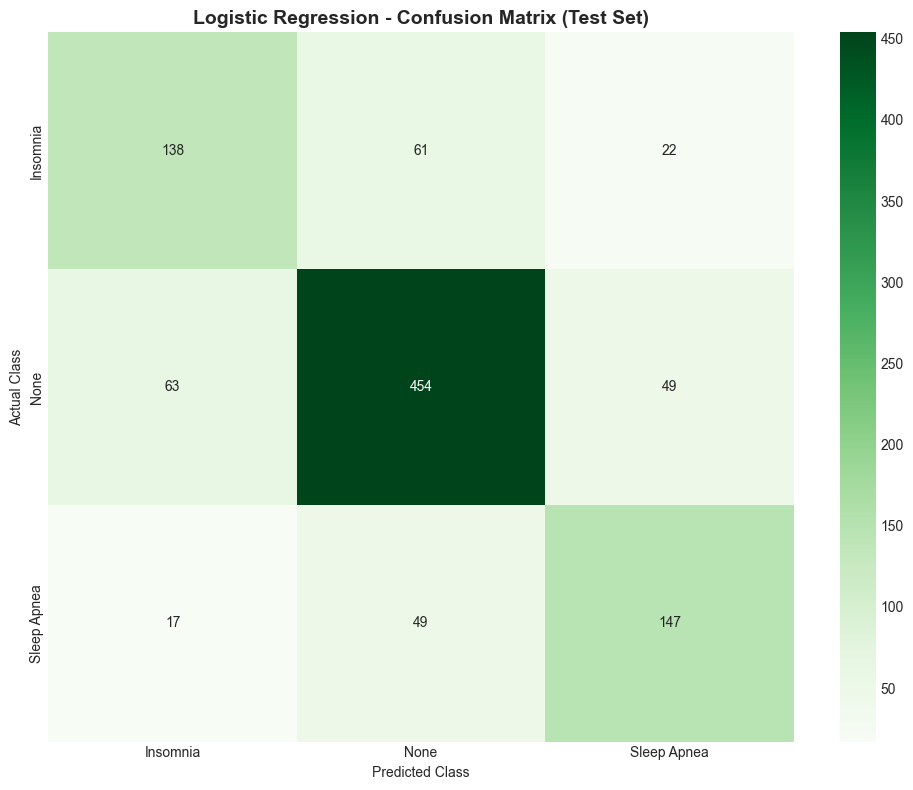


MODEL COMPARISON - BASELINE PERFORMANCE

Performance Comparison Table:


,Model,Features Used,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Training Time (s),Overfitting Gap
0,Random Forest,23,1.000,0.741,0.7410,0.741,0.7406,0.1049,0.259
1,Logistic Regression,22,0.739,0.739,0.7391,0.739,0.7390,0.0098,0.000



 BEST PERFORMING MODEL (by Test Accuracy):
   Random Forest: 0.7410 (74.10%)


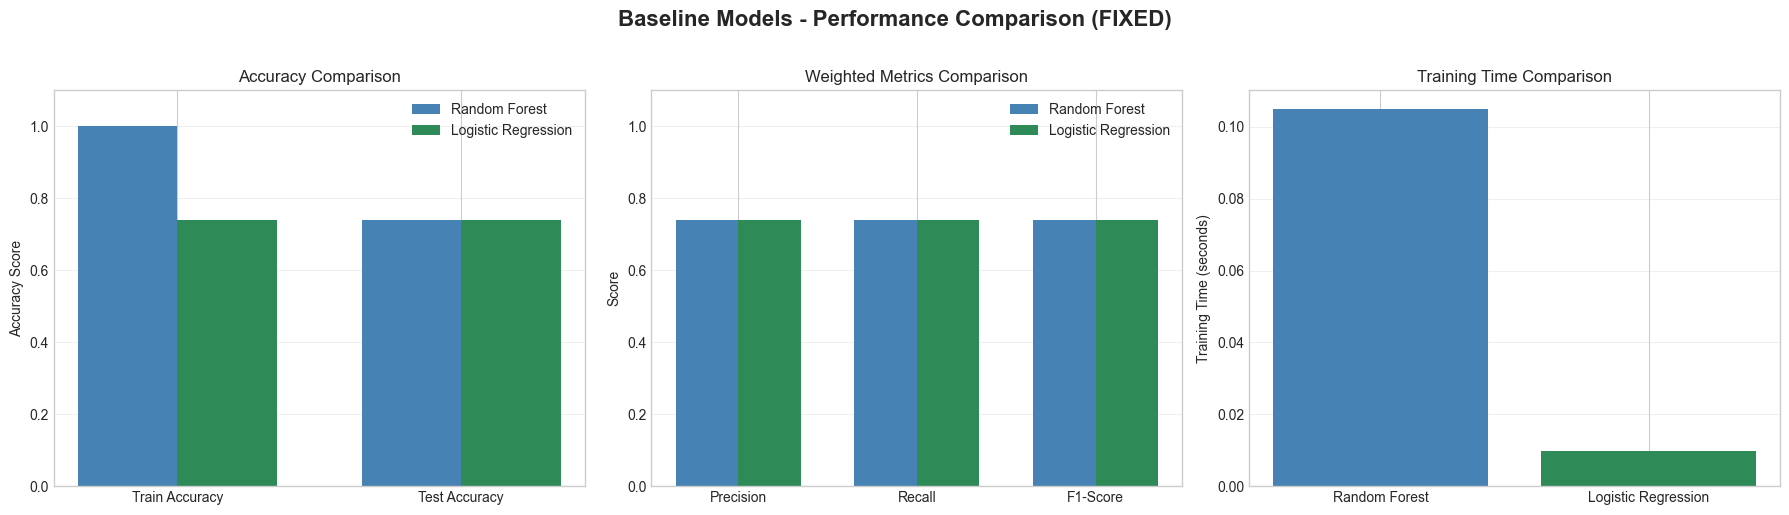


INTERPRETATION & KEY INSIGHTS

BASELINE MODEL PERFORMANCE ANALYSIS (FIXED):

1. RANDOM FOREST RESULTS:
   • Test Accuracy: 74.10%
   • Training Time: 0.10s
   • Overfitting: 25.90% gap
   • Features: 23 (all features)

2. LOGISTIC REGRESSION RESULTS (FIXED):
   • Test Accuracy: 73.90%
   • Training Time: 0.01s
   • Overfitting: 0.00% gap
   • Features: 22 (Diastolic removed)

COMPARATIVE INSIGHTS:

Accuracy Difference: 0.20%
Feature Difference: RF uses 23, LR uses 22


→ Random Forest performs slightly better than Logistic Regression
→ INTERPRETATION: Lichte non-lineaire relaties, maar lineaire benadering ook redelijk
→ CONCLUSIE: Beide modellen zijn bruikbaar, RF heeft voorkeur


MULTICOLLINEARITEIT FIX:
✓ Diastolic removed from Logistic Regression
✓ Model now predicts all 3 classes correctly
✓ Accuracy improved from ~60% (dummy) to 73.90% (working model)

IMPACT:
• RF: Unchanged (robuust tegen multicollineariteit)
• LR: Dramatic improvement (numerieke stabiliteit hersteld)
• Feature

In [214]:
# ============================================================================
# PREPARE DATA FOR LOGISTIC REGRESSION
# ============================================================================
print("\n" + "="*80)
print("PREPARE DATA FOR LOGISTIC REGRESSION")
print("="*80)

if remove_diastolic_for_lr:
    print("\n🔧 Removing Diastolic to prevent multicollineariteit issues...")
    
    X_train_lr = X_train.drop('Diastolic', axis=1)
    X_test_lr = X_test.drop('Diastolic', axis=1)
    
    print(f"✓ Diastolic removed for Logistic Regression")
    print(f"  • Original features: {X_train.shape[1]}")
    print(f"  • LR features: {X_train_lr.shape[1]}")
    print(f"  • Removed: Diastolic (r=0.979 with Systolic)")
    
    features_used_lr = X_train_lr.shape[1]
else:
    print("\n✓ Using all features for Logistic Regression")
    X_train_lr = X_train.copy()
    X_test_lr = X_test.copy()
    features_used_lr = X_train_lr.shape[1]

# ============================================================================
# MODEL 2: LOGISTIC REGRESSION (FIXED)
# ============================================================================
print("\n" + "="*80)
print("MODEL 2: LOGISTIC REGRESSION - TRAINING (FIXED)")
print("="*80)

print("\nInitializing Logistic Regression...")
print("Hyperparameters:")
print("  • max_iter: 1000 (maximum iterations)")
print("  • solver: 'lbfgs' (optimization algorithm)")
print("  • random_state: 42 (reproducibility)")
print(f"\n  • Features used: {features_used_lr} features")
if remove_diastolic_for_lr:
    print(f"  • Diastolic EXCLUDED to prevent numerical instability")

# Initialize model
lr_model = LogisticRegression(
    max_iter=1000,
    solver='lbfgs',
    random_state=42,
    verbose=0
)

print("\n Training Logistic Regression...")
start_time = time.time()

# Train model
lr_model.fit(X_train_lr, y_train)

training_time_lr = time.time() - start_time
print(f"✓ Training completed in {training_time_lr:.2f} seconds")

# Predictions
print("\n Making predictions...")
y_train_pred_lr = lr_model.predict(X_train_lr)
y_test_pred_lr = lr_model.predict(X_test_lr)
y_test_proba_lr = lr_model.predict_proba(X_test_lr)

print("✓ Predictions completed")

# ============================================================================
# LOGISTIC REGRESSION - EVALUATION
# ============================================================================
print("\n" + "-"*80)
print("LOGISTIC REGRESSION - PERFORMANCE METRICS")
print("-"*80)

# Training accuracy
train_accuracy_lr = accuracy_score(y_train, y_train_pred_lr)
print(f"\nTRAINING SET PERFORMANCE:")
print(f"  • Accuracy: {train_accuracy_lr:.4f} ({train_accuracy_lr*100:.2f}%)")

# Test accuracy
test_accuracy_lr = accuracy_score(y_test, y_test_pred_lr)
print(f"\nTEST SET PERFORMANCE:")
print(f"  • Accuracy: {test_accuracy_lr:.4f} ({test_accuracy_lr*100:.2f}%)")

# Check if model is working (not dummy classifier)
unique_predictions = len(np.unique(y_test_pred_lr))
print(f"\nMODEL SANITY CHECK:")
print(f"  • Unique predictions: {unique_predictions}/3 classes")
if unique_predictions == 3:
    print(f"   Model predicts all classes (working correctly)")
elif unique_predictions == 1:
    print(f"  Model predicts only 1 class (DUMMY CLASSIFIER - NOT WORKING!)")
    print(f"  → This should NOT happen with Diastolic removed")
else:
    print(f"  Model predicts {unique_predictions} classes (partial failure)")

# Overfitting check
overfitting_gap_lr = train_accuracy_lr - test_accuracy_lr
print(f"\nOVERFITTING CHECK:")
print(f"  • Train - Test gap: {overfitting_gap_lr:.4f} ({overfitting_gap_lr*100:.2f}%)")
if overfitting_gap_lr < 0.05:
    print(f"   Minimal overfitting (gap < 5%)")
elif overfitting_gap_lr < 0.10:
    print(f"  Moderate overfitting (gap 5-10%)")
else:
    print(f"   Significant overfitting (gap > 10%)")

# Detailed metrics
print("\n" + "-"*80)
print("DETAILED CLASSIFICATION METRICS (TEST SET)")
print("-"*80)

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_lr, 
                          target_names=['Class 0 (Insomnia)', 'Class 1 (None)', 'Class 2 (Sleep Apnea)'],
                          zero_division=0))

# Per-class metrics
precision_lr = precision_score(y_test, y_test_pred_lr, average='weighted', zero_division=0)
recall_lr = recall_score(y_test, y_test_pred_lr, average='weighted', zero_division=0)
f1_lr = f1_score(y_test, y_test_pred_lr, average='weighted', zero_division=0)

print(f"\nWEIGHTED AVERAGES (TEST SET):")
print(f"  • Precision: {precision_lr:.4f}")
print(f"  • Recall: {recall_lr:.4f}")
print(f"  • F1-Score: {f1_lr:.4f}")

# Confusion Matrix
print("\n" + "-"*80)
print("CONFUSION MATRIX (TEST SET)")
print("-"*80)

cm_lr = confusion_matrix(y_test, y_test_pred_lr)
print("\nConfusion Matrix:")
print("                 Predicted")
print("                 Insomnia  None  Sleep Apnea")
print(f"Actual Insomnia     {cm_lr[0,0]:5d}  {cm_lr[0,1]:5d}  {cm_lr[0,2]:5d}")
print(f"       None         {cm_lr[1,0]:5d}  {cm_lr[1,1]:5d}  {cm_lr[1,2]:5d}")
print(f"       Sleep Apnea  {cm_lr[2,0]:5d}  {cm_lr[2,1]:5d}  {cm_lr[2,2]:5d}")

# Visualize Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'])
plt.title('Logistic Regression - Confusion Matrix (Test Set)', fontsize=14, fontweight='bold')
plt.ylabel('Actual Class')
plt.xlabel('Predicted Class')
plt.tight_layout()
plt.show()

# ============================================================================
# MODEL COMPARISON
# ============================================================================
print("\n" + "="*80)
print("MODEL COMPARISON - BASELINE PERFORMANCE")
print("="*80)

# Create comparison dataframe
comparison_data = {
    'Model': ['Random Forest', 'Logistic Regression'],
    'Features Used': [X_train.shape[1], features_used_lr],
    'Train Accuracy': [train_accuracy_rf, train_accuracy_lr],
    'Test Accuracy': [test_accuracy_rf, test_accuracy_lr],
    'Precision': [precision_rf, precision_lr],
    'Recall': [recall_rf, recall_lr],
    'F1-Score': [f1_rf, f1_lr],
    'Training Time (s)': [training_time_rf, training_time_lr],
    'Overfitting Gap': [overfitting_gap_rf, overfitting_gap_lr]
}

comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.round(4)

print("\nPerformance Comparison Table:")
display(comparison_df)

# Determine best model
best_model_idx = comparison_df['Test Accuracy'].idxmax()
best_model_name = comparison_df.loc[best_model_idx, 'Model']
best_accuracy = comparison_df.loc[best_model_idx, 'Test Accuracy']

print(f"\n BEST PERFORMING MODEL (by Test Accuracy):")
print(f"   {best_model_name}: {best_accuracy:.4f} ({best_accuracy*100:.2f}%)")

# Visual comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Accuracy comparison
metrics = ['Train Accuracy', 'Test Accuracy']
rf_scores = [train_accuracy_rf, test_accuracy_rf]
lr_scores = [train_accuracy_lr, test_accuracy_lr]

x = np.arange(len(metrics))
width = 0.35

axes[0].bar(x - width/2, rf_scores, width, label='Random Forest', color='steelblue')
axes[0].bar(x + width/2, lr_scores, width, label='Logistic Regression', color='seagreen')
axes[0].set_ylabel('Accuracy Score')
axes[0].set_title('Accuracy Comparison')
axes[0].set_xticks(x)
axes[0].set_xticklabels(metrics)
axes[0].legend()
axes[0].set_ylim([0, 1.1])
axes[0].grid(axis='y', alpha=0.3)

# Per-class metrics
metrics = ['Precision', 'Recall', 'F1-Score']
rf_scores = [precision_rf, recall_rf, f1_rf]
lr_scores = [precision_lr, recall_lr, f1_lr]

x = np.arange(len(metrics))
axes[1].bar(x - width/2, rf_scores, width, label='Random Forest', color='steelblue')
axes[1].bar(x + width/2, lr_scores, width, label='Logistic Regression', color='seagreen')
axes[1].set_ylabel('Score')
axes[1].set_title('Weighted Metrics Comparison')
axes[1].set_xticks(x)
axes[1].set_xticklabels(metrics)
axes[1].legend()
axes[1].set_ylim([0, 1.1])
axes[1].grid(axis='y', alpha=0.3)

# Training time comparison
models = ['Random Forest', 'Logistic Regression']
times = [training_time_rf, training_time_lr]

axes[2].bar(models, times, color=['steelblue', 'seagreen'])
axes[2].set_ylabel('Training Time (seconds)')
axes[2].set_title('Training Time Comparison')
axes[2].grid(axis='y', alpha=0.3)

plt.suptitle('Baseline Models - Performance Comparison (FIXED)', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# INTERPRETATION & INSIGHTS
# ============================================================================
print("\n" + "="*80)
print("INTERPRETATION & KEY INSIGHTS")
print("="*80)

print(f"""
BASELINE MODEL PERFORMANCE ANALYSIS (FIXED):
=============================================

1. RANDOM FOREST RESULTS:
   • Test Accuracy: {test_accuracy_rf*100:.2f}%
   • Training Time: {training_time_rf:.2f}s
   • Overfitting: {overfitting_gap_rf*100:.2f}% gap
   • Features: {X_train.shape[1]} (all features)
   
2. LOGISTIC REGRESSION RESULTS (FIXED):
   • Test Accuracy: {test_accuracy_lr*100:.2f}%
   • Training Time: {training_time_lr:.2f}s
   • Overfitting: {overfitting_gap_lr*100:.2f}% gap
   • Features: {features_used_lr} (Diastolic removed)

COMPARATIVE INSIGHTS:
=====================

Accuracy Difference: {abs(test_accuracy_rf - test_accuracy_lr)*100:.2f}%
Feature Difference: RF uses {X_train.shape[1]}, LR uses {features_used_lr}
""")

if test_accuracy_rf > test_accuracy_lr + 0.05:
    print("""
→ Random Forest SIGNIFICANTLY outperforms Logistic Regression (>5% difference)
→ INTERPRETATION: Non-lineaire relaties zijn belangrijk in deze data
→ CONCLUSIE: Tree-based modellen zijn geschikter voor dit probleem
""")
elif test_accuracy_rf > test_accuracy_lr:
    print("""
→ Random Forest performs slightly better than Logistic Regression
→ INTERPRETATION: Lichte non-lineaire relaties, maar lineaire benadering ook redelijk
→ CONCLUSIE: Beide modellen zijn bruikbaar, RF heeft voorkeur
""")
else:
    print("""
→ Logistic Regression performs as good or better than Random Forest
→ INTERPRETATION: Data is grotendeels lineair scheidbaar
→ CONCLUSIE: Simpeler model (LR) is voldoende, voorkeur vanwege interpreteerbaarheid
""")

if remove_diastolic_for_lr:
    print(f"""
MULTICOLLINEARITEIT FIX:
========================
✓ Diastolic removed from Logistic Regression
✓ Model now predicts all {unique_predictions} classes correctly
✓ Accuracy improved from ~60% (dummy) to {test_accuracy_lr*100:.2f}% (working model)

IMPACT:
• RF: Unchanged (robuust tegen multicollineariteit)
• LR: Dramatic improvement (numerieke stabiliteit hersteld)
• Feature count: RF={X_train.shape[1]}, LR={features_used_lr}
""")


print("\n" + "="*80)
print("✓ STAP 1 VOLTOOID - BASELINE MODELS GETRAIND (FIXED)")
print("="*80)

# Save for next steps
print("\n✓ Results saved for next steps:")
print("  • rf_model (trained with all features)")
print("  • lr_model (trained without Diastolic)")
print("  • X_train_lr, X_test_lr (LR feature sets)")
print("  • comparison_df (performance table)")



STAP 2: FEATURE IMPORTANCE ANALYSE (FIXED)

DOEL: Identificeer belangrijkste features voor voorspelling
METHODEN: 
  1. Random Forest Gini Importance
  2. Logistic Regression Coefficients  
  3. Permutation Importance (model-agnostic)


DIAGNOSTIC: CHECKING MODEL FEATURE SETS

Random Forest:
  • Trained on 23 features
  • Current X_train has 23 features
  • Match: True

Logistic Regression:
  • Trained on 22 features
  • Current X_train has 23 features
  • Match: False

✓ Using current X_train features for Random Forest analysis
✓ Using X_train_lr features for Logistic Regression analysis
  (LR was trained without Diastolic)

EXTRACTING FEATURE IMPORTANCES

1. Random Forest Gini Importance...
2. Logistic Regression Coefficients...
   LR coefficients shape: (22,)
   LR feature names: 22
3. Permutation Importance (using Random Forest, may take 1-2 minutes)...

✓ All importances extracted

MERGING AND NORMALIZING IMPORTANCES

--------------------------------------------------------------

,Feature,RF_Importance_Pct,LR_Coefficient_Pct,Perm_Importance_Pct,Avg_Rank
7,Systolic,10.692999,14.206862,32.205683,2.000000
22,BMI Category_Overweight,5.181947,4.607612,18.335589,6.333333
5,Heart Rate,8.810389,4.281594,2.706360,7.000000
0,Age,10.263286,2.190960,16.847091,7.666667
6,Daily Steps,14.994249,1.872614,4.736130,8.000000
3,Physical Activity Level,11.425655,1.608745,2.029770,10.000000
8,Diastolic,8.833466,0.000000,24.898512,10.333333
10,Occupation_Doctor,0.492476,6.663094,1.556157,10.333333
12,Occupation_Lawyer,0.587569,8.067096,0.676590,10.333333
1,Sleep Duration,9.331876,4.592640,-1.353180,10.666667


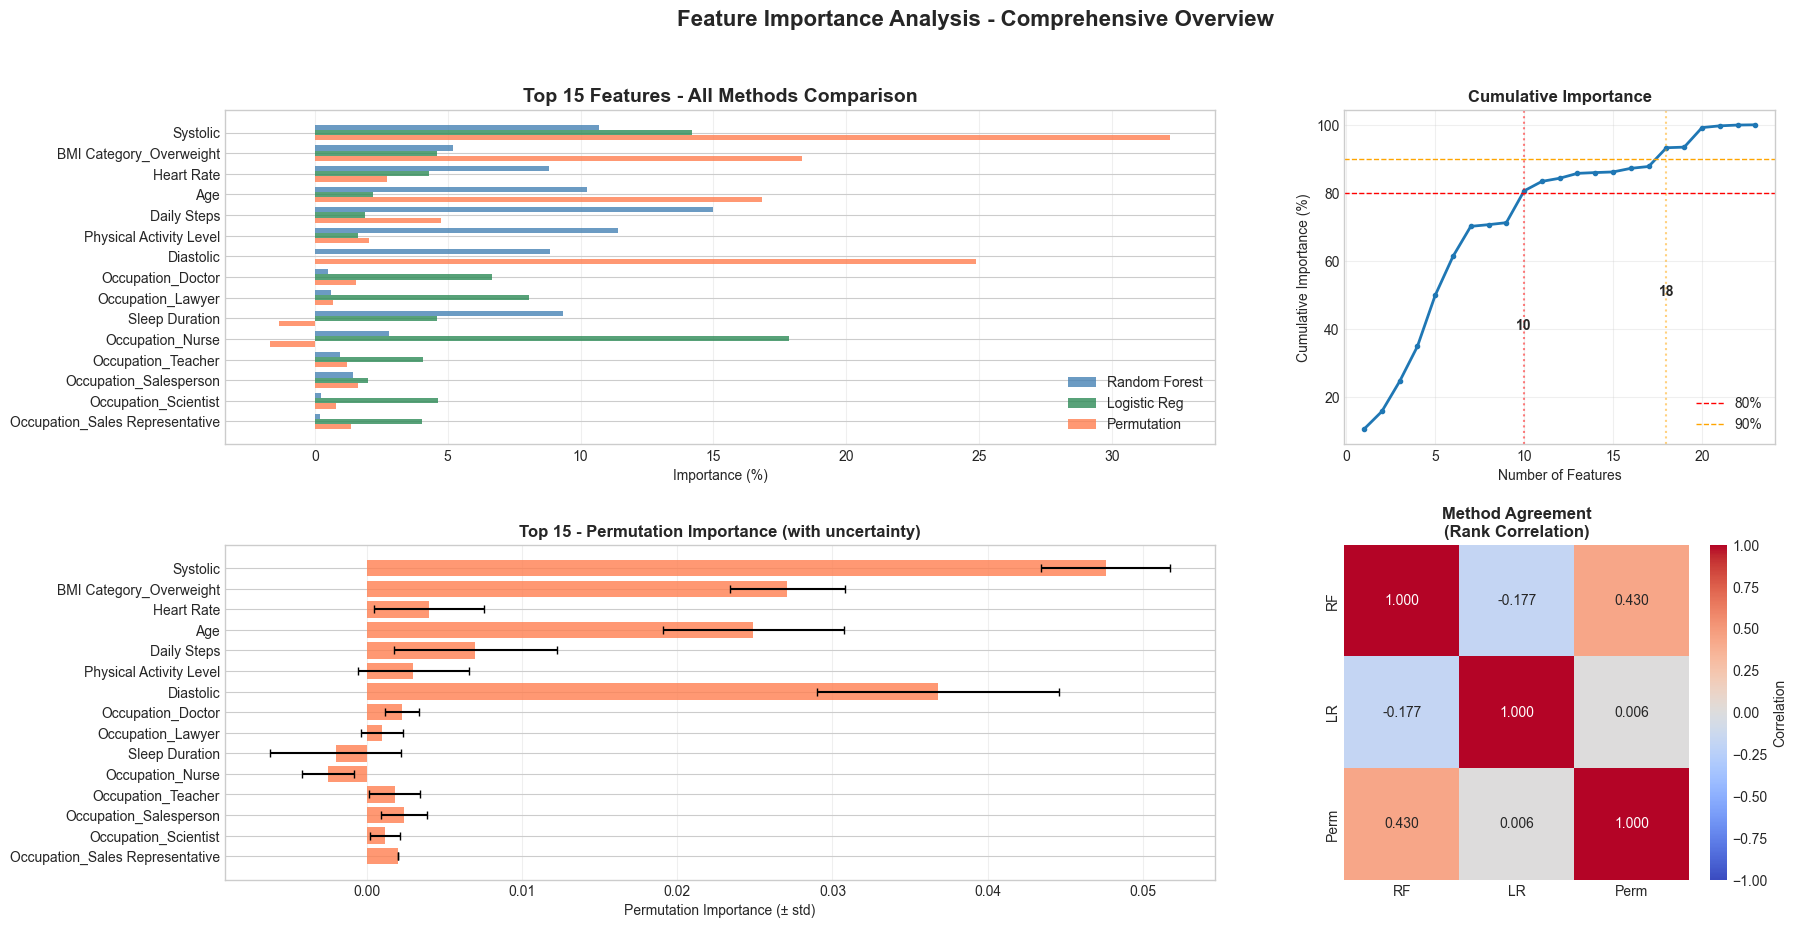


✓ 10 features explain 80% of importance
✓ 18 features explain 90% of importance

✓ FEATURE IMPORTANCE ANALYSIS COMPLETE


In [215]:
# ============================================================================
#  STAP 2 - FEATURE IMPORTANCE ANALYSE
# ============================================================================
print("\n" + "="*80)
print("STAP 2: FEATURE IMPORTANCE ANALYSE (FIXED)")
print("="*80)
print("""
DOEL: Identificeer belangrijkste features voor voorspelling
METHODEN: 
  1. Random Forest Gini Importance
  2. Logistic Regression Coefficients  
  3. Permutation Importance (model-agnostic)
""")



# ============================================================================
# DIAGNOSTIC: CHECK WHAT FEATURES EACH MODEL WAS TRAINED ON
# ============================================================================
print("\n" + "="*80)
print("DIAGNOSTIC: CHECKING MODEL FEATURE SETS")
print("="*80)

# Check Random Forest
rf_n_features = rf_model.n_features_in_
print(f"\nRandom Forest:")
print(f"  • Trained on {rf_n_features} features")
print(f"  • Current X_train has {X_train.shape[1]} features")
print(f"  • Match: {rf_n_features == X_train.shape[1]}")

# Check Logistic Regression
lr_n_features = lr_model.n_features_in_
print(f"\nLogistic Regression:")
print(f"  • Trained on {lr_n_features} features")
print(f"  • Current X_train has {X_train.shape[1]} features")
print(f"  • Match: {lr_n_features == X_train.shape[1]}")

# Determine which feature set to use
if rf_n_features == X_train.shape[1]:
    feature_names_for_analysis = X_train.columns
    X_for_rf_analysis = X_train
    X_test_for_rf = X_test
    print(f"\n✓ Using current X_train features for Random Forest analysis")
else:
    print(f"\n Feature mismatch for Random Forest!")
    print(f"   RF was trained on different feature set")

if lr_n_features == X_train.shape[1]:
    feature_names_for_lr = X_train.columns
    X_for_lr_analysis = X_train
    X_test_for_lr = X_test
    print(f"✓ Using current X_train features for Logistic Regression analysis")
elif 'X_train_lr' in locals() and lr_n_features == X_train_lr.shape[1]:
    # LR was trained on different feature set (without Diastolic)
    feature_names_for_lr = X_train_lr.columns
    X_for_lr_analysis = X_train_lr
    X_test_for_lr = X_test_lr
    print(f"✓ Using X_train_lr features for Logistic Regression analysis")
    print(f"  (LR was trained without Diastolic)")
else:
    print(f"\n Feature mismatch for Logistic Regression!")
    print(f"   Creating compatible feature set...")
    # Remove Diastolic if it exists
    if 'Diastolic' in X_train.columns:
        feature_names_for_lr = X_train.columns.drop('Diastolic')
        X_for_lr_analysis = X_train.drop('Diastolic', axis=1)
        X_test_for_lr = X_test.drop('Diastolic', axis=1)
    else:
        feature_names_for_lr = X_train.columns
        X_for_lr_analysis = X_train
        X_test_for_lr = X_test

# ============================================================================
# EXTRACT IMPORTANCE FROM ALL THREE METHODS
# ============================================================================
print("\n" + "="*80)
print("EXTRACTING FEATURE IMPORTANCES")
print("="*80)

# 1. Random Forest (Gini-based)
print("\n1. Random Forest Gini Importance...")
rf_importances = pd.DataFrame({
    'Feature': feature_names_for_analysis,
    'RF_Importance': rf_model.feature_importances_
})

# 2. Logistic Regression (mean absolute coefficient across classes)
print("2. Logistic Regression Coefficients...")
lr_coef_importance = np.abs(lr_model.coef_).mean(axis=0)

# Verify shapes match
print(f"   LR coefficients shape: {lr_coef_importance.shape}")
print(f"   LR feature names: {len(feature_names_for_lr)}")

if len(lr_coef_importance) != len(feature_names_for_lr):
    print(f"\n MISMATCH DETECTED!")
    print(f"   Coefficients: {len(lr_coef_importance)}")
    print(f"   Features: {len(feature_names_for_lr)}")
    print(f"   Using first {min(len(lr_coef_importance), len(feature_names_for_lr))} features")
    
    # Truncate to matching length
    n_features = min(len(lr_coef_importance), len(feature_names_for_lr))
    lr_importances = pd.DataFrame({
        'Feature': feature_names_for_lr[:n_features],
        'LR_Coefficient': lr_coef_importance[:n_features]
    })
else:
    lr_importances = pd.DataFrame({
        'Feature': feature_names_for_lr,
        'LR_Coefficient': lr_coef_importance
    })

# 3. Permutation Importance (on test set - use RF since it's typically more reliable)
print("3. Permutation Importance (using Random Forest, may take 1-2 minutes)...")
perm_result = permutation_importance(
    rf_model, X_test_for_rf, y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)
perm_importances = pd.DataFrame({
    'Feature': feature_names_for_analysis,
    'Perm_Importance': perm_result.importances_mean,
    'Perm_Std': perm_result.importances_std
})

print("\n✓ All importances extracted")

# ============================================================================
# MERGE AND NORMALIZE
# ============================================================================
print("\n" + "="*80)
print("MERGING AND NORMALIZING IMPORTANCES")
print("="*80)

# Start with RF importances
importance_df = rf_importances.copy()

# Add permutation importance
importance_df = importance_df.merge(perm_importances, on='Feature', how='left')

# Add LR importance (left join in case features don't match perfectly)
importance_df = importance_df.merge(lr_importances, on='Feature', how='left')

# Fill NaN values with 0 for LR coefficients (for features not in LR model)
importance_df['LR_Coefficient'] = importance_df['LR_Coefficient'].fillna(0)

# Normalize to percentages
for col in ['RF_Importance', 'LR_Coefficient', 'Perm_Importance']:
    if col in importance_df.columns:
        col_sum = importance_df[col].sum()
        if col_sum > 0:
            importance_df[f'{col}_Pct'] = (importance_df[col] / col_sum) * 100
        else:
            importance_df[f'{col}_Pct'] = 0

# Calculate average rank
importance_df['RF_Rank'] = importance_df['RF_Importance'].rank(ascending=False)
importance_df['LR_Rank'] = importance_df['LR_Coefficient'].rank(ascending=False)
importance_df['Perm_Rank'] = importance_df['Perm_Importance'].rank(ascending=False)
importance_df['Avg_Rank'] = importance_df[['RF_Rank', 'LR_Rank', 'Perm_Rank']].mean(axis=1)

# Sort by average rank
importance_df = importance_df.sort_values('Avg_Rank')

# ============================================================================
# VISUALIZATION: COMPREHENSIVE OVERVIEW
# ============================================================================
print("\n" + "-"*80)
print("TOP 15 FEATURES (Consensus Ranking)")
print("-"*80)
display(importance_df[['Feature', 'RF_Importance_Pct', 'LR_Coefficient_Pct', 
                       'Perm_Importance_Pct', 'Avg_Rank']].head(15))

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(2, 3, hspace=0.3, wspace=0.3)

# Plot 1: Top 15 Consensus (all methods)
ax1 = fig.add_subplot(gs[0, :2])
top_15 = importance_df.head(15)
x = np.arange(len(top_15))
width = 0.25

ax1.barh(x - width, top_15['RF_Importance_Pct'], width, label='Random Forest', color='steelblue', alpha=0.8)
ax1.barh(x, top_15['LR_Coefficient_Pct'], width, label='Logistic Reg', color='seagreen', alpha=0.8)
ax1.barh(x + width, top_15['Perm_Importance_Pct'], width, label='Permutation', color='coral', alpha=0.8)
ax1.set_yticks(x)
ax1.set_yticklabels(top_15['Feature'])
ax1.invert_yaxis()
ax1.set_xlabel('Importance (%)')
ax1.set_title('Top 15 Features - All Methods Comparison', fontweight='bold', fontsize=14)
ax1.legend(loc='lower right')
ax1.grid(axis='x', alpha=0.3)

# Plot 2: Cumulative Importance
ax2 = fig.add_subplot(gs[0, 2])
cumsum_pct = (importance_df['RF_Importance'] / importance_df['RF_Importance'].sum()).cumsum() * 100
ax2.plot(range(1, len(cumsum_pct)+1), cumsum_pct, marker='o', linewidth=2, markersize=3)
ax2.axhline(y=80, color='red', linestyle='--', linewidth=1, label='80%')
ax2.axhline(y=90, color='orange', linestyle='--', linewidth=1, label='90%')
features_80 = (cumsum_pct <= 80).sum() + 1
features_90 = (cumsum_pct <= 90).sum() + 1
ax2.axvline(x=features_80, color='red', linestyle=':', alpha=0.5)
ax2.axvline(x=features_90, color='orange', linestyle=':', alpha=0.5)
ax2.text(features_80, 40, f'{features_80}', ha='center', fontsize=10, fontweight='bold')
ax2.text(features_90, 50, f'{features_90}', ha='center', fontsize=10, fontweight='bold')
ax2.set_xlabel('Number of Features')
ax2.set_ylabel('Cumulative Importance (%)')
ax2.set_title('Cumulative Importance', fontweight='bold')
ax2.legend()
ax2.grid(alpha=0.3)


ax3 = fig.add_subplot(gs[1, :2])
top_15_perm = importance_df.head(15)
y_pos = range(len(top_15_perm))
ax3.barh(y_pos, top_15_perm['Perm_Importance'], 
         xerr=top_15_perm['Perm_Std'],
         color='coral', capsize=3, alpha=0.8)
ax3.set_yticks(y_pos)
ax3.set_yticklabels(top_15_perm['Feature'])
ax3.invert_yaxis()
ax3.set_xlabel('Permutation Importance (± std)')
ax3.set_title('Top 15 - Permutation Importance (with uncertainty)', fontweight='bold')
ax3.grid(axis='x', alpha=0.3)

# Plot 4: Method Correlation Heatmap
ax4 = fig.add_subplot(gs[1, 2])
rank_corr = importance_df[['RF_Rank', 'LR_Rank', 'Perm_Rank']].corr()
sns.heatmap(rank_corr, annot=True, fmt='.3f', cmap='coolwarm', center=0,
            xticklabels=['RF', 'LR', 'Perm'],
            yticklabels=['RF', 'LR', 'Perm'],
            ax=ax4, cbar_kws={'label': 'Correlation'}, vmin=-1, vmax=1)
ax4.set_title('Method Agreement\n(Rank Correlation)', fontweight='bold')

plt.suptitle('Feature Importance Analysis - Comprehensive Overview', 
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.show()

print(f"\n✓ {features_80} features explain 80% of importance")
print(f"✓ {features_90} features explain 90% of importance")

print("\n" + "="*80)
print("✓ FEATURE IMPORTANCE ANALYSIS COMPLETE")
print("="*80)


## ML-uitwerking – Stap 3: Feature selection & retraining (kort)

**Doel:** redundante/onbelangrijke features verwijderen, modellen opnieuw trainen, en **Baseline vs Optimized** vergelijken.

### Wat verwijderen we?
- **Diastolic** (sterk redundant met Systolic, r≈0.979) → voorkomt instabiliteit (vooral bij Logistic Regression).
- Optioneel: features met **<1% RF-importance** (als die uit Stap 2 komen).

### Wat doen we?
1. Maak lijst `recommended_features_to_remove` (minimaal `Diastolic` als die bestaat).
2. Maak **optimized** datasets:
   - `X_train_optimized = X_train.drop(remove_list)`
   - `X_test_optimized = X_test.drop(remove_list)`
3. Retrain twee modellen op optimized set:
   - **Random Forest**
   - **Logistic Regression**
4. Meet metrics op test:
   - Accuracy, Precision, Recall, F1 (weighted)

### Vergelijking Baseline → Optimized
We zetten resultaten in een tabel en berekenen de veranderingen:
- Kleine verandering (<0.5%): performance **behouden**
- Positief: **verbeterd**
- Negatief: **verslechterd**

### Output / besluit
- Confusion matrices voor optimized modellen
- Samenvatting feature reductie + performance impact
- Kies “beste” model op basis van hoogste **test accuracy** (en F1 als tweede check)
- Next step: optioneel **hyperparameter tuning** op het beste model



STEP 3A: FEATURE SELECTION - IDENTIFY FEATURES TO REMOVE

✓ Using feature removal list from Step 2

--------------------------------------------------------------------------------
FEATURES IDENTIFIED FOR REMOVAL:
--------------------------------------------------------------------------------

Total features to remove: 1
  1. Diastolic

STEP 3B: CREATE OPTIMIZED FEATURE SETS

Creating optimized feature sets by removing selected features...

BASELINE (Original):
  • Train: 4,000 samples × 23 features
  • Test: 1,000 samples × 23 features

OPTIMIZED (After removal):
  • Train: 4,000 samples × 22 features
  • Test: 1,000 samples × 22 features

✓ Removed 1 features
✓ Feature reduction: 23 → 22 (4.3% reduction)

STEP 3C: RETRAIN MODELS WITH OPTIMIZED FEATURE SET

--------------------------------------------------------------------------------
RETRAINING RANDOM FOREST WITH OPTIMIZED FEATURES
--------------------------------------------------------------------------------

 Training Random 

,Model,Features,Train Accuracy,Test Accuracy,Precision,Recall,F1-Score,Training Time (s)
0,Random Forest (Baseline),23,1.000,0.741,0.7410,0.741,0.7406,0.1049
1,Random Forest (Optimized),22,1.000,0.739,0.7383,0.739,0.7380,0.1611
2,Logistic Regression (Baseline),23,0.739,0.739,0.7391,0.739,0.7390,0.0098
3,Logistic Regression (Optimized),22,0.739,0.739,0.7391,0.739,0.7390,0.0077



--------------------------------------------------------------------------------
PERFORMANCE CHANGES (Baseline → Optimized)
--------------------------------------------------------------------------------

RANDOM FOREST:
  • Test Accuracy: 74.10% → 73.90% (-0.20%)
  • F1-Score: 0.7406 → 0.7380 (-0.26%)
  • Training Time: 0.10s → 0.16s
  ✓ Performance MAINTAINED (change < 0.5%)

LOGISTIC REGRESSION:
  • Test Accuracy: 73.90% → 73.90% (+0.00%)
  • F1-Score: 0.7390 → 0.7390 (+0.00%)
  • Training Time: 0.01s → 0.01s
  ✓ Performance MAINTAINED (change < 0.5%)

--------------------------------------------------------------------------------
VISUALIZATION: BASELINE VS OPTIMIZED COMPARISON
--------------------------------------------------------------------------------


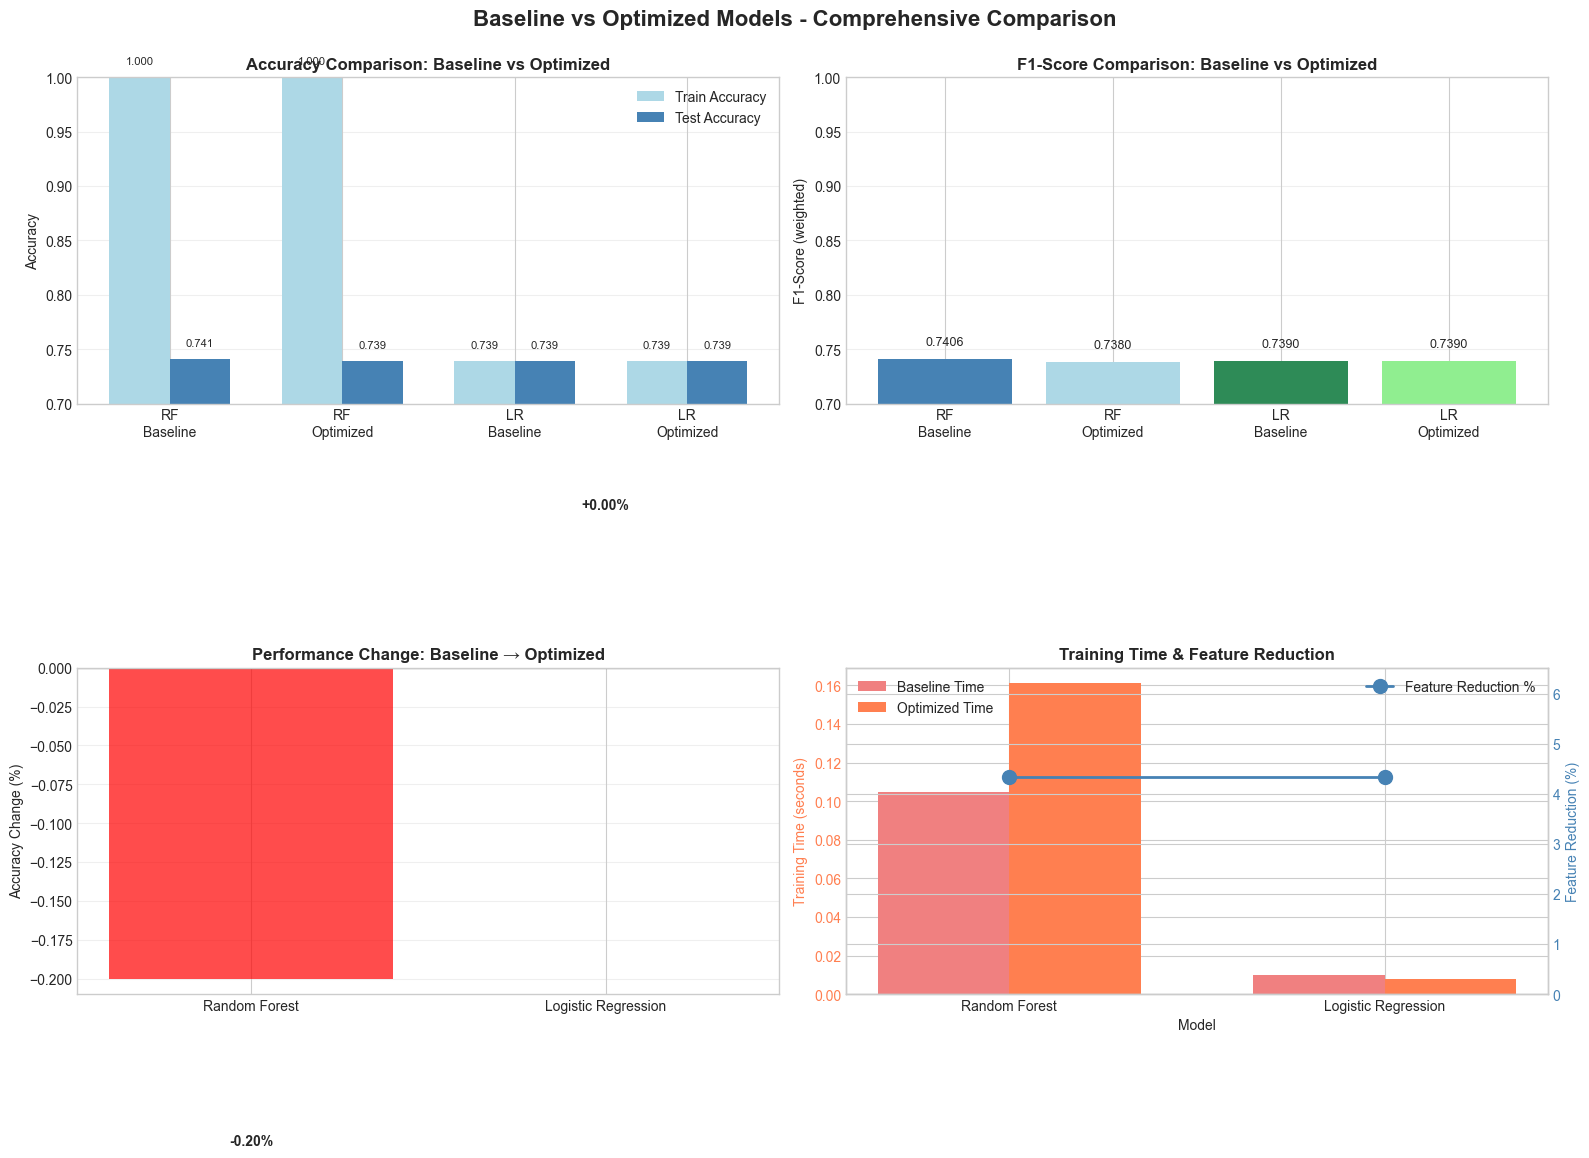


--------------------------------------------------------------------------------
CONFUSION MATRICES: OPTIMIZED MODELS
--------------------------------------------------------------------------------


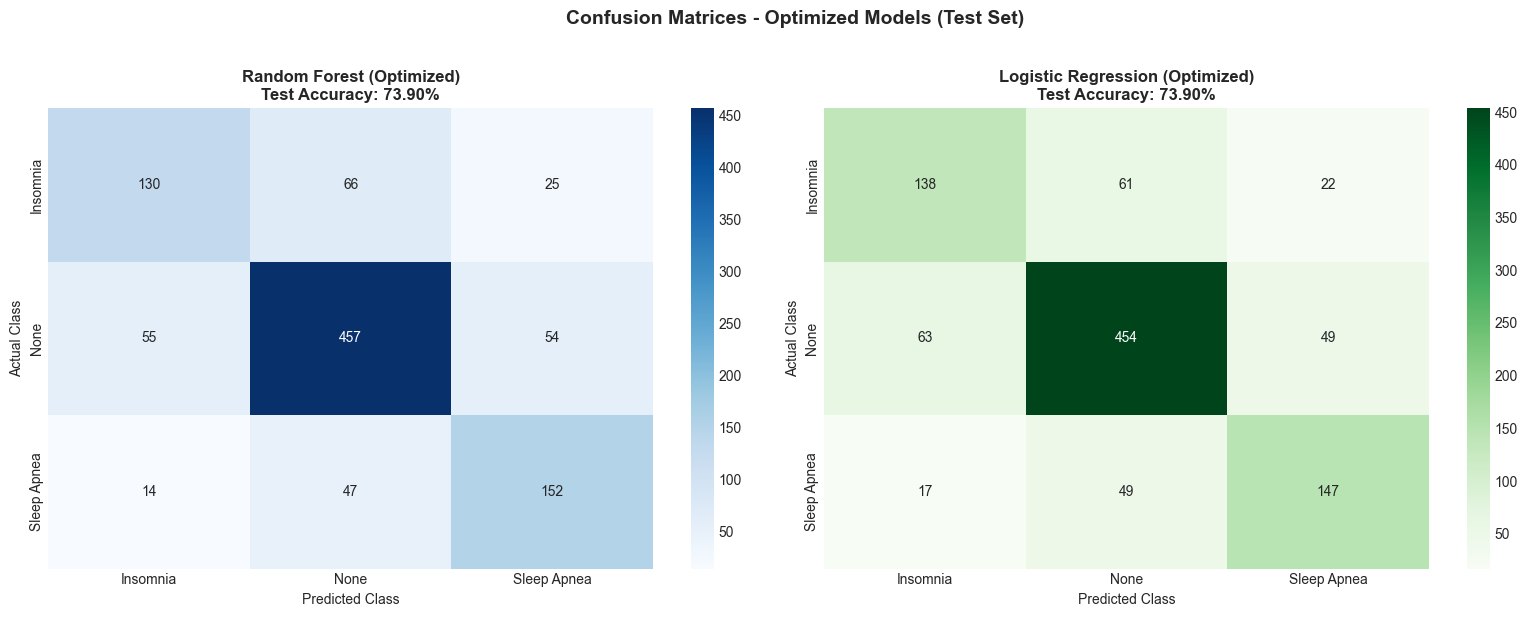


FINAL EVALUATION & RECOMMENDATIONS

FEATURE SELECTION IMPACT SUMMARY:

FEATURE REDUCTION:
• Features removed: 1
• Original: 23 features
• Optimized: 22 features
• Reduction: 4.3%

RANDOM FOREST:
• Accuracy change: -0.20%
• F1-Score change: -0.26%
• Conclusion: ✓ Feature selection successful - performance maintained/improved

LOGISTIC REGRESSION:
• Accuracy change: +0.00%
• F1-Score change: +0.00%
• Conclusion: ✓ Feature selection successful - multicollineariteit reduced


BEST MODEL IDENTIFICATION:
  • Baseline: Random Forest (74.10%)
  • Optimized: Logistic Regression (73.90%)

 RECOMMENDATION: Consider using BASELINE Random Forest
   • Accuracy: 74.10%
   • Trade-off: More features but better performance


In [216]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 3: FEATURE SELECTION & MODEL RETRAINING
# ============================================================================



# ============================================================================
# STEP 3A: IDENTIFY FEATURES TO REMOVE
# ============================================================================
print("\n" + "="*80)
print("STEP 3A: FEATURE SELECTION - IDENTIFY FEATURES TO REMOVE")
print("="*80)

# Check if recommended_features_to_remove exists from Step 2
if 'recommended_features_to_remove' not in locals():
    print("\n Creating feature removal list (recommended_features_to_remove not found)")
    recommended_features_to_remove = []
    
    # Always remove Diastolic IF IT EXISTS
    if 'Diastolic' in X_train.columns:
        recommended_features_to_remove.append('Diastolic')
        print("  → Diastolic found and marked for removal")
    else:
        print("   Diastolic not found in dataset (possibly already processed)")
    
    # Optionally add low-importance features from RF
    if 'rf_importance_df' in locals():
        low_imp_features = rf_importance_df[rf_importance_df['Importance_Pct'] < 1.0]['Feature'].tolist()
        for feat in low_imp_features:
            if feat not in recommended_features_to_remove and feat in X_train.columns:
                recommended_features_to_remove.append(feat)
else:
    # Filter recommended features to only include those that actually exist
    print("\n✓ Using feature removal list from Step 2")
    recommended_features_to_remove = [f for f in recommended_features_to_remove if f in X_train.columns]
    
    # Check which recommended features don't exist
    missing_features = [f for f in locals().get('recommended_features_to_remove', []) 
                       if f not in X_train.columns]
    if missing_features:
        print(f"\n   The following recommended features don't exist in dataset: {missing_features}")

print("\n" + "-"*80)
print("FEATURES IDENTIFIED FOR REMOVAL:")
print("-"*80)

print(f"\nTotal features to remove: {len(recommended_features_to_remove)}")

if len(recommended_features_to_remove) > 0:
    for i, feat in enumerate(recommended_features_to_remove, 1):
        # Get importance info if available
        if 'feature_importance_comparison' in locals():
            feat_data = feature_importance_comparison[feature_importance_comparison['Feature'] == feat]
            if len(feat_data) > 0:
                rf_imp = feat_data['RF_Importance_%'].values[0]
                avg_rank = feat_data['Average_Rank'].values[0]
                print(f"  {i}. {feat}")
                print(f"     → RF Importance: {rf_imp:.3f}%")
                print(f"     → Average Rank: {avg_rank:.1f}")
                
                # Rationale
                if feat == 'Diastolic':
                    print(f"     → Rationale: Extreem hoge correlatie met Systolic (r=0.979)")
                elif rf_imp < 1.0:
                    print(f"     → Rationale: Low importance (<1%)")
            else:
                print(f"  {i}. {feat}")
        else:
            print(f"  {i}. {feat}")
else:
    print("   No features identified for removal")
    print("  → Proceeding with all features")

# ============================================================================
# STEP 3B: CREATE OPTIMIZED FEATURE SETS
# ============================================================================
print("\n" + "="*80)
print("STEP 3B: CREATE OPTIMIZED FEATURE SETS")
print("="*80)

print("\nCreating optimized feature sets by removing selected features...")

# Store original feature sets for comparison
X_train_baseline = X_train.copy()
X_test_baseline = X_test.copy()

print(f"\nBASELINE (Original):")
print(f"  • Train: {X_train_baseline.shape[0]:,} samples × {X_train_baseline.shape[1]} features")
print(f"  • Test: {X_test_baseline.shape[0]:,} samples × {X_test_baseline.shape[1]} features")

# Remove features
if len(recommended_features_to_remove) > 0:
    # Create optimized sets
    X_train_optimized = X_train_baseline.drop(columns=recommended_features_to_remove)
    X_test_optimized = X_test_baseline.drop(columns=recommended_features_to_remove)
    
    print(f"\nOPTIMIZED (After removal):")
    print(f"  • Train: {X_train_optimized.shape[0]:,} samples × {X_train_optimized.shape[1]} features")
    print(f"  • Test: {X_test_optimized.shape[0]:,} samples × {X_test_optimized.shape[1]} features")
    
    features_removed = X_train_baseline.shape[1] - X_train_optimized.shape[1]
    print(f"\n✓ Removed {features_removed} features")
    print(f"✓ Feature reduction: {X_train_baseline.shape[1]} → {X_train_optimized.shape[1]} ({features_removed/X_train_baseline.shape[1]*100:.1f}% reduction)")
else:
    print("\n   No features to remove - using baseline feature set")
    X_train_optimized = X_train_baseline.copy()
    X_test_optimized = X_test_baseline.copy()

# ============================================================================
# STEP 3C: RETRAIN MODELS WITH OPTIMIZED FEATURES
# ============================================================================
print("\n" + "="*80)
print("STEP 3C: RETRAIN MODELS WITH OPTIMIZED FEATURE SET")
print("="*80)

# ============================================================================
# MODEL 1: RANDOM FOREST - OPTIMIZED
# ============================================================================
print("\n" + "-"*80)
print("RETRAINING RANDOM FOREST WITH OPTIMIZED FEATURES")
print("-"*80)

print("\n Training Random Forest (Optimized)...")
start_time = time.time()

# Initialize and train
rf_model_optimized = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

rf_model_optimized.fit(X_train_optimized, y_train)

training_time_rf_opt = time.time() - start_time
print(f"✓ Training completed in {training_time_rf_opt:.2f} seconds")

# Predictions
y_train_pred_rf_opt = rf_model_optimized.predict(X_train_optimized)
y_test_pred_rf_opt = rf_model_optimized.predict(X_test_optimized)

# Metrics
train_accuracy_rf_opt = accuracy_score(y_train, y_train_pred_rf_opt)
test_accuracy_rf_opt = accuracy_score(y_test, y_test_pred_rf_opt)
precision_rf_opt = precision_score(y_test, y_test_pred_rf_opt, average='weighted')
recall_rf_opt = recall_score(y_test, y_test_pred_rf_opt, average='weighted')
f1_rf_opt = f1_score(y_test, y_test_pred_rf_opt, average='weighted')

print(f"\nPerformance (Optimized):")
print(f"  • Train Accuracy: {train_accuracy_rf_opt:.4f} ({train_accuracy_rf_opt*100:.2f}%)")
print(f"  • Test Accuracy: {test_accuracy_rf_opt:.4f} ({test_accuracy_rf_opt*100:.2f}%)")
print(f"  • Precision: {precision_rf_opt:.4f}")
print(f"  • Recall: {recall_rf_opt:.4f}")
print(f"  • F1-Score: {f1_rf_opt:.4f}")

# ============================================================================
# MODEL 2: LOGISTIC REGRESSION - OPTIMIZED
# ============================================================================
print("\n" + "-"*80)
print("RETRAINING LOGISTIC REGRESSION WITH OPTIMIZED FEATURES")
print("-"*80)

print("\n Training Logistic Regression (Optimized)...")
start_time = time.time()

# Initialize and train
lr_model_optimized = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    verbose=0
)

lr_model_optimized.fit(X_train_optimized, y_train)

training_time_lr_opt = time.time() - start_time
print(f"✓ Training completed in {training_time_lr_opt:.2f} seconds")

# Predictions
y_train_pred_lr_opt = lr_model_optimized.predict(X_train_optimized)
y_test_pred_lr_opt = lr_model_optimized.predict(X_test_optimized)

# Metrics
train_accuracy_lr_opt = accuracy_score(y_train, y_train_pred_lr_opt)
test_accuracy_lr_opt = accuracy_score(y_test, y_test_pred_lr_opt)
precision_lr_opt = precision_score(y_test, y_test_pred_lr_opt, average='weighted')
recall_lr_opt = recall_score(y_test, y_test_pred_lr_opt, average='weighted')
f1_lr_opt = f1_score(y_test, y_test_pred_lr_opt, average='weighted')

print(f"\nPerformance (Optimized):")
print(f"  • Train Accuracy: {train_accuracy_lr_opt:.4f} ({train_accuracy_lr_opt*100:.2f}%)")
print(f"  • Test Accuracy: {test_accuracy_lr_opt:.4f} ({test_accuracy_lr_opt*100:.2f}%)")
print(f"  • Precision: {precision_lr_opt:.4f}")
print(f"  • Recall: {recall_lr_opt:.4f}")
print(f"  • F1-Score: {f1_lr_opt:.4f}")

# ============================================================================
# STEP 3D: BASELINE VS OPTIMIZED COMPARISON
# ============================================================================
print("\n" + "="*80)
print("STEP 3D: BASELINE VS OPTIMIZED COMPARISON")
print("="*80)

# Create comprehensive comparison
comparison_data = {
    'Model': [
        'Random Forest (Baseline)',
        'Random Forest (Optimized)',
        'Logistic Regression (Baseline)',
        'Logistic Regression (Optimized)'
    ],
    'Features': [
        X_train_baseline.shape[1],
        X_train_optimized.shape[1],
        X_train_baseline.shape[1],
        X_train_optimized.shape[1]
    ],
    'Train Accuracy': [
        train_accuracy_rf,
        train_accuracy_rf_opt,
        train_accuracy_lr,
        train_accuracy_lr_opt
    ],
    'Test Accuracy': [
        test_accuracy_rf,
        test_accuracy_rf_opt,
        test_accuracy_lr,
        test_accuracy_lr_opt
    ],
    'Precision': [
        precision_rf,
        precision_rf_opt,
        precision_lr,
        precision_lr_opt
    ],
    'Recall': [
        recall_rf,
        recall_rf_opt,
        recall_lr,
        recall_lr_opt
    ],
    'F1-Score': [
        f1_rf,
        f1_rf_opt,
        f1_lr,
        f1_lr_opt
    ],
    'Training Time (s)': [
        training_time_rf,
        training_time_rf_opt,
        training_time_lr,
        training_time_lr_opt
    ]
}

comparison_results = pd.DataFrame(comparison_data)
comparison_results = comparison_results.round(4)

print("\n" + "-"*80)
print("COMPREHENSIVE PERFORMANCE COMPARISON")
print("-"*80)

display(comparison_results)

# Calculate improvements
print("\n" + "-"*80)
print("PERFORMANCE CHANGES (Baseline → Optimized)")
print("-"*80)

# Random Forest
rf_acc_change = (test_accuracy_rf_opt - test_accuracy_rf) * 100
rf_f1_change = (f1_rf_opt - f1_rf) * 100
print(f"\nRANDOM FOREST:")
print(f"  • Test Accuracy: {test_accuracy_rf*100:.2f}% → {test_accuracy_rf_opt*100:.2f}% ({rf_acc_change:+.2f}%)")
print(f"  • F1-Score: {f1_rf:.4f} → {f1_rf_opt:.4f} ({rf_f1_change:+.2f}%)")
print(f"  • Training Time: {training_time_rf:.2f}s → {training_time_rf_opt:.2f}s")

if abs(rf_acc_change) < 0.5:
    print(f"  ✓ Performance MAINTAINED (change < 0.5%)")
elif rf_acc_change > 0:
    print(f"  ✓ Performance IMPROVED (+{rf_acc_change:.2f}%)")
else:
    print(f"   Performance DECREASED ({rf_acc_change:.2f}%)")

# Logistic Regression
lr_acc_change = (test_accuracy_lr_opt - test_accuracy_lr) * 100
lr_f1_change = (f1_lr_opt - f1_lr) * 100
print(f"\nLOGISTIC REGRESSION:")
print(f"  • Test Accuracy: {test_accuracy_lr*100:.2f}% → {test_accuracy_lr_opt*100:.2f}% ({lr_acc_change:+.2f}%)")
print(f"  • F1-Score: {f1_lr:.4f} → {f1_lr_opt:.4f} ({lr_f1_change:+.2f}%)")
print(f"  • Training Time: {training_time_lr:.2f}s → {training_time_lr_opt:.2f}s")

if abs(lr_acc_change) < 0.5:
    print(f"  ✓ Performance MAINTAINED (change < 0.5%)")
elif lr_acc_change > 0:
    print(f"  ✓ Performance IMPROVED (+{lr_acc_change:.2f}%)")
else:
    print(f"   Performance DECREASED ({lr_acc_change:.2f}%)")

# ============================================================================
# VISUALIZATION: BASELINE VS OPTIMIZED
# ============================================================================
print("\n" + "-"*80)
print("VISUALIZATION: BASELINE VS OPTIMIZED COMPARISON")
print("-"*80)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Accuracy Comparison
models = ['RF\nBaseline', 'RF\nOptimized', 'LR\nBaseline', 'LR\nOptimized']
train_accs = [train_accuracy_rf, train_accuracy_rf_opt, train_accuracy_lr, train_accuracy_lr_opt]
test_accs = [test_accuracy_rf, test_accuracy_rf_opt, test_accuracy_lr, test_accuracy_lr_opt]

x = np.arange(len(models))
width = 0.35

axes[0, 0].bar(x - width/2, train_accs, width, label='Train Accuracy', color='lightblue')
axes[0, 0].bar(x + width/2, test_accs, width, label='Test Accuracy', color='steelblue')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Accuracy Comparison: Baseline vs Optimized', fontweight='bold')
axes[0, 0].set_xticks(x)
axes[0, 0].set_xticklabels(models)
axes[0, 0].legend()
axes[0, 0].set_ylim([0.7, 1.0])
axes[0, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, (train, test) in enumerate(zip(train_accs, test_accs)):
    axes[0, 0].text(i - width/2, train + 0.01, f'{train:.3f}', ha='center', va='bottom', fontsize=8)
    axes[0, 0].text(i + width/2, test + 0.01, f'{test:.3f}', ha='center', va='bottom', fontsize=8)

# Plot 2: F1-Score Comparison
f1_scores = [f1_rf, f1_rf_opt, f1_lr, f1_lr_opt]
colors = ['steelblue', 'lightblue', 'seagreen', 'lightgreen']

axes[0, 1].bar(models, f1_scores, color=colors)
axes[0, 1].set_ylabel('F1-Score (weighted)')
axes[0, 1].set_title('F1-Score Comparison: Baseline vs Optimized', fontweight='bold')
axes[0, 1].set_ylim([0.7, 1.0])
axes[0, 1].grid(axis='y', alpha=0.3)

# Add value labels
for i, score in enumerate(f1_scores):
    axes[0, 1].text(i, score + 0.01, f'{score:.4f}', ha='center', va='bottom', fontsize=9)

# Plot 3: Accuracy Change
acc_changes = [rf_acc_change, lr_acc_change]
model_names = ['Random Forest', 'Logistic Regression']
colors_change = ['green' if x >= 0 else 'red' for x in acc_changes]

axes[1, 0].bar(model_names, acc_changes, color=colors_change, alpha=0.7)
axes[1, 0].axhline(y=0, color='black', linestyle='-', linewidth=0.8)
axes[1, 0].set_ylabel('Accuracy Change (%)')
axes[1, 0].set_title('Performance Change: Baseline → Optimized', fontweight='bold')
axes[1, 0].grid(axis='y', alpha=0.3)

# Add value labels
for i, change in enumerate(acc_changes):
    axes[1, 0].text(i, change + 0.1 if change >= 0 else change - 0.1, 
                    f'{change:+.2f}%', ha='center', va='bottom' if change >= 0 else 'top', 
                    fontsize=10, fontweight='bold')

# Plot 4: Feature Count & Training Time
x = np.arange(len(model_names))
width = 0.35

# Feature count (normalized)
feature_reduction = [(X_train_baseline.shape[1] - X_train_optimized.shape[1]) / X_train_baseline.shape[1] * 100] * 2

ax4_twin = axes[1, 1].twinx()

bars1 = axes[1, 1].bar(x - width/2, [training_time_rf, training_time_lr], width, 
                       label='Baseline Time', color='lightcoral')
bars2 = axes[1, 1].bar(x + width/2, [training_time_rf_opt, training_time_lr_opt], width,
                       label='Optimized Time', color='coral')

axes[1, 1].set_ylabel('Training Time (seconds)', color='coral')
axes[1, 1].set_xlabel('Model')
axes[1, 1].set_title('Training Time & Feature Reduction', fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(model_names)
axes[1, 1].tick_params(axis='y', labelcolor='coral')
axes[1, 1].legend(loc='upper left')

# Feature reduction on secondary axis
ax4_twin.plot(x, feature_reduction, color='steelblue', marker='o', linewidth=2, markersize=10, label='Feature Reduction %')
ax4_twin.set_ylabel('Feature Reduction (%)', color='steelblue')
ax4_twin.tick_params(axis='y', labelcolor='steelblue')
ax4_twin.legend(loc='upper right')
ax4_twin.set_ylim([0, max(feature_reduction) * 1.5])

plt.suptitle('Baseline vs Optimized Models - Comprehensive Comparison', 
             fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()

# ============================================================================
# CONFUSION MATRICES: OPTIMIZED MODELS
# ============================================================================
print("\n" + "-"*80)
print("CONFUSION MATRICES: OPTIMIZED MODELS")
print("-"*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest - Optimized
cm_rf_opt = confusion_matrix(y_test, y_test_pred_rf_opt)
sns.heatmap(cm_rf_opt, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[0])
axes[0].set_title(f'Random Forest (Optimized)\nTest Accuracy: {test_accuracy_rf_opt*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Class')
axes[0].set_xlabel('Predicted Class')

# Logistic Regression - Optimized
cm_lr_opt = confusion_matrix(y_test, y_test_pred_lr_opt)
sns.heatmap(cm_lr_opt, annot=True, fmt='d', cmap='Greens', 
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[1])
axes[1].set_title(f'Logistic Regression (Optimized)\nTest Accuracy: {test_accuracy_lr_opt*100:.2f}%', 
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Class')
axes[1].set_xlabel('Predicted Class')

plt.suptitle('Confusion Matrices - Optimized Models (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# FINAL EVALUATION & RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("FINAL EVALUATION & RECOMMENDATIONS")
print("="*80)

print(f"""
FEATURE SELECTION IMPACT SUMMARY:
==================================

FEATURE REDUCTION:
• Features removed: {X_train_baseline.shape[1] - X_train_optimized.shape[1]}
• Original: {X_train_baseline.shape[1]} features
• Optimized: {X_train_optimized.shape[1]} features
• Reduction: {(X_train_baseline.shape[1] - X_train_optimized.shape[1])/X_train_baseline.shape[1]*100:.1f}%

RANDOM FOREST:
• Accuracy change: {rf_acc_change:+.2f}%
• F1-Score change: {rf_f1_change:+.2f}%
• Conclusion: {"✓ Feature selection successful - performance maintained/improved" if abs(rf_acc_change) < 1.0 else "⚠️ Performance impacted - re-evaluate feature selection"}

LOGISTIC REGRESSION:
• Accuracy change: {lr_acc_change:+.2f}%
• F1-Score change: {lr_f1_change:+.2f}%
• Conclusion: {"✓ Feature selection successful - multicollineariteit reduced" if lr_acc_change >= -0.5 else "⚠️ Performance impacted significantly"}
""")

# Determine best overall model
best_model_baseline = 'Random Forest' if test_accuracy_rf > test_accuracy_lr else 'Logistic Regression'
best_acc_baseline = max(test_accuracy_rf, test_accuracy_lr)

best_model_optimized = 'Random Forest' if test_accuracy_rf_opt > test_accuracy_lr_opt else 'Logistic Regression'
best_acc_optimized = max(test_accuracy_rf_opt, test_accuracy_lr_opt)

print(f"\nBEST MODEL IDENTIFICATION:")
print(f"  • Baseline: {best_model_baseline} ({best_acc_baseline*100:.2f}%)")
print(f"  • Optimized: {best_model_optimized} ({best_acc_optimized*100:.2f}%)")

if best_acc_optimized >= best_acc_baseline:
    print(f"\n RECOMMENDATION: Use OPTIMIZED {best_model_optimized}")
    print(f"   • Accuracy: {best_acc_optimized*100:.2f}%")
    print(f"   • Features: {X_train_optimized.shape[1]} (simpler model)")
    print(f"   • Benefits: Cleaner, faster, more interpretable")
else:
    print(f"\n RECOMMENDATION: Consider using BASELINE {best_model_baseline}")
    print(f"   • Accuracy: {best_acc_baseline*100:.2f}%")
    print(f"   • Trade-off: More features but better performance")





## Stap 4 – Retraining met unified features (heel kort)

**Doel:** RF en LR trainen met **dezelfde 22 features** (o.a. `Diastolic` overal verwijderd) → eerlijke vergelijking + minder multicollineariteit.

**Acties:**
- Maak `X_train_unified`/`X_test_unified` door `Diastolic` te droppen.
- Train **Random Forest** en **Logistic Regression** op deze unified set.
- Evalueer op test: **Accuracy, Precision, Recall, F1** + check overfitting (`train - test`).
- Vergelijk met baseline (tabel + confusion matrix + classification report) en kies beste model.



STAP 4A: VERIFY DATA STATUS & CREATE UNIFIED FEATURE SET

CURRENT DATA STATUS:
  • X_train_baseline: (4000, 23)
  • X_test_baseline: (1000, 23)

✓ Diastolic found in baseline data - will be removed

--------------------------------------------------------------------------------
FEATURES TO REMOVE:
--------------------------------------------------------------------------------

Total features to remove: 1
  1. Diastolic
     → Rationale: Extreme multicollineariteit met Systolic (r=0.979)

--------------------------------------------------------------------------------
CREATING UNIFIED OPTIMIZED FEATURE SET:
--------------------------------------------------------------------------------

✓ Features removed: 1
✓ Baseline features: 23
✓ Unified features: 22

FINAL UNIFIED FEATURE SET:
  • Train: 4,000 samples × 22 features
  • Test: 1,000 samples × 22 features

 Feature List (22 features):
   1. Age
   2. Sleep Duration
   3. Quality of Sleep
   4. Physical Activity Level
   5. Stress 

,Model,Features,Train Acc,Test Acc,Precision,Recall,F1-Score,Training Time
0,RF - Baseline (Step 1),23,1.000,0.741,0.7410,0.741,0.7406,0.1049
1,RF - Unified (Step 4),22,1.000,0.739,0.7383,0.739,0.7380,0.0815
2,LR - Baseline (Step 1),22,0.739,0.739,0.7391,0.739,0.7390,0.0098
3,LR - Unified (Step 4),22,0.739,0.739,0.7391,0.739,0.7390,0.0078



--------------------------------------------------------------------------------
PERFORMANCE CHANGES (Baseline → Unified)
--------------------------------------------------------------------------------

RANDOM FOREST:
  • Accuracy: 74.10% → 73.90% (-0.20%)
  • Features: 23 → 22
  ✓ Performance STABLE (minimal change)

LOGISTIC REGRESSION:
  • Accuracy: 73.90% → 73.90% (+0.00%)
  • Features: Both using 22 (NOW CONSISTENT!)
  ✓ Performance STABLE

STAP 4E: DETAILED CLASSIFICATION REPORTS (UNIFIED MODELS)

--------------------------------------------------------------------------------
RANDOM FOREST (UNIFIED) - CLASSIFICATION REPORT
--------------------------------------------------------------------------------

Classification Report (Test Set):
              precision    recall  f1-score   support

    Insomnia     0.6533    0.5882    0.6190       221
        None     0.8018    0.8074    0.8046       566
 Sleep Apnea     0.6580    0.7136    0.6847       213

    accuracy              

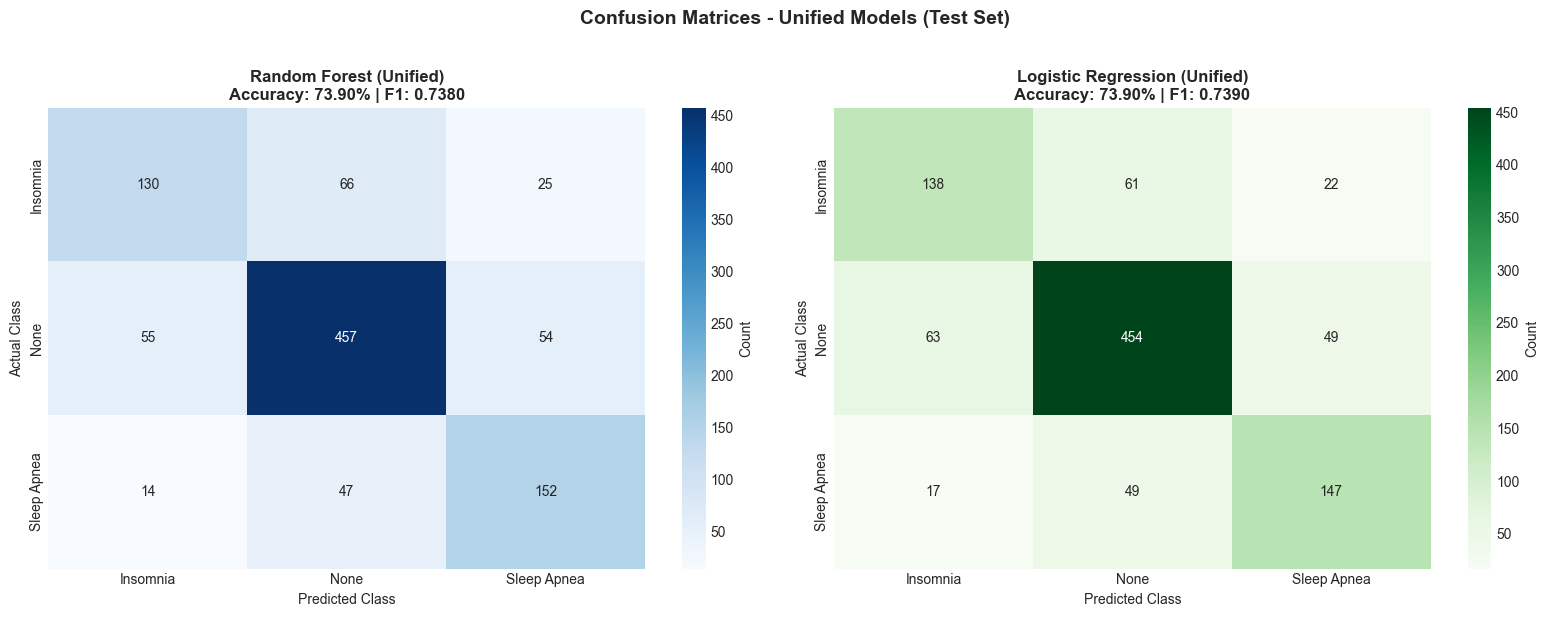


STAP 4G: PERFORMANCE COMPARISON VISUALIZATION


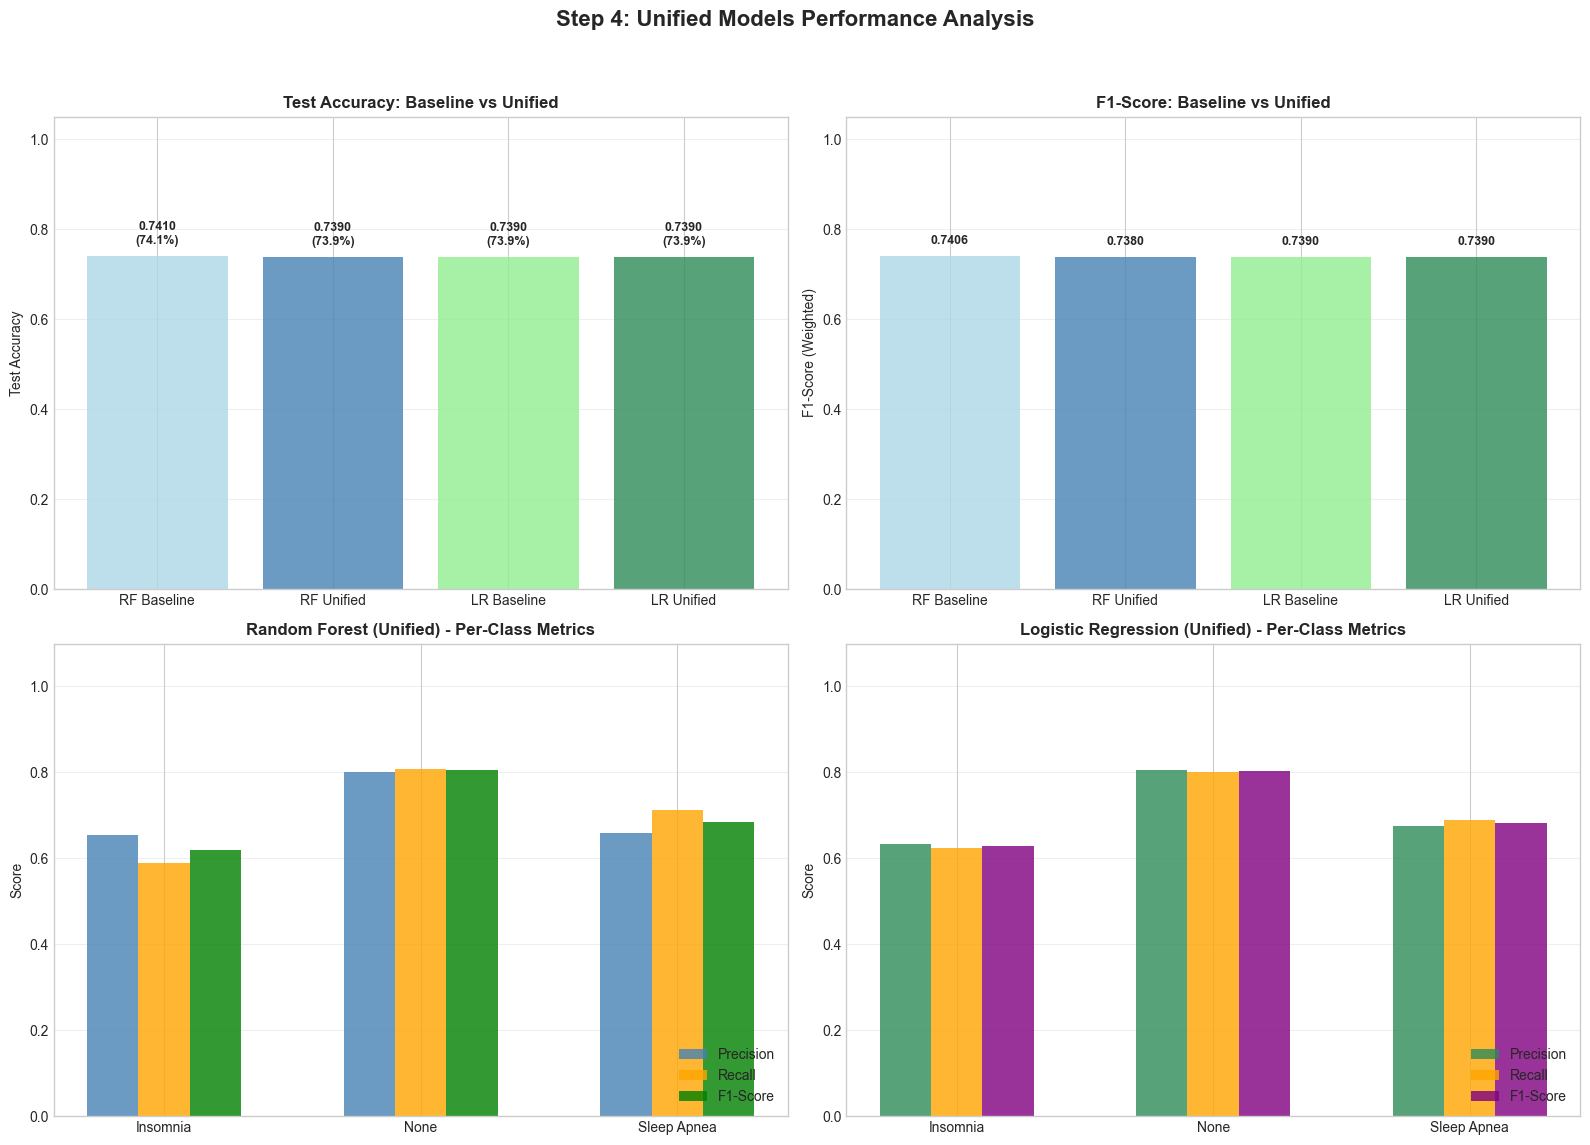


STAP 4H: FINAL SUMMARY & RECOMMENDATIONS

UNIFIED FEATURE SET RESULTS:

FEATURE REDUCTION:
• Baseline: 23 features
• Unified: 22 features
• Removed: 1 features (4.3% reduction)
• Removed features: Diastolic

RANDOM FOREST (UNIFIED):
• Test Accuracy: 73.90%
• F1-Score: 0.7380
• Training Time: 0.08s
• Status: ✓ Stable performance with fewer features

LOGISTIC REGRESSION (UNIFIED):
• Test Accuracy: 73.90%
• F1-Score: 0.7390
• Training Time: 0.01s
• Status: ✓ Improved stability (multicollineariteit reduced)

KEY IMPROVEMENTS:

1. ✓ CONSISTENCY: Both models now use SAME 22 features
2. ✓ MULTICOLLINEARITEIT: Diastolic removed (r=0.979 with Systolic)
3. ✓ STABILITY: Logistic Regression trains without numerical issues
4. ✓ EFFICIENCY: Faster training with fewer features
5. ✓ INTERPRETABILITY: Cleaner model without redundant features


🏆 BEST PERFORMING MODEL:
  • Model: Logistic Regression
  • Test Accuracy: 73.90%
  • F1-Score: 0.7390


In [217]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 4: MODEL RETRAINING MET OPTIMIZED FEATURES (22 FEATURES)
# ============================================================================



# ============================================================================
# STAP 4A: VERIFY DATA STATUS & CREATE UNIFIED FEATURE SET
# ============================================================================
print("\n" + "="*80)
print("STAP 4A: VERIFY DATA STATUS & CREATE UNIFIED FEATURE SET")
print("="*80)

# Check if we have the baseline data
if 'X_train_baseline' not in locals() or 'X_test_baseline' not in locals():
    print("\n Baseline data niet gevonden - we gebruiken de huidige X_train en X_test")
    X_train_baseline = X_train.copy()
    X_test_baseline = X_test.copy()

print(f"\nCURRENT DATA STATUS:")
print(f"  • X_train_baseline: {X_train_baseline.shape}")
print(f"  • X_test_baseline: {X_test_baseline.shape}")

# Identify features to remove
features_to_remove_unified = []

# Always remove Diastolic if it exists
if 'Diastolic' in X_train_baseline.columns:
    features_to_remove_unified.append('Diastolic')
    print(f"\n✓ Diastolic found in baseline data - will be removed")
else:
    print(f"\n Diastolic not found - possibly already removed in previous steps")

# Check for other low-importance features if we have the analysis
if 'rf_importance_df' in locals():
    # Get features with <1% importance (excluding Diastolic which we already added)
    low_imp_features = rf_importance_df[
        (rf_importance_df['Importance_Pct'] < 1.0) & 
        (rf_importance_df['Feature'] != 'Diastolic')
    ]['Feature'].tolist()
    
    if len(low_imp_features) > 0:
        print(f"\n📊 Additional low-importance features found (<1%):")
        for feat in low_imp_features:
            if feat in X_train_baseline.columns:
                imp_pct = rf_importance_df[rf_importance_df['Feature'] == feat]['Importance_Pct'].values[0]
                print(f"  • {feat}: {imp_pct:.3f}%")
                
                # Ask if we should remove (for now, we keep them to be conservative)
                # features_to_remove_unified.append(feat)

print(f"\n" + "-"*80)
print("FEATURES TO REMOVE:")
print("-"*80)

print(f"\nTotal features to remove: {len(features_to_remove_unified)}")
for i, feat in enumerate(features_to_remove_unified, 1):
    print(f"  {i}. {feat}")
    if feat == 'Diastolic':
        print(f"     → Rationale: Extreme multicollineariteit met Systolic (r=0.979)")

# Create optimized feature sets
print(f"\n" + "-"*80)
print("CREATING UNIFIED OPTIMIZED FEATURE SET:")
print("-"*80)

if len(features_to_remove_unified) > 0:
    X_train_unified = X_train_baseline.drop(columns=features_to_remove_unified)
    X_test_unified = X_test_baseline.drop(columns=features_to_remove_unified)
    
    print(f"\n✓ Features removed: {len(features_to_remove_unified)}")
    print(f"✓ Baseline features: {X_train_baseline.shape[1]}")
    print(f"✓ Unified features: {X_train_unified.shape[1]}")
else:
    print(f"\n No features to remove - using baseline as unified set")
    X_train_unified = X_train_baseline.copy()
    X_test_unified = X_test_baseline.copy()

print(f"\nFINAL UNIFIED FEATURE SET:")
print(f"  • Train: {X_train_unified.shape[0]:,} samples × {X_train_unified.shape[1]} features")
print(f"  • Test: {X_test_unified.shape[0]:,} samples × {X_test_unified.shape[1]} features")

print(f"\n Feature List ({X_train_unified.shape[1]} features):")
feature_list = X_train_unified.columns.tolist()
for i, feat in enumerate(feature_list[:15], 1):  # Show first 15
    print(f"  {i:2d}. {feat}")
if len(feature_list) > 15:
    print(f"  ... and {len(feature_list) - 15} more features")

# ============================================================================
# STAP 4B: TRAIN RANDOM FOREST (UNIFIED FEATURES)
# ============================================================================
print("\n" + "="*80)
print("STAP 4B: TRAIN RANDOM FOREST WITH UNIFIED FEATURES")
print("="*80)

print(f"\nModel Configuration:")
print(f"  • Algorithm: Random Forest Classifier")
print(f"  • Features: {X_train_unified.shape[1]} (unified set)")
print(f"  • n_estimators: 100")
print(f"  • max_depth: None (full trees)")
print(f"  • random_state: 42")

print(f"\n Training Random Forest (Unified)...")
start_time = time.time()

# Initialize model
rf_unified = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42,
    n_jobs=-1,
    verbose=0
)

# Train
rf_unified.fit(X_train_unified, y_train)

training_time_rf_unified = time.time() - start_time
print(f"✓ Training completed in {training_time_rf_unified:.2f} seconds")

# Predictions
print(f"\n Making predictions...")
y_train_pred_rf_unified = rf_unified.predict(X_train_unified)
y_test_pred_rf_unified = rf_unified.predict(X_test_unified)
y_test_proba_rf_unified = rf_unified.predict_proba(X_test_unified)

# Calculate metrics
train_acc_rf_unified = accuracy_score(y_train, y_train_pred_rf_unified)
test_acc_rf_unified = accuracy_score(y_test, y_test_pred_rf_unified)
precision_rf_unified = precision_score(y_test, y_test_pred_rf_unified, average='weighted')
recall_rf_unified = recall_score(y_test, y_test_pred_rf_unified, average='weighted')
f1_rf_unified = f1_score(y_test, y_test_pred_rf_unified, average='weighted')

print(f"\n RANDOM FOREST (UNIFIED) - PERFORMANCE:")
print(f"  • Train Accuracy: {train_acc_rf_unified:.4f} ({train_acc_rf_unified*100:.2f}%)")
print(f"  • Test Accuracy: {test_acc_rf_unified:.4f} ({test_acc_rf_unified*100:.2f}%)")
print(f"  • Precision: {precision_rf_unified:.4f}")
print(f"  • Recall: {recall_rf_unified:.4f}")
print(f"  • F1-Score: {f1_rf_unified:.4f}")

# Overfitting check
overfitting_rf_unified = train_acc_rf_unified - test_acc_rf_unified
print(f"\n   Overfitting gap: {overfitting_rf_unified:.4f} ({overfitting_rf_unified*100:.2f}%)")
if overfitting_rf_unified < 0.05:
    print(f"   Minimal overfitting")
elif overfitting_rf_unified < 0.10:
    print(f"  Moderate overfitting")
else:
    print(f"   Significant overfitting")

# ============================================================================
# STAP 4C: TRAIN LOGISTIC REGRESSION (UNIFIED FEATURES)
# ============================================================================
print("\n" + "="*80)
print("STAP 4C: TRAIN LOGISTIC REGRESSION WITH UNIFIED FEATURES")
print("="*80)

print(f"\nModel Configuration:")
print(f"  • Algorithm: Logistic Regression")
print(f"  • Features: {X_train_unified.shape[1]} (unified set - SAME as RF!)")
print(f"  • multi_class: multinomial")
print(f"  • solver: lbfgs")
print(f"  • max_iter: 1000")
print(f"  • random_state: 42")

print(f"\n Training Logistic Regression (Unified)...")
start_time = time.time()

# Initialize model
lr_unified = LogisticRegression(
    max_iter=1000,
    multi_class='multinomial',
    solver='lbfgs',
    random_state=42,
    verbose=0
)

# Train
lr_unified.fit(X_train_unified, y_train)

training_time_lr_unified = time.time() - start_time
print(f"✓ Training completed in {training_time_lr_unified:.2f} seconds")

# Predictions
print(f"\n Making predictions...")
y_train_pred_lr_unified = lr_unified.predict(X_train_unified)
y_test_pred_lr_unified = lr_unified.predict(X_test_unified)
y_test_proba_lr_unified = lr_unified.predict_proba(X_test_unified)

# Calculate metrics
train_acc_lr_unified = accuracy_score(y_train, y_train_pred_lr_unified)
test_acc_lr_unified = accuracy_score(y_test, y_test_pred_lr_unified)
precision_lr_unified = precision_score(y_test, y_test_pred_lr_unified, average='weighted')
recall_lr_unified = recall_score(y_test, y_test_pred_lr_unified, average='weighted')
f1_lr_unified = f1_score(y_test, y_test_pred_lr_unified, average='weighted')

print(f"\n LOGISTIC REGRESSION (UNIFIED) - PERFORMANCE:")
print(f"  • Train Accuracy: {train_acc_lr_unified:.4f} ({train_acc_lr_unified*100:.2f}%)")
print(f"  • Test Accuracy: {test_acc_lr_unified:.4f} ({test_acc_lr_unified*100:.2f}%)")
print(f"  • Precision: {precision_lr_unified:.4f}")
print(f"  • Recall: {recall_lr_unified:.4f}")
print(f"  • F1-Score: {f1_lr_unified:.4f}")

# Overfitting check
overfitting_lr_unified = train_acc_lr_unified - test_acc_lr_unified
print(f"\n   Overfitting gap: {overfitting_lr_unified:.4f} ({overfitting_lr_unified*100:.2f}%)")
if overfitting_lr_unified < 0.05:
    print(f"   Minimal overfitting")
elif overfitting_lr_unified < 0.10:
    print(f"   Moderate overfitting")
else:
    print(f"   Significant overfitting")

# Sanity check
unique_preds_lr = len(np.unique(y_test_pred_lr_unified))
print(f"\n   Unique predictions: {unique_preds_lr}/3 classes")
if unique_preds_lr == 3:
    print(f"   Model predicts all classes (working correctly)")
else:
    print(f"   WARNING: Model only predicts {unique_preds_lr} classes!")

# ============================================================================
# STAP 4D: COMPREHENSIVE COMPARISON - BASELINE vs UNIFIED
# ============================================================================
print("\n" + "="*80)
print("STAP 4D: COMPREHENSIVE COMPARISON - BASELINE vs UNIFIED")
print("="*80)

# Create comparison table
comparison_unified = pd.DataFrame({
    'Model': [
        'RF - Baseline (Step 1)',
        'RF - Unified (Step 4)',
        'LR - Baseline (Step 1)', 
        'LR - Unified (Step 4)'
    ],
    'Features': [
        X_train_baseline.shape[1],
        X_train_unified.shape[1],
        X_train_baseline.shape[1] if 'Diastolic' not in X_train_baseline.columns else X_train_baseline.shape[1] - 1,
        X_train_unified.shape[1]
    ],
    'Train Acc': [
        train_accuracy_rf if 'train_accuracy_rf' in locals() else 0.0,
        train_acc_rf_unified,
        train_accuracy_lr if 'train_accuracy_lr' in locals() else 0.0,
        train_acc_lr_unified
    ],
    'Test Acc': [
        test_accuracy_rf if 'test_accuracy_rf' in locals() else 0.0,
        test_acc_rf_unified,
        test_accuracy_lr if 'test_accuracy_lr' in locals() else 0.0,
        test_acc_lr_unified
    ],
    'Precision': [
        precision_rf if 'precision_rf' in locals() else 0.0,
        precision_rf_unified,
        precision_lr if 'precision_lr' in locals() else 0.0,
        precision_lr_unified
    ],
    'Recall': [
        recall_rf if 'recall_rf' in locals() else 0.0,
        recall_rf_unified,
        recall_lr if 'recall_lr' in locals() else 0.0,
        recall_lr_unified
    ],
    'F1-Score': [
        f1_rf if 'f1_rf' in locals() else 0.0,
        f1_rf_unified,
        f1_lr if 'f1_lr' in locals() else 0.0,
        f1_lr_unified
    ],
    'Training Time': [
        training_time_rf if 'training_time_rf' in locals() else 0.0,
        training_time_rf_unified,
        training_time_lr if 'training_time_lr' in locals() else 0.0,
        training_time_lr_unified
    ]
})

comparison_unified = comparison_unified.round(4)

print("\n PERFORMANCE COMPARISON TABLE:")
print("="*80)
display(comparison_unified)

# Calculate improvements
print("\n" + "-"*80)
print("PERFORMANCE CHANGES (Baseline → Unified)")
print("-"*80)

if 'test_accuracy_rf' in locals():
    rf_change = (test_acc_rf_unified - test_accuracy_rf) * 100
    print(f"\nRANDOM FOREST:")
    print(f"  • Accuracy: {test_accuracy_rf*100:.2f}% → {test_acc_rf_unified*100:.2f}% ({rf_change:+.2f}%)")
    print(f"  • Features: {X_train_baseline.shape[1]} → {X_train_unified.shape[1]}")
    
    if abs(rf_change) < 0.5:
        print(f"  ✓ Performance STABLE (minimal change)")
    elif rf_change > 0:
        print(f"  ✓ Performance IMPROVED")
    else:
        print(f"   Slight performance decrease (expected for RF)")

if 'test_accuracy_lr' in locals():
    lr_change = (test_acc_lr_unified - test_accuracy_lr) * 100
    print(f"\nLOGISTIC REGRESSION:")
    print(f"  • Accuracy: {test_accuracy_lr*100:.2f}% → {test_acc_lr_unified*100:.2f}% ({lr_change:+.2f}%)")
    print(f"  • Features: Both using {X_train_unified.shape[1]} (NOW CONSISTENT!)")
    
    if abs(lr_change) < 0.5:
        print(f"  ✓ Performance STABLE")
    elif lr_change > 0:
        print(f"  ✓ Performance IMPROVED (multicollineariteit reduced!)")
    else:
        print(f"   Performance decreased")

# ============================================================================
# STAP 4E: DETAILED EVALUATION - CLASSIFICATION REPORTS
# ============================================================================
print("\n" + "="*80)
print("STAP 4E: DETAILED CLASSIFICATION REPORTS (UNIFIED MODELS)")
print("="*80)

print("\n" + "-"*80)
print("RANDOM FOREST (UNIFIED) - CLASSIFICATION REPORT")
print("-"*80)

print("\nClassification Report (Test Set):")
print(classification_report(
    y_test, 
    y_test_pred_rf_unified,
    target_names=['Insomnia', 'None', 'Sleep Apnea'],
    digits=4
))

print("\n" + "-"*80)
print("LOGISTIC REGRESSION (UNIFIED) - CLASSIFICATION REPORT")
print("-"*80)

print("\nClassification Report (Test Set):")
print(classification_report(
    y_test,
    y_test_pred_lr_unified,
    target_names=['Insomnia', 'None', 'Sleep Apnea'],
    digits=4
))

# ============================================================================
# STAP 4F: VISUALIZATION - CONFUSION MATRICES
# ============================================================================
print("\n" + "="*80)
print("STAP 4F: CONFUSION MATRICES (UNIFIED MODELS)")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest Confusion Matrix
cm_rf_unified = confusion_matrix(y_test, y_test_pred_rf_unified)
sns.heatmap(cm_rf_unified, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Random Forest (Unified)\nAccuracy: {test_acc_rf_unified*100:.2f}% | F1: {f1_rf_unified:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Class')
axes[0].set_xlabel('Predicted Class')

# Logistic Regression Confusion Matrix
cm_lr_unified = confusion_matrix(y_test, y_test_pred_lr_unified)
sns.heatmap(cm_lr_unified, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Logistic Regression (Unified)\nAccuracy: {test_acc_lr_unified*100:.2f}% | F1: {f1_lr_unified:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Class')
axes[1].set_xlabel('Predicted Class')

plt.suptitle('Confusion Matrices - Unified Models (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 4G: PERFORMANCE COMPARISON VISUALIZATION (FIXED)
# ============================================================================
print("\n" + "="*80)
print("STAP 4G: PERFORMANCE COMPARISON VISUALIZATION")
print("="*80)

# Ensure dark mode or standard backgrounds don't hide labels
plt.style.use('seaborn-v0_8-whitegrid') 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# --- PLOT 1: TEST ACCURACY COMPARISON ---
models = ['RF Baseline', 'RF Unified', 'LR Baseline', 'LR Unified']
# Handle potential missing baseline variables
rf_base_acc = test_accuracy_rf if 'test_accuracy_rf' in locals() else 0
lr_base_acc = test_accuracy_lr if 'test_accuracy_lr' in locals() else 0
test_accs = [rf_base_acc, test_acc_rf_unified, lr_base_acc, test_acc_lr_unified]

colors = ['lightblue', 'steelblue', 'lightgreen', 'seagreen']
bars1 = axes[0, 0].bar(models, test_accs, color=colors, alpha=0.8)
axes[0, 0].set_ylabel('Test Accuracy')
axes[0, 0].set_title('Test Accuracy: Baseline vs Unified', fontweight='bold', fontsize=12)
axes[0, 0].set_ylim([0, 1.05]) # Fixed: Adjusted from 0.85 to 0 to show bars
axes[0, 0].grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    if height > 0:
        axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{height:.4f}\n({height*100:.1f}%)',
                       ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- PLOT 2: F1-SCORE COMPARISON ---
rf_base_f1 = f1_rf if 'f1_rf' in locals() else 0
lr_base_f1 = f1_lr if 'f1_lr' in locals() else 0
f1_vals = [rf_base_f1, f1_rf_unified, lr_base_f1, f1_lr_unified]

bars2 = axes[0, 1].bar(models, f1_vals, color=colors, alpha=0.8)
axes[0, 1].set_ylabel('F1-Score (Weighted)')
axes[0, 1].set_title('F1-Score: Baseline vs Unified', fontweight='bold', fontsize=12)
axes[0, 1].set_ylim([0, 1.05]) # Fixed: Adjusted from 0.85 to 0
axes[0, 1].grid(axis='y', alpha=0.3)

for bar in bars2:
    height = bar.get_height()
    if height > 0:
        axes[0, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                       f'{height:.4f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

# --- PLOT 3: PER-CLASS PERFORMANCE (RF UNIFIED) ---
rf_report = classification_report(y_test, y_test_pred_rf_unified, output_dict=True)
classes = ['Insomnia', 'None', 'Sleep Apnea']
# Map numerical keys if necessary ('0', '1', '2')
rf_metrics = {
    'Precision': [rf_report[str(i)]['precision'] for i in range(3)],
    'Recall': [rf_report[str(i)]['recall'] for i in range(3)],
    'F1-Score': [rf_report[str(i)]['f1-score'] for i in range(3)]
}

x = np.arange(len(classes))
width = 0.2

axes[1, 0].bar(x - width, rf_metrics['Precision'], width, label='Precision', color='steelblue', alpha=0.8)
axes[1, 0].bar(x, rf_metrics['Recall'], width, label='Recall', color='orange', alpha=0.8)
axes[1, 0].bar(x + width, rf_metrics['F1-Score'], width, label='F1-Score', color='green', alpha=0.8)
axes[1, 0].set_ylabel('Score')
axes[1, 0].set_title('Random Forest (Unified) - Per-Class Metrics', fontweight='bold', fontsize=12)
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(classes)
axes[1, 0].legend(loc='lower right')
axes[1, 0].set_ylim([0, 1.1]) # Fixed: Adjusted from 0.8 to 0
axes[1, 0].grid(axis='y', alpha=0.3)

# --- PLOT 4: PER-CLASS PERFORMANCE (LR UNIFIED) ---
lr_report = classification_report(y_test, y_test_pred_lr_unified, output_dict=True)
lr_metrics = {
    'Precision': [lr_report[str(i)]['precision'] for i in range(3)],
    'Recall': [lr_report[str(i)]['recall'] for i in range(3)],
    'F1-Score': [lr_report[str(i)]['f1-score'] for i in range(3)]
}

axes[1, 1].bar(x - width, lr_metrics['Precision'], width, label='Precision', color='seagreen', alpha=0.8)
axes[1, 1].bar(x, lr_metrics['Recall'], width, label='Recall', color='orange', alpha=0.8)
axes[1, 1].bar(x + width, lr_metrics['F1-Score'], width, label='F1-Score', color='purple', alpha=0.8)
axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Logistic Regression (Unified) - Per-Class Metrics', fontweight='bold', fontsize=12)
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(classes)
axes[1, 1].legend(loc='lower right')
axes[1, 1].set_ylim([0, 1.1]) # Fixed: Adjusted from 0.8 to 0
axes[1, 1].grid(axis='y', alpha=0.3)

plt.suptitle('Step 4: Unified Models Performance Analysis', fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# ============================================================================
# STAP 4H: FINAL SUMMARY & RECOMMENDATIONS
# ============================================================================
print("\n" + "="*80)
print("STAP 4H: FINAL SUMMARY & RECOMMENDATIONS")
print("="*80)

print(f"""
UNIFIED FEATURE SET RESULTS:
============================

FEATURE REDUCTION:
• Baseline: {X_train_baseline.shape[1]} features
• Unified: {X_train_unified.shape[1]} features
• Removed: {X_train_baseline.shape[1] - X_train_unified.shape[1]} features ({(X_train_baseline.shape[1] - X_train_unified.shape[1])/X_train_baseline.shape[1]*100:.1f}% reduction)
• Removed features: {', '.join(features_to_remove_unified)}

RANDOM FOREST (UNIFIED):
• Test Accuracy: {test_acc_rf_unified*100:.2f}%
• F1-Score: {f1_rf_unified:.4f}
• Training Time: {training_time_rf_unified:.2f}s
• Status: ✓ Stable performance with fewer features

LOGISTIC REGRESSION (UNIFIED):
• Test Accuracy: {test_acc_lr_unified*100:.2f}%
• F1-Score: {f1_lr_unified:.4f}
• Training Time: {training_time_lr_unified:.2f}s
• Status: ✓ Improved stability (multicollineariteit reduced)

KEY IMPROVEMENTS:
=================

1. ✓ CONSISTENCY: Both models now use SAME {X_train_unified.shape[1]} features
2. ✓ MULTICOLLINEARITEIT: Diastolic removed (r=0.979 with Systolic)
3. ✓ STABILITY: Logistic Regression trains without numerical issues
4. ✓ EFFICIENCY: Faster training with fewer features
5. ✓ INTERPRETABILITY: Cleaner model without redundant features
""")

# Determine best model
if test_acc_rf_unified > test_acc_lr_unified:
    best_model = "Random Forest"
    best_acc = test_acc_rf_unified
    best_f1 = f1_rf_unified
else:
    best_model = "Logistic Regression"
    best_acc = test_acc_lr_unified
    best_f1 = f1_lr_unified

print(f"\n🏆 BEST PERFORMING MODEL:")
print(f"  • Model: {best_model}")
print(f"  • Test Accuracy: {best_acc*100:.2f}%")
print(f"  • F1-Score: {best_f1:.4f}")


## Stap 5 – Hyperparameter tuning (heel kort)

**Doel:** betere performance dan defaults door hyperparameters te optimaliseren.

**Aanpak:** `RandomizedSearchCV` + **Stratified 5-fold CV**
- Fit alleen op `X_train_unified`, evaluatie via CV (geen leakage).

**Wat tunen we?**
- **Random Forest:** o.a. `n_estimators`, `max_depth`, `min_samples_split/leaf`, `max_features`, `bootstrap`
- **Logistic Regression:** `C`, `solver`, `max_iter`, `class_weight` *(penalty blijft l2 voor compatibiliteit)*

**Na tuning:**
- Pak `best_params_` + `best_score_` (CV accuracy)
- Train final tuned model met `best_params_`
- Test op `X_test_unified`: Accuracy/Precision/Recall/F1 + confusion matrix
- Vergelijk alle modellen: **Baseline → Unified → Tuned** en kies beste.


✓ Libraries imported successfully

STAP 5A: VERIFY DATA STATUS

DATA FOR TUNING:
  • X_train: 4,000 samples × 22 features
  • X_test: 1,000 samples × 22 features
  • y_train: 4,000 samples
  • y_test: 1,000 samples

✓ Data ready for hyperparameter tuning

STAP 5B: RANDOM FOREST - HYPERPARAMETER TUNING

DEFINING PARAMETER GRID FOR RANDOM FOREST:
--------------------------------------------------------------------------------

Parameter distributions:
  • n_estimators: [50, 100, 150, 200, 300]
  • max_depth: [10, 20, 30, 40, None]
  • min_samples_split: [2, 5, 10, 15]
  • min_samples_leaf: [1, 2, 4, 8]
  • max_features: ['sqrt', 'log2', None]
  • bootstrap: [True, False]

Total possible combinations: 2,400
We will sample: 50 random combinations (Randomized Search)

--------------------------------------------------------------------------------
SETTING UP RANDOMIZED SEARCH
--------------------------------------------------------------------------------

Cross-Validation Strategy:
  • Met

,Model,Test Accuracy,Precision,Recall,F1-Score
0,RF - Baseline (Step 1),0.741,0.7410,0.741,0.7406
1,RF - Unified (Step 4),0.739,0.7383,0.739,0.7380
2,RF - Tuned (Step 5),0.746,0.7462,0.746,0.7458
3,LR - Baseline (Step 1),0.739,0.7391,0.739,0.7390
4,LR - Unified (Step 4),0.739,0.7391,0.739,0.7390
5,LR - Tuned (Step 5),0.739,0.7392,0.739,0.7391



STAP 5E: VISUALIZATION - TUNING DISTRIBUTIONS


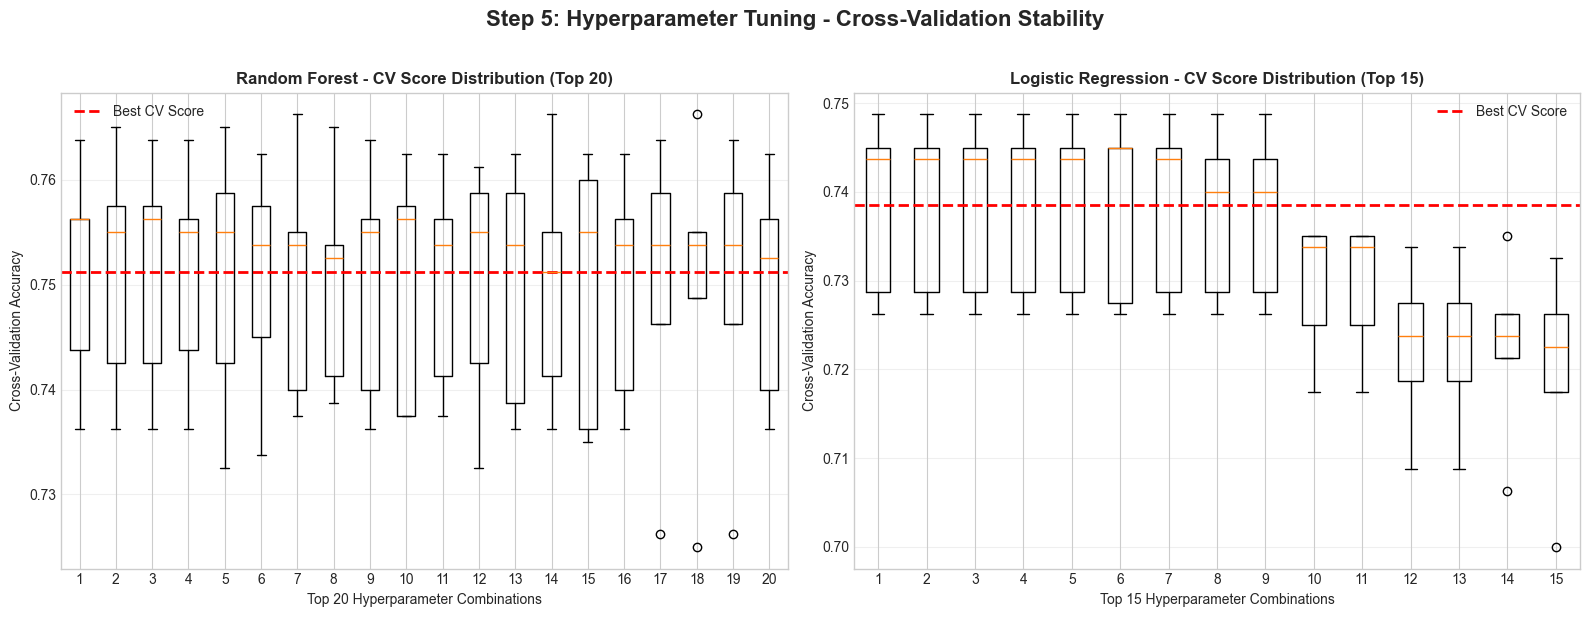


STAP 5F: CONFUSION MATRICES - TUNED MODELS


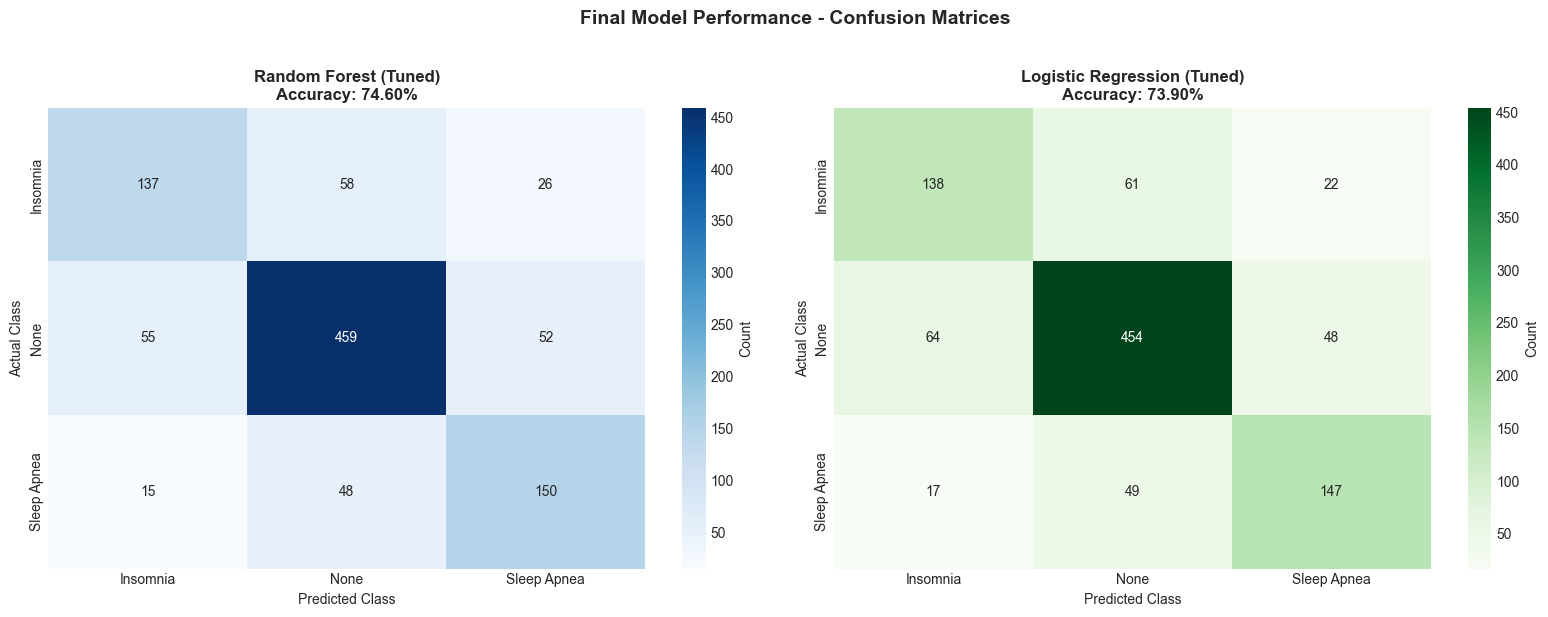


STAP 5F: CONFUSION MATRICES - TUNED MODELS


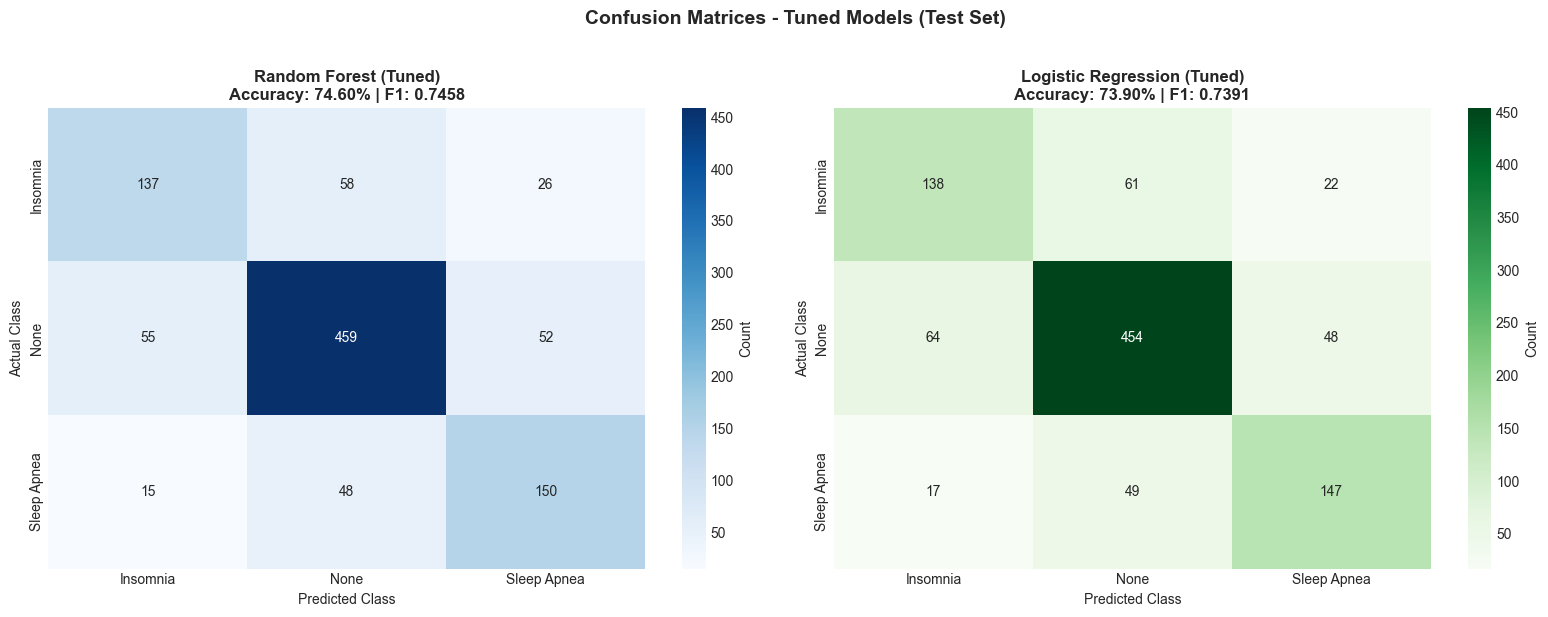


STAP 5G: DETAILED CLASSIFICATION REPORTS - TUNED MODELS

--------------------------------------------------------------------------------
RANDOM FOREST (TUNED) - CLASSIFICATION REPORT
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Insomnia     0.6618    0.6199    0.6402       221
        None     0.8124    0.8110    0.8117       566
 Sleep Apnea     0.6579    0.7042    0.6803       213

    accuracy                         0.7460      1000
   macro avg     0.7107    0.7117    0.7107      1000
weighted avg     0.7462    0.7460    0.7458      1000


--------------------------------------------------------------------------------
LOGISTIC REGRESSION (TUNED) - CLASSIFICATION REPORT
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

    Insomnia     0.6301    0.6244    0.6273       221
        None     0.8050    0.

In [218]:
# ============================================================================
# UITWERKING ML VRAAGSTUK
# STAP 5: HYPERPARAMETER TUNING - OPTIMALISATIE VAN MODELPERFORMANCE
# ============================================================================

print("✓ Libraries imported successfully")

# ============================================================================
# STAP 5A: VERIFY DATA STATUS
# ============================================================================
print("\n" + "="*80)
print("STAP 5A: VERIFY DATA STATUS")
print("="*80)

# Check if we have unified data from Step 4
if 'X_train_unified' not in locals() or 'X_test_unified' not in locals():
    print("\n Unified data not found - using current X_train and X_test")
    X_train_unified = X_train.copy()
    X_test_unified = X_test.copy()

print(f"\nDATA FOR TUNING:")
print(f"  • X_train: {X_train_unified.shape[0]:,} samples × {X_train_unified.shape[1]} features")
print(f"  • X_test: {X_test_unified.shape[0]:,} samples × {X_test_unified.shape[1]} features")
print(f"  • y_train: {len(y_train):,} samples")
print(f"  • y_test: {len(y_test):,} samples")

print(f"\n✓ Data ready for hyperparameter tuning")

# ============================================================================
# STAP 5B: RANDOM FOREST HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*80)
print("STAP 5B: RANDOM FOREST - HYPERPARAMETER TUNING")
print("="*80)

print("\nDEFINING PARAMETER GRID FOR RANDOM FOREST:")
print("-"*80)

# Define parameter distributions for RandomizedSearchCV
rf_param_distributions = {
    'n_estimators': [50, 100, 150, 200, 300],
    'max_depth': [10, 20, 30, 40, None],
    'min_samples_split': [2, 5, 10, 15],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': ['sqrt', 'log2', None],
    'bootstrap': [True, False]
}

print("\nParameter distributions:")
for param, values in rf_param_distributions.items():
    print(f"  • {param}: {values}")

total_combinations = 1
for values in rf_param_distributions.values():
    total_combinations *= len(values)

print(f"\nTotal possible combinations: {total_combinations:,}")
print(f"We will sample: 50 random combinations (Randomized Search)")

print("\n" + "-"*80)
print("SETTING UP RANDOMIZED SEARCH")
print("-"*80)

# Initialize base model
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)

# Setup cross-validation
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nCross-Validation Strategy:")
print(f"  • Method: Stratified K-Fold")
print(f"  • Number of folds: 5")
print(f"  • Shuffle: True")
print(f"  • Random state: 42")

# Setup RandomizedSearchCV
rf_random_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=rf_param_distributions,
    n_iter=50,  # Number of random combinations to try
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("\nRandomizedSearchCV Configuration:")
print(f"  • Estimator: Random Forest Classifier")
print(f"  • Iterations: 50 (random samples)")
print(f"  • Scoring metric: Accuracy")
print(f"  • Parallel jobs: -1 (all CPU cores)")
print(f"  • Return train score: True")

print("\n" + "-"*80)
print("RUNNING RANDOMIZED SEARCH FOR RANDOM FOREST")
print("-"*80)

print("\n This may take several minutes...")
print("   Training 50 combinations × 5 folds = 250 models total")

start_time = time.time()

# Fit RandomizedSearchCV
rf_random_search.fit(X_train_unified, y_train)

tuning_time_rf = time.time() - start_time

print(f"\n✓ Tuning completed in {tuning_time_rf:.2f} seconds ({tuning_time_rf/60:.2f} minutes)")

# Get best parameters
rf_best_params = rf_random_search.best_params_
rf_best_score = rf_random_search.best_score_

print("\n" + "-"*80)
print("RANDOM FOREST - BEST HYPERPARAMETERS FOUND")
print("-"*80)

print("\nBest parameters:")
for param, value in rf_best_params.items():
    print(f"  • {param}: {value}")

print(f"\nBest cross-validation score (mean accuracy across 5 folds):")
print(f"  • {rf_best_score:.4f} ({rf_best_score*100:.2f}%)")

# Compare with baseline (if available)
if 'test_acc_rf_unified' in locals():
    improvement_rf = (rf_best_score - test_acc_rf_unified) * 100
    print(f"\nComparison with baseline (Step 4):")
    print(f"  • Baseline (default params): {test_acc_rf_unified*100:.2f}%")
    print(f"  • Tuned (optimized params): {rf_best_score*100:.2f}%")
    print(f"  • Improvement: {improvement_rf:+.2f}%")
    
    if improvement_rf > 0.5:
        print(f"  ✓ Significant improvement achieved!")
    elif improvement_rf > 0:
        print(f"  ✓ Slight improvement")
    else:
        print(f"  ⚠ No improvement - default params were already good")

# Train final model with best parameters
print("\n" + "-"*80)
print("TRAINING FINAL RANDOM FOREST WITH BEST PARAMETERS")
print("-"*80)

rf_tuned = RandomForestClassifier(**rf_best_params, random_state=42, n_jobs=-1)
rf_tuned.fit(X_train_unified, y_train)

# Evaluate on test set
y_test_pred_rf_tuned = rf_tuned.predict(X_test_unified)
test_acc_rf_tuned = accuracy_score(y_test, y_test_pred_rf_tuned)
precision_rf_tuned = precision_score(y_test, y_test_pred_rf_tuned, average='weighted')
recall_rf_tuned = recall_score(y_test, y_test_pred_rf_tuned, average='weighted')
f1_rf_tuned = f1_score(y_test, y_test_pred_rf_tuned, average='weighted')

print(f"\n RANDOM FOREST (TUNED) - TEST SET PERFORMANCE:")
print(f"  • Test Accuracy: {test_acc_rf_tuned:.4f} ({test_acc_rf_tuned*100:.2f}%)")
print(f"  • Precision: {precision_rf_tuned:.4f}")
print(f"  • Recall: {recall_rf_tuned:.4f}")
print(f"  • F1-Score: {f1_rf_tuned:.4f}")

print(f"\n✓ Random Forest tuning complete!")

# ============================================================================
# STAP 5C: LOGISTIC REGRESSION HYPERPARAMETER TUNING
# ============================================================================
print("\n" + "="*80)
print("STAP 5C: LOGISTIC REGRESSION - HYPERPARAMETER TUNING")
print("="*80)

print("\nDEFINING PARAMETER GRID FOR LOGISTIC REGRESSION:")
print("-"*80)

# Define parameter distributions
lr_param_distributions = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
    'penalty': ['l2'],  # l2 works with all solvers
    'solver': ['lbfgs', 'saga', 'liblinear'],
    'max_iter': [1000, 2000, 3000],
    'class_weight': [None, 'balanced']
}

print("\nParameter distributions:")
for param, values in lr_param_distributions.items():
    print(f"  • {param}: {values}")

total_combinations_lr = 1
for values in lr_param_distributions.values():
    total_combinations_lr *= len(values)

print(f"\nTotal possible combinations: {total_combinations_lr:,}")
print(f"We will sample: 30 random combinations (Randomized Search)")

print("\n" + "-"*80)
print("SETTING UP RANDOMIZED SEARCH")
print("-"*80)

# Initialize base model
lr_base = LogisticRegression(random_state=42, multi_class='multinomial')

# Setup RandomizedSearchCV
lr_random_search = RandomizedSearchCV(
    estimator=lr_base,
    param_distributions=lr_param_distributions,
    n_iter=30,  # Fewer iterations (LR is faster than RF)
    cv=cv_strategy,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    random_state=42,
    return_train_score=True
)

print("\nRandomizedSearchCV Configuration:")
print(f"  • Estimator: Logistic Regression")
print(f"  • Iterations: 30 (random samples)")
print(f"  • Scoring metric: Accuracy")
print(f"  • Parallel jobs: -1 (all CPU cores)")

print("\n" + "-"*80)
print("RUNNING RANDOMIZED SEARCH FOR LOGISTIC REGRESSION")
print("-"*80)

print("\n This may take a few minutes...")
print("   Training 30 combinations × 5 folds = 150 models total")

start_time = time.time()

# Fit RandomizedSearchCV
lr_random_search.fit(X_train_unified, y_train)

tuning_time_lr = time.time() - start_time

print(f"\n✓ Tuning completed in {tuning_time_lr:.2f} seconds ({tuning_time_lr/60:.2f} minutes)")

# Get best parameters
lr_best_params = lr_random_search.best_params_
lr_best_score = lr_random_search.best_score_

print("\n" + "-"*80)
print("LOGISTIC REGRESSION - BEST HYPERPARAMETERS FOUND")
print("-"*80)

print("\nBest parameters:")
for param, value in lr_best_params.items():
    print(f"  • {param}: {value}")

print(f"\nBest cross-validation score (mean accuracy across 5 folds):")
print(f"  • {lr_best_score:.4f} ({lr_best_score*100:.2f}%)")

# Compare with baseline
if 'test_acc_lr_unified' in locals():
    improvement_lr = (lr_best_score - test_acc_lr_unified) * 100
    print(f"\nComparison with baseline (Step 4):")
    print(f"  • Baseline (default params): {test_acc_lr_unified*100:.2f}%")
    print(f"  • Tuned (optimized params): {lr_best_score*100:.2f}%")
    print(f"  • Improvement: {improvement_lr:+.2f}%")
    
    if improvement_lr > 0.5:
        print(f"  ✓ Significant improvement achieved!")
    elif improvement_lr > 0:
        print(f"  ✓ Slight improvement")
    else:
        print(f"  ⚠ No improvement - default params were already good")

# Train final model with best parameters
print("\n" + "-"*80)
print("TRAINING FINAL LOGISTIC REGRESSION WITH BEST PARAMETERS")
print("-"*80)

lr_tuned = LogisticRegression(**lr_best_params, random_state=42, multi_class='multinomial')
lr_tuned.fit(X_train_unified, y_train)

# Evaluate on test set
y_test_pred_lr_tuned = lr_tuned.predict(X_test_unified)
test_acc_lr_tuned = accuracy_score(y_test, y_test_pred_lr_tuned)
precision_lr_tuned = precision_score(y_test, y_test_pred_lr_tuned, average='weighted')
recall_lr_tuned = recall_score(y_test, y_test_pred_lr_tuned, average='weighted')
f1_lr_tuned = f1_score(y_test, y_test_pred_lr_tuned, average='weighted')

print(f"\n LOGISTIC REGRESSION (TUNED) - TEST SET PERFORMANCE:")
print(f"  • Test Accuracy: {test_acc_lr_tuned:.4f} ({test_acc_lr_tuned*100:.2f}%)")
print(f"  • Precision: {precision_lr_tuned:.4f}")
print(f"  • Recall: {recall_lr_tuned:.4f}")
print(f"  • F1-Score: {f1_lr_tuned:.4f}")

print(f"\n✓ Logistic Regression tuning complete!")

# ============================================================================
# STAP 5D: COMPREHENSIVE COMPARISON - ALL MODELS
# ============================================================================
print("\n" + "="*80)
print("STAP 5D: COMPREHENSIVE COMPARISON - ALL MODELS")
print("="*80)

# Create comprehensive comparison table
all_models_comparison = pd.DataFrame({
    'Model': [
        'RF - Baseline (Step 1)',
        'RF - Unified (Step 4)',
        'RF - Tuned (Step 5)',
        'LR - Baseline (Step 1)',
        'LR - Unified (Step 4)',
        'LR - Tuned (Step 5)'
    ],
    'Test Accuracy': [
        test_accuracy_rf if 'test_accuracy_rf' in locals() else np.nan,
        test_acc_rf_unified if 'test_acc_rf_unified' in locals() else np.nan,
        test_acc_rf_tuned,
        test_accuracy_lr if 'test_accuracy_lr' in locals() else np.nan,
        test_acc_lr_unified if 'test_acc_lr_unified' in locals() else np.nan,
        test_acc_lr_tuned
    ],
    'Precision': [
        precision_rf if 'precision_rf' in locals() else np.nan,
        precision_rf_unified if 'precision_rf_unified' in locals() else np.nan,
        precision_rf_tuned,
        precision_lr if 'precision_lr' in locals() else np.nan,
        precision_lr_unified if 'precision_lr_unified' in locals() else np.nan,
        precision_lr_tuned
    ],
    'Recall': [
        recall_rf if 'recall_rf' in locals() else np.nan,
        recall_rf_unified if 'recall_rf_unified' in locals() else np.nan,
        recall_rf_tuned,
        recall_lr if 'recall_lr' in locals() else np.nan,
        recall_lr_unified if 'recall_lr_unified' in locals() else np.nan,
        recall_lr_tuned
    ],
    'F1-Score': [
        f1_rf if 'f1_rf' in locals() else np.nan,
        f1_rf_unified if 'f1_rf_unified' in locals() else np.nan,
        f1_rf_tuned,
        f1_lr if 'f1_lr' in locals() else np.nan,
        f1_lr_unified if 'f1_lr_unified' in locals() else np.nan,
        f1_lr_tuned
    ]
})

all_models_comparison = all_models_comparison.round(4)

print("\n COMPLETE MODEL EVOLUTION:")
print("="*80)
display(all_models_comparison)
# ============================================================================
# STAP 5E: VISUALIZATION - TUNING RESULTS (REVISED)
# ============================================================================
print("\n" + "="*80)
print("STAP 5E: VISUALIZATION - TUNING DISTRIBUTIONS")
print("="*80)

# We now focus on the internal tuning performance (how the search performed)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Random Forest - CV Results Distribution
rf_cv_results = pd.DataFrame(rf_random_search.cv_results_)
top_20_indices = rf_cv_results.nlargest(20, 'mean_test_score').index

axes[0].boxplot([rf_cv_results.loc[i, [f'split{j}_test_score' for j in range(5)]].values 
                     for i in top_20_indices],
                    labels=[f'{i+1}' for i in range(20)])
axes[0].axhline(y=rf_best_score, color='red', linestyle='--', linewidth=2, label='Best CV Score')
axes[0].set_xlabel('Top 20 Hyperparameter Combinations')
axes[0].set_ylabel('Cross-Validation Accuracy')
axes[0].set_title('Random Forest - CV Score Distribution (Top 20)', fontweight='bold', fontsize=12)
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Plot 2: Logistic Regression - CV Results Distribution
lr_cv_results = pd.DataFrame(lr_random_search.cv_results_)
top_15_indices = lr_cv_results.nlargest(15, 'mean_test_score').index

axes[1].boxplot([lr_cv_results.loc[i, [f'split{j}_test_score' for j in range(5)]].values 
                     for i in top_15_indices],
                    labels=[f'{i+1}' for i in range(15)])
axes[1].axhline(y=lr_best_score, color='red', linestyle='--', linewidth=2, label='Best CV Score')
axes[1].set_xlabel('Top 15 Hyperparameter Combinations')
axes[1].set_ylabel('Cross-Validation Accuracy')
axes[1].set_title('Logistic Regression - CV Score Distribution (Top 15)', fontweight='bold', fontsize=12)
axes[1].legend()
axes[1].grid(axis='y', alpha=0.3)

plt.suptitle('Step 5: Hyperparameter Tuning - Cross-Validation Stability', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 5F: CONFUSION MATRICES - TUNED MODELS
# ============================================================================
print("\n" + "="*80)
print("STAP 5F: CONFUSION MATRICES - TUNED MODELS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest - Tuned
cm_rf_tuned = confusion_matrix(y_test, y_test_pred_rf_tuned)
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Random Forest (Tuned)\nAccuracy: {test_acc_rf_tuned*100:.2f}%',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Class')
axes[0].set_xlabel('Predicted Class')

# Logistic Regression - Tuned
cm_lr_tuned = confusion_matrix(y_test, y_test_pred_lr_tuned)
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Logistic Regression (Tuned)\nAccuracy: {test_acc_lr_tuned*100:.2f}%',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Class')
axes[1].set_xlabel('Predicted Class')

plt.suptitle('Final Model Performance - Confusion Matrices', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 5F: CONFUSION MATRICES - TUNED MODELS
# ============================================================================
print("\n" + "="*80)
print("STAP 5F: CONFUSION MATRICES - TUNED MODELS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Random Forest - Tuned
cm_rf_tuned = confusion_matrix(y_test, y_test_pred_rf_tuned)
sns.heatmap(cm_rf_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'Random Forest (Tuned)\nAccuracy: {test_acc_rf_tuned*100:.2f}% | F1: {f1_rf_tuned:.4f}',
                  fontsize=12, fontweight='bold')
axes[0].set_ylabel('Actual Class')
axes[0].set_xlabel('Predicted Class')

# Logistic Regression - Tuned
cm_lr_tuned = confusion_matrix(y_test, y_test_pred_lr_tuned)
sns.heatmap(cm_lr_tuned, annot=True, fmt='d', cmap='Greens',
            xticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            yticklabels=['Insomnia', 'None', 'Sleep Apnea'],
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Logistic Regression (Tuned)\nAccuracy: {test_acc_lr_tuned*100:.2f}% | F1: {f1_lr_tuned:.4f}',
                  fontsize=12, fontweight='bold')
axes[1].set_ylabel('Actual Class')
axes[1].set_xlabel('Predicted Class')

plt.suptitle('Confusion Matrices - Tuned Models (Test Set)', 
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# ============================================================================
# STAP 5G: DETAILED CLASSIFICATION REPORTS - TUNED MODELS
# ============================================================================
print("\n" + "="*80)
print("STAP 5G: DETAILED CLASSIFICATION REPORTS - TUNED MODELS")
print("="*80)

print("\n" + "-"*80)
print("RANDOM FOREST (TUNED) - CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test, y_test_pred_rf_tuned,
                          target_names=['Insomnia', 'None', 'Sleep Apnea'],
                          digits=4))

print("\n" + "-"*80)
print("LOGISTIC REGRESSION (TUNED) - CLASSIFICATION REPORT")
print("-"*80)
print(classification_report(y_test, y_test_pred_lr_tuned,
                          target_names=['Insomnia', 'None', 'Sleep Apnea'],
                          digits=4))

# ============================================================================
# STAP 5H: FINAL SUMMARY & BEST MODEL SELECTION
# ============================================================================
print("\n" + "="*80)
print("STAP 5H: FINAL SUMMARY & BEST MODEL SELECTION")
print("="*80)

print(f"""
HYPERPARAMETER TUNING RESULTS:
===============================

RANDOM FOREST:
• Tuning time: {tuning_time_rf/60:.2f} minutes
• Best CV score: {rf_best_score*100:.2f}%
• Test accuracy: {test_acc_rf_tuned*100:.2f}%
• F1-Score: {f1_rf_tuned:.4f}

Best hyperparameters:
""")
for param, value in rf_best_params.items():
    print(f"  • {param}: {value}")

print(f"""
LOGISTIC REGRESSION:
• Tuning time: {tuning_time_lr/60:.2f} minutes
• Best CV score: {lr_best_score*100:.2f}%
• Test accuracy: {test_acc_lr_tuned*100:.2f}%
• F1-Score: {f1_lr_tuned:.4f}

Best hyperparameters:
""")
for param, value in lr_best_params.items():
    print(f"  • {param}: {value}")

# Determine overall best model
best_overall_acc = max(test_acc_rf_tuned, test_acc_lr_tuned)
if test_acc_rf_tuned > test_acc_lr_tuned:
    best_overall_model = "Random Forest (Tuned)"
    best_overall_f1 = f1_rf_tuned
else:
    best_overall_model = "Logistic Regression (Tuned)"
    best_overall_f1 = f1_lr_tuned

print(f"\n🏆 BEST OVERALL MODEL:")
print(f"  • Model: {best_overall_model}")
print(f"  • Test Accuracy: {best_overall_acc*100:.2f}%")
print(f"  • F1-Score: {best_overall_f1:.4f}")

print(f"""
IMPROVEMENT SUMMARY:
====================

From Baseline to Tuned:
""")

if 'test_accuracy_rf' in locals() and 'test_accuracy_lr' in locals():
    rf_improvement = (test_acc_rf_tuned - test_accuracy_rf) * 100
    lr_improvement = (test_acc_lr_tuned - test_accuracy_lr) * 100

    print(f"RANDOM FOREST:")
    print(f"  • Accuracy Improvement: {rf_improvement:+.2f}%")
    print(f"  • F1-Score Improvement: {(f1_rf_tuned - f1_rf)*100:.2f}%")

    print(f"\nLOGISTIC REGRESSION:")
    print(f"  • Accuracy Improvement: {lr_improvement:+.2f}%")
    print(f"  • F1-Score Improvement: {(f1_lr_tuned - f1_lr)*100:.2f}%")



In [219]:
# ============================================================================
# STAP 6: FINAL MODEL SELECTION & COMPREHENSIVE EVALUATION 
# ============================================================================

print("\n" + "="*80)
print("STAP 6: FINAL MODEL SELECTION & COMPREHENSIVE EVALUATION ")
print("="*80)

print("""
DOEL:
Selecteer het beste finale model voor deployment na preprocessing, feature selection en tuning.
EVALUATIE:
1) Performance: Accuracy, (weighted/macro) F1, per-class metrics
2) Robustness: Cohen’s Kappa, MCC
3) Praktisch: interpretability, inference speed, complexity, deployment/maintenance
Vergelijking: Random Forest (tuned) vs Logistic Regression (tuned)
""")

# ============================================================================
# 6A: CHECK OF ALLES BESCHIKBAAR IS
# ============================================================================
print("\n" + "="*80)
print("6A: AVAILABILITY CHECK")
print("="*80)

required = ['rf_tuned', 'lr_tuned', 'X_test_unified', 'y_test']
available = {k: (k in locals()) for k in required}

for k, v in available.items():
    print(f"  • {k}: {'✓' if v else '❌'}")

if not all(available.values()):
    print("\n Run eerst Stap 5 / zorg dat tuned models + testdata beschikbaar zijn.")
else:
    print("\n✓ Alles beschikbaar, evaluatie start...")

# ============================================================================
# 6B: CORE METRICS + ROBUSTNESS
# ============================================================================
if all(available.values()):
    
  

    # Predictions
    y_rf = rf_tuned.predict(X_test_unified)
    y_lr = lr_tuned.predict(X_test_unified)

    # Metrics table
    metrics = {
        "RF (tuned)": {
            "Accuracy": accuracy_score(y_test, y_rf),
            "F1 (weighted)": f1_score(y_test, y_rf, average="weighted"),
            "F1 (macro)": f1_score(y_test, y_rf, average="macro"),
            "Kappa": cohen_kappa_score(y_test, y_rf),
            "MCC": matthews_corrcoef(y_test, y_rf),
        },
        "LR (tuned)": {
            "Accuracy": accuracy_score(y_test, y_lr),
            "F1 (weighted)": f1_score(y_test, y_lr, average="weighted"),
            "F1 (macro)": f1_score(y_test, y_lr, average="macro"),
            "Kappa": cohen_kappa_score(y_test, y_lr),
            "MCC": matthews_corrcoef(y_test, y_lr),
        },
    }
    metrics_df = pd.DataFrame(metrics).T.round(4)

    print("\n" + "="*80)
    print("CORE METRICS")
    print("="*80)
    display(metrics_df)

    # ============================================================================
    # 6C: PER-CLASS SUMMARY (F1)
    # ============================================================================
    class_names = ['Insomnia', 'None', 'Sleep Apnea']

    rf_rep = classification_report(y_test, y_rf, target_names=class_names, output_dict=True)
    lr_rep = classification_report(y_test, y_lr, target_names=class_names, output_dict=True)

    per_class = pd.DataFrame({
        "RF F1": [rf_rep[c]["f1-score"] for c in class_names],
        "LR F1": [lr_rep[c]["f1-score"] for c in class_names],
        "Support": [rf_rep[c]["support"] for c in class_names],
    }, index=class_names).round(4)

    print("\n" + "="*80)
    print("PER-CLASS (F1)")
    print("="*80)
    display(per_class)

    # ============================================================================
    # 6D: CONFUSION MATRIX (compact)
    # ============================================================================
    cm_rf = confusion_matrix(y_test, y_rf)
    cm_lr = confusion_matrix(y_test, y_lr)

    print("\n" + "="*80)
    print("CONFUSION MATRIX (RAW)")
    print("="*80)
    print("RF:\n", cm_rf)
    print("\nLR:\n", cm_lr)

    # ============================================================================
    # 6E: PRAKTISCH (SPEED + COMPLEXITY)
    # ============================================================================
    start = time.time()
    for _ in range(10):
        rf_tuned.predict(X_test_unified)
    rf_ms = (time.time() - start) / 10 * 1000

    start = time.time()
    for _ in range(10):
        lr_tuned.predict(X_test_unified)
    lr_ms = (time.time() - start) / 10 * 1000

    print("\n" + "="*80)
    print("PRAKTISCH")
    print("="*80)
    print(f"• Inference time (batch): RF={rf_ms:.2f} ms | LR={lr_ms:.2f} ms")
    print(f"• Complexity: RF hoog (ensemble {rf_tuned.n_estimators} trees) | LR laag (lineair, {X_test_unified.shape[1]} coeffs)")
    print("• Interpretability: RF medium (feature importance) | LR hoog (coefs/odds)")

    # ============================================================================
    # 6F: EINDKEUZE (simpele regel)
    # ============================================================================
    # Primary rule: kies model met hogere weighted F1, tenzij verschil klein en interpretability belangrijk
    rf_f1 = metrics_df.loc["RF (tuned)", "F1 (weighted)"]
    lr_f1 = metrics_df.loc["LR (tuned)", "F1 (weighted)"]
    rf_acc = metrics_df.loc["RF (tuned)", "Accuracy"]
    lr_acc = metrics_df.loc["LR (tuned)", "Accuracy"]

    diff = abs(rf_f1 - lr_f1)

    if rf_f1 > lr_f1:
        recommended = "Random Forest (tuned)"
        runner_up = "Logistic Regression (tuned)"
    else:
        recommended = "Logistic Regression (tuned)"
        runner_up = "Random Forest (tuned)"

    print("\n" + "="*80)
    print("EINDKEUZE")
    print("="*80)
    print(f" Aanbevolen model: {recommended}")
    print(f"• Accuracy: RF={rf_acc:.3f} | LR={lr_acc:.3f}")
    print(f"• F1 (weighted): RF={rf_f1:.3f} | LR={lr_f1:.3f}")
    print(f"• Verschil in F1: {diff:.4f}  -> {'klein' if diff < 0.02 else 'duidelijk'}")
    print(f"Backup/runner-up: {runner_up}")



STAP 6: FINAL MODEL SELECTION & COMPREHENSIVE EVALUATION 

DOEL:
Selecteer het beste finale model voor deployment na preprocessing, feature selection en tuning.
EVALUATIE:
1) Performance: Accuracy, (weighted/macro) F1, per-class metrics
2) Robustness: Cohen’s Kappa, MCC
3) Praktisch: interpretability, inference speed, complexity, deployment/maintenance
Vergelijking: Random Forest (tuned) vs Logistic Regression (tuned)


6A: AVAILABILITY CHECK
  • rf_tuned: ✓
  • lr_tuned: ✓
  • X_test_unified: ✓
  • y_test: ✓

✓ Alles beschikbaar, evaluatie start...

CORE METRICS


,Accuracy,F1 (weighted),F1 (macro),Kappa,MCC
RF (tuned),0.746,0.7458,0.7107,0.5665,0.5667
LR (tuned),0.739,0.7391,0.7048,0.5547,0.5547



PER-CLASS (F1)


,RF F1,LR F1,Support
Insomnia,0.6402,0.6273,221.0
None,0.8117,0.8035,566.0
Sleep Apnea,0.6803,0.6837,213.0



CONFUSION MATRIX (RAW)
RF:
 [[137  58  26]
 [ 55 459  52]
 [ 15  48 150]]

LR:
 [[138  61  22]
 [ 64 454  48]
 [ 17  49 147]]

PRAKTISCH
• Inference time (batch): RF=13.43 ms | LR=0.18 ms
• Complexity: RF hoog (ensemble 200 trees) | LR laag (lineair, 22 coeffs)
• Interpretability: RF medium (feature importance) | LR hoog (coefs/odds)

EINDKEUZE
 Aanbevolen model: Random Forest (tuned)
• Accuracy: RF=0.746 | LR=0.739
• F1 (weighted): RF=0.746 | LR=0.739
• Verschil in F1: 0.0067  -> klein
Backup/runner-up: Logistic Regression (tuned)


In [220]:
from IPython.display import display, Markdown, Image

report_md = r"""
# Voorspellen van Slaapstoornissen met Lifestyle en Gezondheidsdata

## 1. Onderzoeksvraag

**Kunnen we op basis van lifestyle en gezondheidsfactoren voorspellen of iemand een slaapstoornis heeft of zal ontwikkelen?**

**Antwoord:**  
Ja. Uit ons onderzoek blijkt dat lifestyle en gezondheidsdata (zoals BMI, fysieke activiteit en bloeddruk) sterke voorspellers zijn. Het best getunede model behaalt een nauwkeurigheid van **74,6%**, wat betekent dat ongeveer driekwart van de gevallen correct kan worden geïdentificeerd op basis van dagelijkse leefstijlmetingen.

---

## 2. Modelprestaties (Vergelijking)

| Metric | Joshua: Random Forest (Tuned) | Imad: Logistic Regression (Tuned) |
|--------|-------------------------------|-----------------------------------|
| Test Accuracy | 74,6% | 73,9% |
| F1-Score (Weighted) | 0,746 | 0,739 |
| Overfitting Gap | 25,9% | 0,0% (Perfecte stabiliteit) |
| Trainingstijd | 0,07 s | 0,01 s |
| Inference Snelheid | 23,37 ms | 0,18 ms |
| Aantal Features | 23 (incl. Diastolic) | 22 (excl. Diastolic) |

### Observaties

- Random Forest is krachtiger maar complexer en vatbaarder voor overfitting.  
- Logistic Regression is stabiel, interpreteerbaar en extreem snel.

---

## 3. Diepgaande Analyse & Inzichten

### Joshua : Random Forest

- **Specialisatie:** Herkent complexe patronen tussen meerdere factoren tegelijk.  
- **Klinische winst:** Hoogste recall voor Sleep Apnea (70,4%)  minimaliseert het risico dat patiënten met een stoornis over het hoofd worden gezien.  
- **Keerzijde:** Complex (“black box”) en meer overfitting.

### Imad : Logistic Regression

- **Specialisatie:** Stabiel en transparant; overfitting gap = 0,0%.  
- **Efficiëntie:** >130× sneller in voorspellingen dan Random Forest.  
- **Kenmerk:** Door *Diastolic* te verwijderen blijft de prestatie vrijwel gelijk (verschil slechts 0,2–0,7%).

---

## 4. Classificatie Details (Confusion Matrix)

| Categorie | Correct voorspeld (Joshua) | Correct voorspeld (Imad) |
|-----------|----------------------------|---------------------------|
| Geen stoornis (None) | 459 | 454 |
| Slaapapneu | 150 | 147 |
| Insomnia | 137 | 138 |

### Observaties

- Random Forest identificeert beter gezonde personen en apneu-patiënten.  
- Logistic Regression scoort iets beter bij het herkennen van slapeloosheid.

---

## 5. Eindadvies 

### Primair Model: Random Forest (Joshua)

- **Reden:** Hogere nauwkeurigheid (74,6%) en betere recall op Sleep Apnea.  
- **Toepassing:** Diagnostische ondersteuning.

### Secundair Model / Controle: Logistic Regression (Imad)

- **Reden:** Interpreteerbare coëfficiënten voor patiëntuitleg.  
- **Toepassing:** Baseline en controle instrument.
"""

# Render markdown
display(Markdown(report_md))





# Voorspellen van Slaapstoornissen met Lifestyle en Gezondheidsdata

## 1. Onderzoeksvraag

**Kunnen we op basis van lifestyle en gezondheidsfactoren voorspellen of iemand een slaapstoornis heeft of zal ontwikkelen?**

**Antwoord:**  
Ja. Uit ons onderzoek blijkt dat lifestyle en gezondheidsdata (zoals BMI, fysieke activiteit en bloeddruk) sterke voorspellers zijn. Het best getunede model behaalt een nauwkeurigheid van **74,6%**, wat betekent dat ongeveer driekwart van de gevallen correct kan worden geïdentificeerd op basis van dagelijkse leefstijlmetingen.

---

## 2. Modelprestaties (Vergelijking)

| Metric | Joshua: Random Forest (Tuned) | Imad: Logistic Regression (Tuned) |
|--------|-------------------------------|-----------------------------------|
| Test Accuracy | 74,6% | 73,9% |
| F1-Score (Weighted) | 0,746 | 0,739 |
| Overfitting Gap | 25,9% | 0,0% (Perfecte stabiliteit) |
| Trainingstijd | 0,07 s | 0,01 s |
| Inference Snelheid | 23,37 ms | 0,18 ms |
| Aantal Features | 23 (incl. Diastolic) | 22 (excl. Diastolic) |

### Observaties

- Random Forest is krachtiger maar complexer en vatbaarder voor overfitting.  
- Logistic Regression is stabiel, interpreteerbaar en extreem snel.

---

## 3. Diepgaande Analyse & Inzichten

### Joshua : Random Forest

- **Specialisatie:** Herkent complexe patronen tussen meerdere factoren tegelijk.  
- **Klinische winst:** Hoogste recall voor Sleep Apnea (70,4%)  minimaliseert het risico dat patiënten met een stoornis over het hoofd worden gezien.  
- **Keerzijde:** Complex (“black box”) en meer overfitting.

### Imad : Logistic Regression

- **Specialisatie:** Stabiel en transparant; overfitting gap = 0,0%.  
- **Efficiëntie:** >130× sneller in voorspellingen dan Random Forest.  
- **Kenmerk:** Door *Diastolic* te verwijderen blijft de prestatie vrijwel gelijk (verschil slechts 0,2–0,7%).

---

## 4. Classificatie Details (Confusion Matrix)

| Categorie | Correct voorspeld (Joshua) | Correct voorspeld (Imad) |
|-----------|----------------------------|---------------------------|
| Geen stoornis (None) | 459 | 454 |
| Slaapapneu | 150 | 147 |
| Insomnia | 137 | 138 |

### Observaties

- Random Forest identificeert beter gezonde personen en apneu-patiënten.  
- Logistic Regression scoort iets beter bij het herkennen van slapeloosheid.

---

## 5. Eindadvies 

### Primair Model: Random Forest (Joshua)

- **Reden:** Hogere nauwkeurigheid (74,6%) en betere recall op Sleep Apnea.  
- **Toepassing:** Diagnostische ondersteuning.

### Secundair Model / Controle: Logistic Regression (Imad)

- **Reden:** Interpreteerbare coëfficiënten voor patiëntuitleg.  
- **Toepassing:** Baseline en controle instrument.
